<a href="https://colab.research.google.com/github/kenairr/Endogrip/blob/main/EMG_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FUNCTIONS DEFINTIONS

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# FUNCTION TO READ CSV FILE
import csv
import pandas as pd
import numpy as np
import os
import pathlib

def empty_to_zero(arr):
    return [0.0 if (i ==' ') or (i=="") else float(i) for i in arr]

def count_file_lines(file):
    with open(file, "rb") as f:
        num_lines = sum(1 for _ in f)
    return num_lines

def get_filename(path):
    return os.path.basename(path).split('/')[-1]

class CSVFile:
    def __init__(self, filename):
        # Constants for EMG CSV File structure
        HEADER_ROW_SIZE = 6
        NUM_COLS = 8
        self.name = filename
        self.date = None
        self.column_names = []
        self.column_frequencies = []
        # Row number in the CSV file that the actual data starts (past the header)
        self.__data_row_num = 7

        # Count the number of rows in the CSV file
        num_rows = count_file_lines(filename) - HEADER_ROW_SIZE

        self.num_columns = NUM_COLS
        self.num_rows = int(num_rows)

        # n rows by m columns
        self.data = np.empty((num_rows, NUM_COLS))


    def parse_header(self):
        # Row number with Date/Time information
        DATE_ROW_NUM = 1
        HEADER_FREQUENCY_COL = 6
        DATA_COLUMN_ROW = 5

        with open(self.name, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            row_idx = 0
            data_row_idx = 0
            for row in spamreader:
                if row_idx == DATE_ROW_NUM:
                    # Check input file is properly formatted, with second row being Date/Time
                    assert(row[0] == "Date/Time:")
                    # Log the date of the collected data
                    self.date = row[1]
                    row_idx += 1
                    continue

                if row_idx == DATA_COLUMN_ROW:
                    for col_num in range(0, len(row)):
                        column_name = row[col_num]
                        # Remove spaces at the beginning and at the end of the column name string
                        col_name = column_name.strip(' ')
                        self.column_names.append((col_num, col_name))

                    row_idx += 1
                    continue

                if row_idx == HEADER_FREQUENCY_COL:
                    for col_num in range(0, len(row)):
                        freq_string = row[col_num]
                        if "Hz" in freq_string:
                            freq = float(freq_string.strip('').replace(" Hz", ""))
                            self.column_frequencies.append(freq)
                        else:
                            self.column_frequencies.append(0.0)
                    row_idx += 1
                    continue

                # Header rows
                if row_idx < self.__data_row_num:
                    row_idx += 1
                    continue
                try:
                    arr = np.array(empty_to_zero(row))
                    self.data[data_row_idx] = arr
                except:
                    raise Exception("[ERROR]: Error encountered processing row number {}".format(data_row_idx))

                # Increment row counters
                data_row_idx += 1
                row_idx += 1

    def get_column_frequency(self, col_num):
        return self.column_frequencies[col_num]

# FUNCTION TO DEFINE THE DIFFERENT FILTERS
import scipy as scipy
from scipy.signal import butter, filtfilt, iirnotch
import numpy as np

def movmean(arr, k):
    even_k = (k % 2 == 0)  # Check if window size is even
    output_arr = []

    if even_k:
        for i in range(len(arr)):
            if i - k + 1 < 0:
                window = arr[:i+1]
            else:
                window = arr[i-k+1:i+1]
            output_arr.append(np.mean(window))
    else:
        centered_window = (k - 1) // 2
        for i in range(len(arr)):
            if i - centered_window < 0:
                window = arr[:i+centered_window+1]
            else:
                window = arr[i-centered_window:i+centered_window+1]
            output_arr.append(np.mean(window))

    return np.array(output_arr)  # Ensure it's a NumPy array for compatibility

def moving_average(arr, n):
    for i in range(0, arr-n-1, n):
	    print(i)

def lpf(l, nq, col):
    loww = l/nq
    b, a = scipy.signal.butter(4, loww, btype='low')
    return scipy.signal.filtfilt(b, a, col)

def hpf(h, nq, col):
    h = h/nq
    b, a = scipy.signal.butter(4, h, btype='high')
    return scipy.signal.filtfilt(b, a, col)

def bpf(l, h, nq, data, order=4):
    low = l / nq
    high = h / nq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

def notch_filter(fs, col):
    Q = 30
    f0 = 60 # 60 Hz
    b, a = scipy.signal.iirnotch(f0, Q, fs)
    return scipy.signal.filtfilt(b, a, col)

def get_max(h, l, col_num, csv_file):
    col = csv_file.data[:, col_num]
    col_mean = np.mean(col)
    assert(len(csv_file.data[:, 1])==csv_file.num_rows)

    nq = csv_file.get_column_frequency(col_num) / 2
    print("Column num: {}, Col frequency: {}".format(col_num, nq))

    emg_filtered = bpf(h, l, nq, col)
    return max(emg_filtered)


def normalize_by_max(h, l, col_num, csv_file, _max):
    col = csv_file.data[:, col_num]

    # Get the mean of column
    col_mean = np.mean(col)
    assert(len(csv_file.data[:, 1])==csv_file.num_rows)

    # Perform element-wise subtraction of column 2 by the mean of column 2
    col_mean_corrected = col - col_mean

    # nyquist frequency half of sampling rate
    nq = csv_file.get_column_frequency(col_num) / 2

    emg_filtered = bpf(h, l, nq, col)
    return emg_filtered / _max

# Fourier Transform
def plot_fft(signal, filtered_signal, fs, title):
    # Length of the signals (assuming both signals have the same length)
    n = len(signal)
    signal = signal - np.mean(signal)  # Remove DC component
    filtered_signal = filtered_signal - np.mean(filtered_signal)  # Remove DC component from filtered signal

    # Frequency range
    freq = np.fft.rfftfreq(n, d=1/fs)

    # FFT computation
    fft_values = np.fft.rfft(signal)
    fft_filtered_values = np.fft.rfft(filtered_signal)

    # Magnitude of the FFT
    fft_magnitude = np.abs(fft_values)
    fft_filtered_magnitude = np.abs(fft_filtered_values)

    # Plot both FFTs on the same graph
    plt.figure(figsize=(14, 6))
    plt.plot(freq, fft_magnitude, label='Original Signal', color='blue')
    plt.plot(freq, fft_filtered_magnitude, label='Filtered Signal', color='indianred')

    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.legend()
    plt.show()

# signal to noise ratio (SNR)
def calculate_snr(signal, noise):
    signal_power = np.mean(np.square(signal))
    noise_power = np.mean(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def get_filename(path):
    return os.path.basename(path).split('/')[-1]

# Function to calculate duty cycle and average EMG during active periods
def calculate_duty_cycle_and_emg(emg_envelope, sr, threshold, num_slices, window_length):
    slicelength = round(len(emg_envelope) / num_slices)  # Calculate slice length
    dcs = []
    emgs = []

    for i in range(num_slices):
        slice_data = emg_envelope[i * slicelength:(i + 1) * slicelength]

        if len(slice_data) == 0:
            dcs.append(0)
            emgs.append(0)
            continue

        # Calculate duty cycle (percentage of time above the threshold)
        dc_count = np.sum(slice_data > threshold)
        dc = dc_count / len(slice_data) if len(slice_data) > 0 else 0

        # Calculate average EMG during active periods
        active_periods = slice_data[slice_data > threshold]
        emg = np.mean(active_periods) if len(active_periods) > 0 else 0

        dcs.append(dc*100)  # Percentage
        emgs.append(emg) # Scaling for potential percentage representation

    return dcs, emgs

#from csv_parser import CSVFile
import numpy as np
np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)
import scipy as scipy
from scipy import signal
from scipy.signal import butter, filtfilt, welch
import os
from scipy import integrate
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# RECTIFICATION AND LOW PASS METHOD

In [ ]:
# MVC CALCULATION
import os
DATA_CALIBRATE_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_1/MVC_M/"
column_max_values = [0.0, 0.0, 0.0, 0.0]
column_max_files = [None, None, None, None]
max_values = {1: 0.0, 3: 0.0, 5: 0.0, 7: 0.0}

# Iterate through all files in the defined directory
for file in os.listdir(DATA_CALIBRATE_DIR):
    print("Reading file: ", DATA_CALIBRATE_DIR + file)
    csv_file = CSVFile(DATA_CALIBRATE_DIR + file)
    csv_file.parse_header()

    column_max_value_index = 0
    for col_num in range(1, 8, 2):
        # Get the sampling frequency based on the current column number
        fs = csv_file.get_column_frequency(col_num)
        nq = fs / 2 # nyquist freq
        col = csv_file.data[:, col_num]
        col = col - np.mean(col)  # Remove DC offset

        # Notch Filter to remove electrical noise at powerline freq.
        notch_filtered_col = notch_filter(fs, col)

        # Low-pass Filter
        l = 450
        lpf_filtered_col = lpf(l, nq, notch_filtered_col)

        # Linear Envelope (rectification and low pass filter)
        recitifed_signal = np.absolute(lpf_filtered_col)
        emg_envelope = lpf(10, fs, recitifed_signal)

        """
        # Plot original vs. filtered signal
        plt.figure(figsize=(10, 5))
        time_axis = np.arange(len(notch_filtered_col)) / fs  # Correct time axis calculation
        plt.plot(time_axis, notch_filtered_col, 'b', label="Original Signal", alpha=0.7)
        plt.xlim(20, 28)  # Only plot between 20-30 seconds
        plt.plot(time_axis, lpf_filtered_col, 'r', label="Filtered Signal")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()
        plt.show()
        """
        # Moving window to find peak amplitude
        WINDOW_SIZE = 0.1
        window_range = round(fs * WINDOW_SIZE)

        # Calculate moving average of the mean-corrected data
        mean_data = movmean(emg_envelope, window_range)

        # Get the max value after filtering
        _max_val = np.max(mean_data)
        print("Column number: {}, Max Value: {}".format(col_num, _max_val))

        if _max_val > column_max_values[column_max_value_index]:
            column_max_values[column_max_value_index] = _max_val
            column_max_files[column_max_value_index] = str(file)
            max_values[col_num] = _max_val

        column_max_value_index += 1

print("Column max values: ", column_max_values)
print("Column max files: ", column_max_files)
print("Max values: ", max_values)
print(fs)

Reading file:  /content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_1/MVC_M/Copy of Trial_23.csv
Column number: 1, Max Value: 0.0490366857533251
Column number: 3, Max Value: 0.11534449363754525
Column number: 5, Max Value: 0.10947083999727349
Column number: 7, Max Value: 0.05568460361971297
Reading file:  /content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_1/MVC_M/Copy of Trial_24.csv
Column number: 1, Max Value: 0.04039926110345297
Column number: 3, Max Value: 0.029739413894060946
Column number: 5, Max Value: 0.660231673482589
Column number: 7, Max Value: 0.09872372056633408
Reading file:  /content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_1/MVC_M/Copy of Trial_28.csv
Column number: 1, Max Value: 0.05242855818830396
Column number: 3, Max Value: 0.11854856718774379
Column number: 5, Max Value: 0.358769878830154
Column number: 7, Max Value: 0.1006945941929216
Reading file:  /content/drive/Shareddri

Processing file: Barehand.csv
Processing file: Endogrip.csv


'\n                # Moving window calculation to find %MVC\n                window_length_seconds = 0.125\n                window_overlap_seconds = 0.0625\n\n                window_size_samples = round(fs * window_length_seconds)\n                overlap_size_samples = round(fs * window_overlap_seconds)\n                step_size_samples = window_size_samples - overlap_size_samples\n\n                mean_data = [\n                    np.mean(emg_envelope[start:start + window_size_samples])\n                    for start in range(0, len(emg_envelope) - window_size_samples + 1, step_size_samples)\n                ]\n                mean_data = np.array(mean_data)\n                norm = mean_data / max_values[col_num]\n                MVC_percent = norm * 100\n\n                all_MVC_percent[col_num] = MVC_percent\n                highest_mvc_percent[col_num] = np.max(MVC_percent)\n                filtered_mvc_percent = MVC_percent[MVC_percent > THRESHOLD]\n\n                if len(f

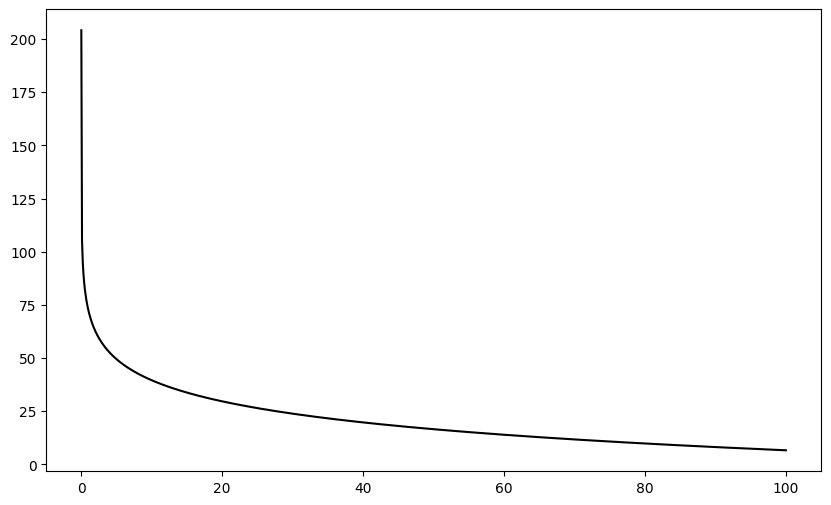

In [ ]:
# MEAN ACTIVE EMG, DUTY CYCLE, AND FATIGUE RISK VALUE
# This code will save fatigue risk value and mean active EMG data to the respective subject's folder (Modify Folder Location)
DATA_CALIBRATE_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_9/Mock Colonoscopy/" # CHANGE FOLDER
THRESHOLD = 5
columns = [1, 3, 5, 7]
muscle_labels = ["APB", "ECR", "FDS", "FCR"]

files_data = {}
plotting = True

# TLV curve
DC = np.linspace(0, 1, 1000)
TLV = 100 * (-0.143 * np.log(DC + 1e-6) + 0.066)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(DC * 100, TLV, 'k-', label='TLV Curve')

colors = ['blue', 'orange', 'green', 'pink']
column_names = {
    1: 'APB',
    3: 'ECR',
    5: 'FDS',
    7: 'FCR'}
excel_data = []

for file in os.listdir(DATA_CALIBRATE_DIR):
    if file.endswith('.csv'):
        print(f"Processing file: {file}")
        try:
            csv_file = CSVFile(os.path.join(DATA_CALIBRATE_DIR, file))
            csv_file.parse_header()

            highest_mvc_percent = {col: 0 for col in columns}
            mean_mvc_percent = {col: 0 for col in columns}
            std_mvc_percent = {col: 0 for col in columns}
            all_MVC_percent = {} # Dictionary to store MVC_percent for each muscle
            time_col = csv_file.data[:, 0]
            output_df = pd.DataFrame({'Time (s)': time_col})

            for i, col_num in enumerate(columns):
            #for col_num in columns:
                col = csv_file.data[:, col_num]
                col = col - np.mean(col)  # Remove DC offset
                fs = csv_file.get_column_frequency(col_num)  # Sampling frequency
                nq = fs / 2  # Nyquist frequency


                # Notch Filter
                notch_filtered_col = notch_filter(fs, col)

                # Low-pass Filter
                h, l = 20, 450
                lpf_signal_col = lpf(l, nq, notch_filtered_col)

                # Rectification and Low-Pass Filtering
                recitifed_signal = np.absolute(lpf_signal_col)
                emg_envelope = lpf(10, fs, recitifed_signal)
                muscle = column_names[col_num]
                output_df[f'{muscle} Envelope (mV)'] = emg_envelope
                """
                output_excel_path = os.path.join(DATA_CALIBRATE_DIR, file.replace('.csv', '_envelope_subject_5.xlsx'))
                output_df.to_excel(output_excel_path, index=False)

                # Plot filtered EMG envelope
                if plotting:
                    t = np.linspace(0, len(emg_envelope) / fs, len(emg_envelope))
                    plt.figure(figsize=(10, 4))
                    plt.plot(t, emg_envelope, color=colors[i])
                    plt.title(f"{column_names[col_num]} - Filtered EMG Envelope\n{file}")
                    plt.xlabel("Time (s)")
                    plt.ylabel("Amplitude (mV)")
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()

        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

                """
                # Moving window calculation to find %MVC
                window_length_seconds = 0.125
                window_overlap_seconds = 0.0625

                window_size_samples = round(fs * window_length_seconds)
                overlap_size_samples = round(fs * window_overlap_seconds)
                step_size_samples = window_size_samples - overlap_size_samples

                mean_data = [
                    np.mean(emg_envelope[start:start + window_size_samples])
                    for start in range(0, len(emg_envelope) - window_size_samples + 1, step_size_samples)
                ]
                mean_data = np.array(mean_data)
                norm = mean_data / max_values[col_num]
                MVC_percent = norm * 100

                all_MVC_percent[col_num] = MVC_percent
                highest_mvc_percent[col_num] = np.max(MVC_percent)
                filtered_mvc_percent = MVC_percent[MVC_percent > THRESHOLD]

                if len(filtered_mvc_percent) > 0:
                    mean_mvc_percent[col_num] = np.mean(filtered_mvc_percent)
                    std_mvc_percent[col_num] = np.std(filtered_mvc_percent)
            files_data[file] = {'mean': mean_mvc_percent, 'std': std_mvc_percent}

            # Highest MVC Percent per Muscle
            print(f"\nResults for file: {file}")
            for col_num in highest_mvc_percent:
                print(f"  Column {col_num}: Highest MVC Percent = {highest_mvc_percent[col_num]:.2f}%")
            for col_num in mean_mvc_percent:
                print(f"  Column {col_num}: Mean MVC Percent (above {THRESHOLD}%) = "
                      f"{mean_mvc_percent[col_num]:.2f} ± {std_mvc_percent[col_num]:.2f}")
            files_data[file] = {'mean': mean_mvc_percent, 'std': std_mvc_percent}

            sr = 2148  # sampling rate
            threshold = 5 # active muscle
            num_slices = 12

            # %MVC vs Duty Cycle for TLV Curve
            for i, col_num in enumerate(columns):
                MVC_percent = all_MVC_percent[col_num]
                duty_cycles, avg_emg = calculate_duty_cycle_and_emg(MVC_percent, sr, threshold, num_slices,window_length=1)
                column_name = column_names[col_num]
                grip_type = "Barehand" if "Barehand" in file else "Endogrip"
                marker = 'o' if 'Barehand' in file else 'x'  # 'o' for Barehand, 'x' for Endogrip
                ax.scatter(duty_cycles, avg_emg, label=f'{column_name} ({ "Barehand" if "Barehand" in file else "Endogrip"})', color=colors[i], marker=marker)

                # Fatigue Risk Value
                for j, dc in enumerate(duty_cycles):
                    tlv_interp = np.interp(dc / 100, DC, TLV)
                    fatigue_risk = avg_emg[j] - tlv_interp
                    excel_data.append([grip_type, column_name, fatigue_risk, dc])
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

ax.set_title('Duty Cycle for Colonoscopy with Endogrip - Subject 10')
ax.set_xlabel('Duty Cycle (%)')
ax.set_ylabel('%MVC')
ax.grid(True)
ax.legend()

# Plot Mean Active EMG
n = 10 # number of subjects

if files_data:
    x = np.arange(len(muscle_labels))
    width = 0.35
    barehand_files = [file for file in files_data if 'Barehand' in file]
    endogrip_files = [file for file in files_data if 'Endogrip' in file]
    ordered_files = barehand_files + endogrip_files
    fig, ax = plt.subplots(figsize=(10, 6))

    for idx, file_name in enumerate(ordered_files):
        means = [files_data[file_name]['mean'][col] for col in columns]
        stds = [files_data[file_name]['std'][col] for col in columns] # standard deviation
        sems = [std / np.sqrt(n) for std in stds] # standard error

        low_err = [std if mean - std >= 0 else mean for mean, std in zip(means, stds)] # low error for standard dev.
        #low_err = [sem if mean - sem >= 0 else mean for mean, sem in zip(means, sems)] # low error for standard error

        # standard deviation plotting
        ax.bar(x + idx * width,means, width,yerr=[low_err, stds],label=f'{"Barehand" if "Barehand" in file_name else "Endogrip"}', color='darkred' if "Barehand" in file_name else 'green',capsize=5)
        # standard error plotting
        #ax.bar(x + idx * width,means,width,yerr=[low_err, sems],label=f'{"Barehand" if "Barehand" in file_name else "Endogrip"}',color='darkred' if "Barehand" in file_name else 'green',capsize=5)

    ax.set_xlabel('Muscle')
    ax.set_ylabel('Mean Active EMG (% MVC)')
    ax.set_title('Comparison of Mean Active EMG Percent for Barehand and Endogrip During Colonoscopy - Subject 10') # CHANGE SUBJECT NAME
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(muscle_labels)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Save Mean Active EMG Data to Drive
drive_folder = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_10"  # CHANGE FOLDER
mean_emg_data = []

for file_name in files_data:
    grip_type = "Barehand" if "Barehand" in file_name else "Endogrip"
    for col_num in columns:
        muscle = column_names[col_num]
        mean_val = files_data[file_name]['mean'][col_num]
        std_val = files_data[file_name]['std'][col_num]
        mean_emg_data.append([grip_type, muscle, mean_val, std_val])

mean_emg_df = pd.DataFrame(mean_emg_data, columns=["Grip Type", "Muscle", "Mean EMG (%MVC)", "Std Dev"])
mean_emg_path = os.path.join(drive_folder, "mean_active_emg_subject_10.xlsx")  # CHANGE FILE NAME
mean_emg_df.to_excel(mean_emg_path, index=False)
print(f"Mean Active EMG data saved to {mean_emg_path}")

# Save Fatigue Risk Data to Drive
output_filename = "fatigue_risk_data_subject_10.xlsx"  # CHANGE FILE NAME
output_path = os.path.join(drive_folder, output_filename)

df = pd.DataFrame(excel_data, columns=["Grip Type", "Muscle", "Fatigue Risk Value", "Duty Cycle"])
df.to_excel(output_path, index=False)
print(f"Fatigue risk data saved to {output_path}")
plt.show()

# Average Fatigue Risk Value per muscle/grip type
average_fatigue_risk = df.groupby(["Grip Type", "Muscle"]).agg(
    Mean_Fatigue=('Fatigue Risk Value', 'mean'),
    Std_Fatigue=('Fatigue Risk Value', 'std')
).reset_index()
print("\nAverage Fatigue Risk per Muscle/Grip Type:")
print(average_fatigue_risk)

muscle_groups = average_fatigue_risk["Muscle"].unique()
grip_types = average_fatigue_risk["Grip Type"].unique()
num_muscles = len(muscle_groups)

grip_colors = {"Endogrip": "green", "Barehand": "darkred"}
bar_width = 0.4
x = np.arange(num_muscles)
plt.figure(figsize=(10, 6))

for i, grip_type in enumerate(grip_types):
    grip_data = average_fatigue_risk[average_fatigue_risk["Grip Type"] == grip_type].copy()
    grip_data["Muscle"] = pd.Categorical(grip_data["Muscle"], categories=muscle_labels, ordered=True)
    grip_data = grip_data.sort_values("Muscle")
    x_pos = x + (i - 0.5) * bar_width  # -0.5 for Barehand, +0.5 for Endogrip

    bars = plt.bar(x_pos,grip_data["Mean_Fatigue"],bar_width,yerr=grip_data["Std_Fatigue"], capsize=5,color=grip_colors[grip_type], label=grip_type)
    # Label the bar
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2,bar.get_height(),f'{bar.get_height():.2f}',ha='center',va='bottom',color='black',fontsize=9)

plt.xlabel("Muscle")
plt.ylabel("Average Fatigue Risk Value")
plt.title("Average Fatigue Risk by Muscle and Grip Type - Subject 10") # CHANGE SUBJECT NAME
plt.xticks(x, muscle_labels)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.axhline(y=0, color='black', linestyle='-')
plt.tight_layout()
plt.show()


In [ ]:
max_values

{1: np.float64(0.055698645447979554),
 3: np.float64(0.13159049549478583),
 5: np.float64(0.660231673482589),
 7: np.float64(0.1006945941929216)}

Paired t-test results (Barehand vs. Endogrip for Mean Active EMG):
APB  : p-value: 0.7023, Not significant
ECR  : p-value: 0.4593, Not significant
FDS  : p-value: 0.7042, Not significant
FCR  : p-value: 0.6430, Not significant
Percent Difference in Mean EMG (Endogrip vs. Barehand):
APB  : -2.47%
ECR  : 6.76%
FDS  : -10.15%
FCR  : -5.28%


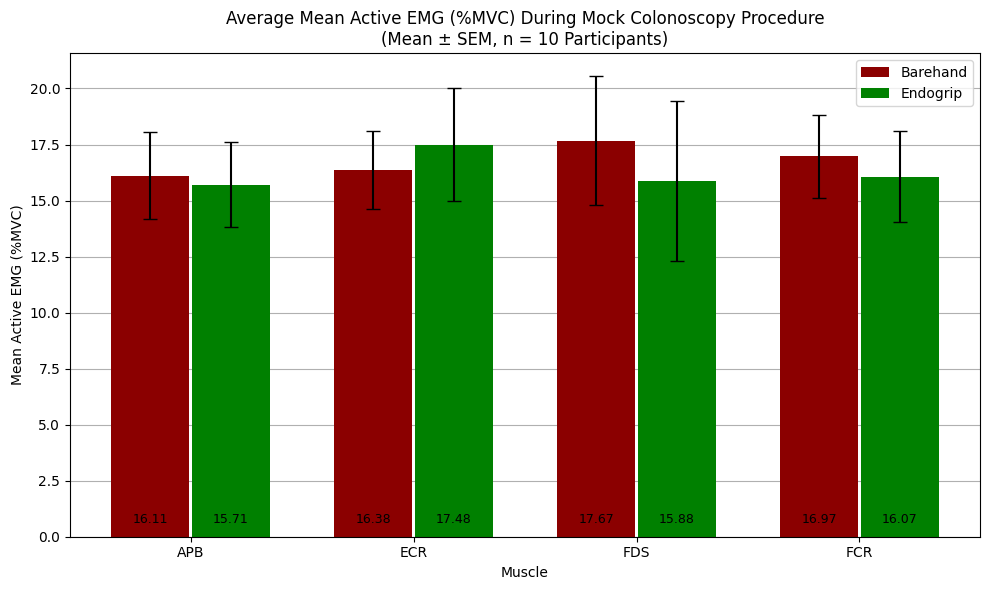

Paired t-test results (Barehand vs. Endogrip for Fatigue Risk):
APB  : p-value: 0.2476, Not significant
ECR  : p-value: 0.0011, Significant
FDS  : p-value: 0.9258, Not significant
FCR  : p-value: 0.2727, Not significant
Percent Difference in Fatigue Risk (Endogrip vs. Barehand):
APB  : -2050.29%
ECR  : 71.53%
FDS  : -6.45%
FCR  : 117.43%


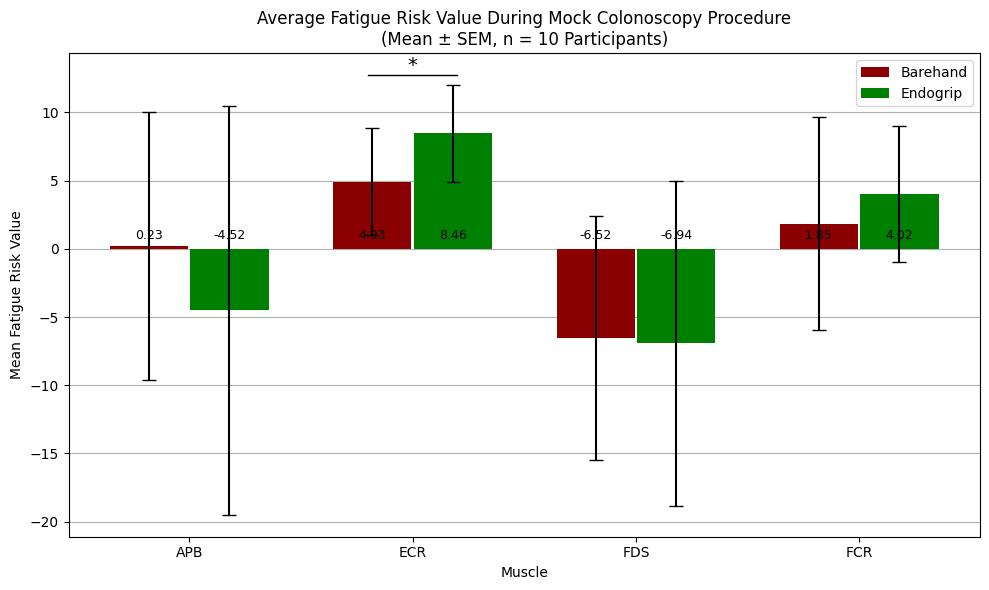

In [ ]:
# Find Mean Active EMG Across All Subjects
BASE_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /"
subjects = [f"Subject_{i}" for i in range(1, 11)]
muscle_labels = ["APB", "ECR", "FDS", "FCR"]
grip_types = ["Barehand", "Endogrip"]

from scipy.stats import ttest_rel

data = []
for subject in subjects:
    subject_path = os.path.join(BASE_DIR, subject, f"mean_active_emg_{subject.lower()}.xlsx")
    if not os.path.exists(subject_path):
        print(f"Missing EMG file for {subject}, skipping...")
        continue

    df = pd.read_excel(subject_path)
    df['Subject'] = subject
    data.append(df)

# Combine all subjects into one DataFrame
all_emg_df = pd.concat(data, ignore_index=True)

# paired t-test and display p-values
p_values = {}
for muscle in muscle_labels:
    barehand_vals = all_emg_df[(all_emg_df['Muscle'] == muscle) & (all_emg_df['Grip Type'] == 'Barehand')].sort_values('Subject')["Mean EMG (%MVC)"].values
    endogrip_vals = all_emg_df[(all_emg_df['Muscle'] == muscle) & (all_emg_df['Grip Type'] == 'Endogrip')].sort_values('Subject')["Mean EMG (%MVC)"].values
    t_stat, p = ttest_rel(barehand_vals, endogrip_vals)
    p_values[muscle] = p

print("Paired t-test results (Barehand vs. Endogrip for Mean Active EMG):")
for muscle, p_val in p_values.items():
    status = "Significant" if p_val < 0.05 else "Not significant"
    print(f"{muscle:<5}: p-value: {p_val:.4f}, {status}")


"""
# Compute mean and std deviation across subjects
summary_df = all_emg_df.groupby(["Grip Type", "Muscle"]).agg(
    Mean_EMG=('Mean EMG (%MVC)', 'mean'),
    Std_EMG=('Mean EMG (%MVC)', 'std')
).reset_index()
"""

# Compute mean and standard error acorss subjects
n_subjects = len(subjects)
summary_df = all_emg_df.groupby(["Grip Type", "Muscle"]).agg(
    Mean_EMG=('Mean EMG (%MVC)', 'mean'),
    SEM_EMG=('Mean EMG (%MVC)', lambda x: x.std(ddof=1) / np.sqrt(n_subjects))
).reset_index()

# percent difference
mean_pivot = summary_df.pivot(index='Muscle', columns='Grip Type', values='Mean_EMG')
percent_diff = ((mean_pivot['Endogrip'] - mean_pivot['Barehand']) / mean_pivot['Barehand']) * 100
print("Percent Difference in Mean EMG (Endogrip vs. Barehand):")
for muscle in muscle_labels:
    diff = percent_diff[muscle]
    print(f"{muscle:<5}: {diff:.2f}%")

x = np.arange(len(muscle_labels))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

for i, grip_type in enumerate(grip_types):
    grip_data = summary_df[summary_df["Grip Type"] == grip_type].copy()
    grip_data = grip_data.set_index("Muscle").loc[muscle_labels].reset_index()

    x_pos = x + (i - 0.5) * (bar_width + 0.01)
    #[Std_EMG] for standard deviation
    #[SEM_EMG] for standard error
    bars = ax.bar(x_pos,grip_data["Mean_EMG"],bar_width,yerr=grip_data["SEM_EMG"] ,capsize=5,label=grip_type,color='darkred' if grip_type == "Barehand" else 'green')

    # Add Labels to Bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2,0.5, f"{height:.2f}", ha='center', va='bottom',fontsize=9,color='black')

"""
# adding p-values above the bar plots
for idx, muscle in enumerate(muscle_labels):
    # Get mean and SEM values
    barehand_mean = summary_df[(summary_df["Grip Type"] == "Barehand") & (summary_df["Muscle"] == muscle)]["Mean_EMG"].values[0]
    barehand_sem  = summary_df[(summary_df["Grip Type"] == "Barehand") & (summary_df["Muscle"] == muscle)]["SEM_EMG"].values[0]

    endogrip_mean = summary_df[(summary_df["Grip Type"] == "Endogrip") & (summary_df["Muscle"] == muscle)]["Mean_EMG"].values[0]
    endogrip_sem  = summary_df[(summary_df["Grip Type"] == "Endogrip") & (summary_df["Muscle"] == muscle)]["SEM_EMG"].values[0]

    # Plot horizontal line for comparison
    y_max = max(barehand_mean + barehand_sem, endogrip_mean + endogrip_sem)
    ax.plot([idx - 0.2, idx + 0.2], [y_max+1, y_max+1], color='black')
    p = p_values[muscle]
    label = "*" if p < 0.05 else f"p = {p:.2f}"
    ax.text(idx, y_max + 1.2, label, ha='center', va='bottom', fontsize=10)
"""

ax.set_xlabel("Muscle")
ax.set_ylabel("Mean Active EMG (%MVC)")
ax.set_title("Average Mean Active EMG (%MVC) During Mock Colonoscopy Procedure\n(Mean ± SEM, n = 10 Participants)")
ax.set_xticks(x)
ax.set_xticklabels(muscle_labels)
ax.legend()
ax.set_axisbelow(True)
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()


fatigue_data = []
for subject in subjects:
    subject_path = os.path.join(BASE_DIR, subject, f"fatigue_risk_data_{subject.lower()}.xlsx")
    if not os.path.exists(subject_path):
        print(f"Missing Fatigue Risk file for {subject}, skipping...")
        continue

    df = pd.read_excel(subject_path)
    df['Subject'] = subject
    fatigue_data.append(df)

# Combine all Fatigue Risk
all_fatigue_df = pd.concat(fatigue_data, ignore_index=True)


"""
# Compute mean and std across subjects
summary_fatigue_df = all_fatigue_df.groupby(["Grip Type", "Muscle"]).agg(Mean_Fatigue=('Fatigue Risk Value', 'mean'),Std_Fatigue=('Fatigue Risk Value', 'std')).reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
"""

# Compute mean and standard error across subjects
summary_fatigue_df = all_fatigue_df.groupby(["Grip Type", "Muscle"]).agg(Mean_Fatigue=('Fatigue Risk Value', 'mean'),SEM_Fatigue=('Fatigue Risk Value', lambda x: x.std(ddof=1) / np.sqrt(n_subjects))).reset_index()
fig, ax = plt.subplots(figsize=(10, 6))

# paired t-test and display p-values
p_values_fatigue = {}
for muscle in muscle_labels:
    barehand_vals_fatigue = all_fatigue_df[(all_fatigue_df['Muscle'] == muscle) & (all_fatigue_df['Grip Type'] == 'Barehand')].sort_values('Subject')["Fatigue Risk Value"].values
    endogrip_vals_fatigue = all_fatigue_df[(all_fatigue_df['Muscle'] == muscle) & (all_fatigue_df['Grip Type'] == 'Endogrip')].sort_values('Subject')["Fatigue Risk Value"].values

    t_stat_fatigue, p_val_fatigue = ttest_rel(barehand_vals_fatigue, endogrip_vals_fatigue)
    p_values_fatigue[muscle] = p_val_fatigue

print("Paired t-test results (Barehand vs. Endogrip for Fatigue Risk):")
for muscle, p_val_fatigue in p_values_fatigue.items():
    status = "Significant" if p_val_fatigue < 0.05 else "Not significant"
    print(f"{muscle:<5}: p-value: {p_val_fatigue:.4f}, {status}")

# label p-value significance on bar plot
for idx, muscle in enumerate(muscle_labels):
    p = p_values_fatigue[muscle]
    if p < 0.05:
        # Get mean and SEM for both grip types
        bh_row = summary_fatigue_df[(summary_fatigue_df["Grip Type"] == "Barehand") & (summary_fatigue_df["Muscle"] == muscle)]
        eg_row = summary_fatigue_df[(summary_fatigue_df["Grip Type"] == "Endogrip") & (summary_fatigue_df["Muscle"] == muscle)]

        bh_val = bh_row["Mean_Fatigue"].values[0]
        eg_val = eg_row["Mean_Fatigue"].values[0]
        bh_sem = bh_row["SEM_Fatigue"].values[0]
        eg_sem = eg_row["SEM_Fatigue"].values[0]

        # Set height just above the taller bar + its error bar
        y_max = max(bh_val + bh_sem, eg_val + eg_sem) + 0.7
        bar_center = x[idx]
        ax.plot([bar_center - 0.2, bar_center + 0.2], [y_max, y_max], color='black', linewidth=1)
        ax.text(bar_center, y_max , "*", ha='center', va='bottom', fontsize=14, color='black')


# percent difference
fatigue_pivot = summary_fatigue_df.pivot(index='Muscle', columns='Grip Type', values='Mean_Fatigue')
percent_diff_fatigue = (((fatigue_pivot['Endogrip']) - (fatigue_pivot['Barehand'])) / np.abs(fatigue_pivot['Barehand'])) * 100
print("Percent Difference in Fatigue Risk (Endogrip vs. Barehand):")
for muscle in muscle_labels:
    diff = percent_diff_fatigue[muscle]
    print(f"{muscle:<5}: {diff:.2f}%")


for i, grip_type in enumerate(grip_types):
    grip_data = summary_fatigue_df[summary_fatigue_df["Grip Type"] == grip_type].copy()
    grip_data = grip_data.set_index("Muscle").loc[muscle_labels].reset_index()

    x_pos = x + (i - 0.5) * (bar_width + 0.01)
    #[Std_Fatigue] for standard deviation
    #[SEM_Fatigue] for standard error
    bars = ax.bar(x_pos,grip_data["Mean_Fatigue"],bar_width,yerr=grip_data["SEM_Fatigue"],capsize=5,label=grip_type,color='darkred' if grip_type == "Barehand" else 'green')

    # Add label near bottom of bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2,0.5,f"{height:.2f}",ha='center',va='bottom',fontsize=9,color='black')

ax.set_xlabel("Muscle")
ax.set_ylabel("Mean Fatigue Risk Value")
ax.set_title("Average Fatigue Risk Value During Mock Colonoscopy Procedure\n(Mean ± SEM, n = 10 Participants)")
ax.set_xticks(x)
ax.set_xticklabels(muscle_labels)
ax.legend()
ax.set_axisbelow(True)
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()


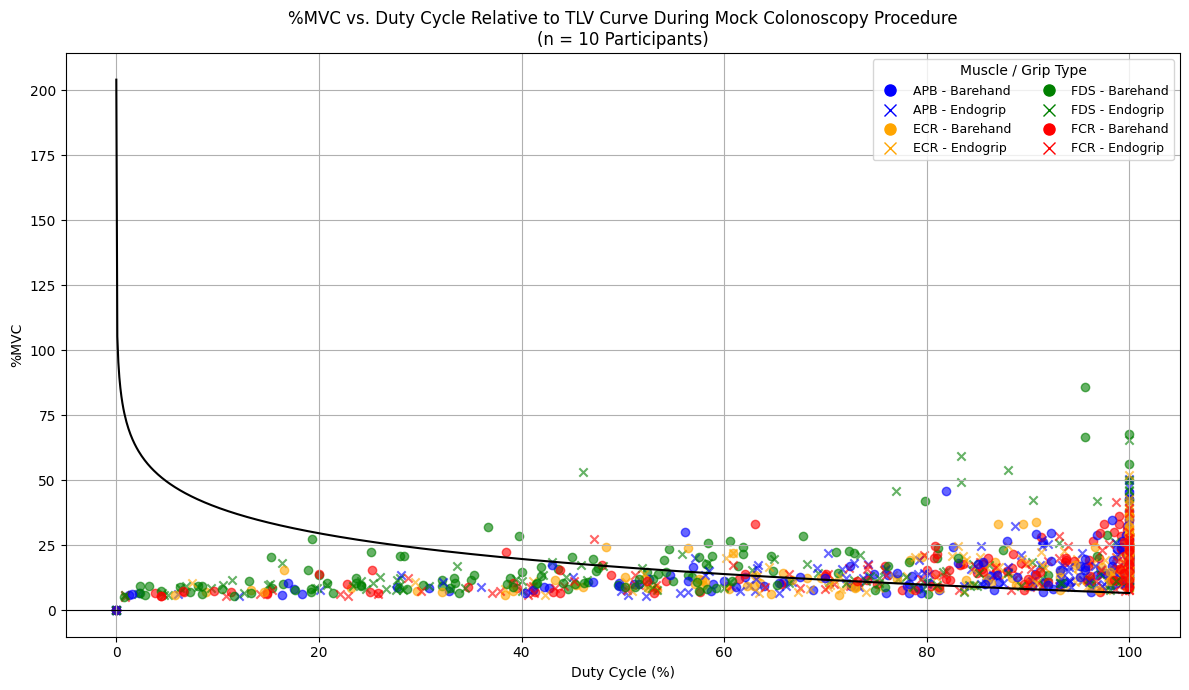

In [ ]:
# PLOT %MVC VS DUTY CYCLE FOR ALL SUBJECTS AGAINST TLV CURVE
BASE_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /"
subjects = [f"Subject_{i}" for i in range(1, 11)]
muscle_labels = ["APB", "ECR", "FDS", "FCR"]
grip_types = ["Barehand", "Endogrip"]

# TLV Curve
DC = np.linspace(0, 100, 1000)
TLV = 100 * (-0.143 * np.log(DC / 100 + 1e-6) + 0.066)

# Plot base
plt.figure(figsize=(12, 7))
plt.plot(DC, TLV, 'k-', label="TLV Curve")

colors = {'APB': 'blue', 'ECR': 'orange', 'FDS': 'green', 'FCR': 'red'}
markers = {'Barehand': 'o', 'Endogrip': 'x'}

for subject in subjects:
    fatigue_path = os.path.join(BASE_DIR, subject, f"fatigue_risk_data_{subject.lower()}.xlsx")
    if not os.path.exists(fatigue_path):
        print(f"Missing file for {subject}, skipping...")
        continue

    df = pd.read_excel(fatigue_path)
    for muscle in muscle_labels:
        for grip in grip_types:
            subset = df[(df["Muscle"] == muscle) & (df["Grip Type"] == grip)]

            plt.scatter(
                subset["Duty Cycle"],
                subset["Fatigue Risk Value"] + np.interp(subset["Duty Cycle"]/100, DC/100, TLV),
                label=f"{muscle} - {grip}", color=colors[muscle],marker=markers[grip],alpha=0.6)

plt.xlabel("Duty Cycle (%)")
plt.ylabel("%MVC")
plt.title("%MVC vs. Duty Cycle Relative to TLV Curve During Mock Colonoscopy Procedure\n(n = 10 Participants)")
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

from matplotlib.lines import Line2D
custom_legend = []
for muscle, color in colors.items():
    custom_legend.append(Line2D([0], [0], marker='o', color=color, label=f'{muscle} - Barehand', linestyle='None', markersize=8))
    custom_legend.append(Line2D([0], [0], marker='x', color=color, label=f'{muscle} - Endogrip',linestyle='None', markersize=8))
plt.legend(handles=custom_legend, title="Muscle / Grip Type", fontsize=9, ncol=2)

plt.grid(True)
plt.tight_layout()
plt.show()



# FIXED LOAD TEST AND LOAD CELL DATA

2.703


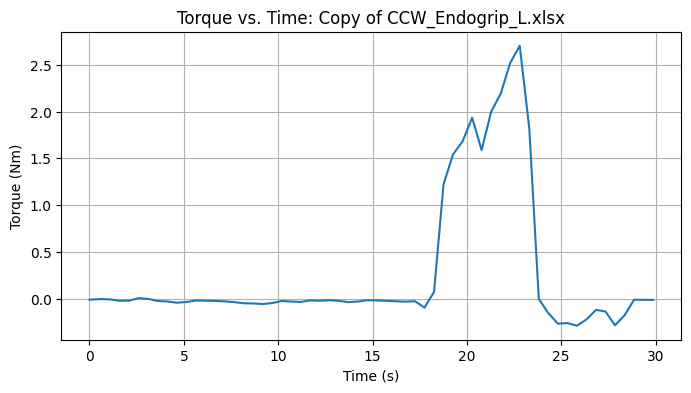

2.037


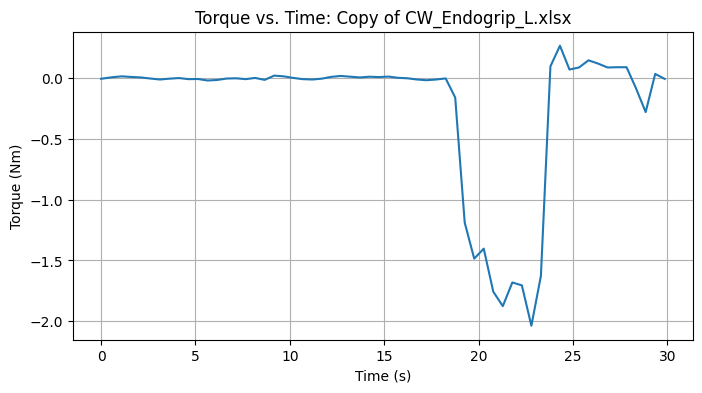

In [ ]:
# LOAD CELL
import os
import pandas as pd
import matplotlib.pyplot as plt

folder_path = '/content/drive/Shareddrives/EndoGrip/Inesh/MVC_L/Load_Cell/'
xlsx_files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]

# Loop through each file, read data, process, and plot
for file in xlsx_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path, header=None, names=['Time', 'Torque (Nm)'])

    # Convert columns to numeric in case there are non-numeric values
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df['Torque (Nm)'] = pd.to_numeric(df['Torque (Nm)'], errors='coerce')
    print(max(abs((df['Torque (Nm)']))))
    df.dropna(inplace=True)

    # Convert Time from milliseconds to seconds
    df['Time'] = df['Time'] / 1000

    plt.figure(figsize=(8, 4))
    # Plot torque vs time
    plt.plot(df['Time'], df['Torque (Nm)'], linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Torque (Nm)')
    plt.title(f'Torque vs. Time: {file}')
    plt.grid(True)
    plt.show()


In [ ]:
# MEAN ACTIVE EMG ACROSS ALL SUBJECTS
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


BASE_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_1"
FIXED_LOAD_FOLDERS = {
    "before": ["Fixed Load Test BEFORE/CW", "Fixed Load Test BEFORE/CCW"],
    "after": ["Fixed Load Test AFTER/CW", "Fixed Load Test AFTER/CCW"]
}
columns = [1, 3, 5, 7]
muscle_labels = ["APB", "ECR", "FDS", "FCR"]
column_names = {1: 'APB', 3: 'ECR', 5: 'FDS', 7: 'FCR'}
time_windows = [(10, 30), (30, 50), (50, 70)]

def process_fixed_load(folder_list, save_filename):
    results = []

    for folder in folder_list:
        DATA_CALIBRATE_DIR = os.path.join(BASE_DIR, folder)

        for file in os.listdir(DATA_CALIBRATE_DIR):
            if file.endswith('.csv'):
                print(f"Processing file: {file}")
                try:
                    csv_path = os.path.join(DATA_CALIBRATE_DIR, file)
                    csv_file = CSVFile(csv_path)
                    csv_file.parse_header()

                    for col_num in columns:
                        col = csv_file.data[:, col_num] - np.mean(csv_file.data[:, col_num])
                        fs = csv_file.get_column_frequency(col_num)
                        nq = fs / 2
                        filtered_signal = lpf(10, fs, np.abs(lpf(450, nq, notch_filter(fs, col))))

                        # Moving window
                        window_size = round(fs * 0.125)
                        step_size = round(fs * 0.0625)

                        mean_data = np.array([
                            np.mean(filtered_signal[i:i + window_size])
                            for i in range(0, len(filtered_signal) - window_size + 1, step_size)
                        ])

                        MVC_percent = (mean_data / max_values[col_num]) * 100
                        time_axis = np.arange(len(MVC_percent)) * step_size / fs
                        muscle = column_names[col_num]

                        for (start, end) in time_windows:
                            indices = (time_axis >= start) & (time_axis <= end)
                            if np.any(indices):
                                window_vals = MVC_percent[indices]
                                window_mean = np.mean(window_vals)
                                window_sem = np.std(window_vals, ddof=1) / np.sqrt(len(window_vals))

                                results.append({
                                    "File": file,
                                    "Rotation": "CCW" if "CCW" in folder else "CW",
                                    "Muscle": muscle,
                                    "Time Window": f"{start}-{end}s",
                                    "Mean %MVC": round(window_mean, 2),
                                    "SEM %MVC": round(window_sem, 2)
                                })
                            else:
                                results.append({
                                    "File": file,
                                    "Rotation": "CCW" if "CCW" in folder else "CW",
                                    "Muscle": muscle,
                                    "Time Window": f"{start}-{end}s",
                                    "Mean %MVC": np.nan,
                                    "SEM %MVC": np.nan
                                })
                except Exception as e:
                    print(f"Error processing file {file}: {e}")

    df_result = pd.DataFrame(results)
    save_path = os.path.join(BASE_DIR, save_filename)
    df_result.to_csv(save_path, index=False)
    print(f"\nSaved results to {save_path}")

    # Plot partial table
    summary = df_result.groupby("Muscle").agg(
        Mean_Total=("Mean %MVC", "mean"),
        SEM_Total=("Mean %MVC", lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
    ).reset_index()
    print("\nSummary (Mean ± SEM) across all time windows:")
    print(summary)

process_fixed_load(FIXED_LOAD_FOLDERS["before"], "fixed_load_before_subject_1.csv")
process_fixed_load(FIXED_LOAD_FOLDERS["after"], "fixed_load_after_subject_1.csv")

Processing file: Barehand.csv
Processing file: Endogrip.csv
Processing file: Barehand.csv
Processing file: Endogrip.csv

Saved results to /content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_1/fixed_load_before_subject_1.csv

Summary (Mean ± SEM) across all time windows:
  Muscle  Mean_Total  SEM_Total
0    APB   44.155833   3.044307
1    ECR   44.077500   4.821346
2    FCR   48.014167   4.788632
3    FDS   19.656667   4.108606
Processing file: Barehand.csv
Processing file: Endogrip.csv
Processing file: Barehand.csv
Processing file: Endogrip.csv

Saved results to /content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_1/fixed_load_after_subject_1.csv

Summary (Mean ± SEM) across all time windows:
  Muscle  Mean_Total  SEM_Total
0    APB   38.971667   4.657210
1    ECR   43.379167   5.869233
2    FCR   44.619167   5.479810
3    FDS   29.615833   4.641867



--- P-Values for 60% MVC CW Before ---
APB  : p = 0.0695
ECR  : p = 0.0299
FDS  : p = 0.8205
FCR  : p = 0.3876

--- Percent Differences (%): 60% MVC CW Before ---
APB  : -22.65%
ECR  : -27.41%
FDS  : +200.30%
FCR  : -15.23%

--- P-Values for 45% MVC CW Before ---
APB  : p = 0.0380
ECR  : p = 0.0271
FDS  : p = 0.9978
FCR  : p = 0.6471

--- Percent Differences (%): 45% MVC CW Before ---
APB  : -21.54%
ECR  : -21.95%
FDS  : +186.75%
FCR  : -6.71%

--- P-Values for 30% MVC CW Before ---
APB  : p = 0.1948
ECR  : p = 0.1514
FDS  : p = 0.0761
FCR  : p = 0.6024

--- Percent Differences (%): 30% MVC CW Before ---
APB  : -12.88%
ECR  : -8.70%
FDS  : +273.37%
FCR  : -0.32%


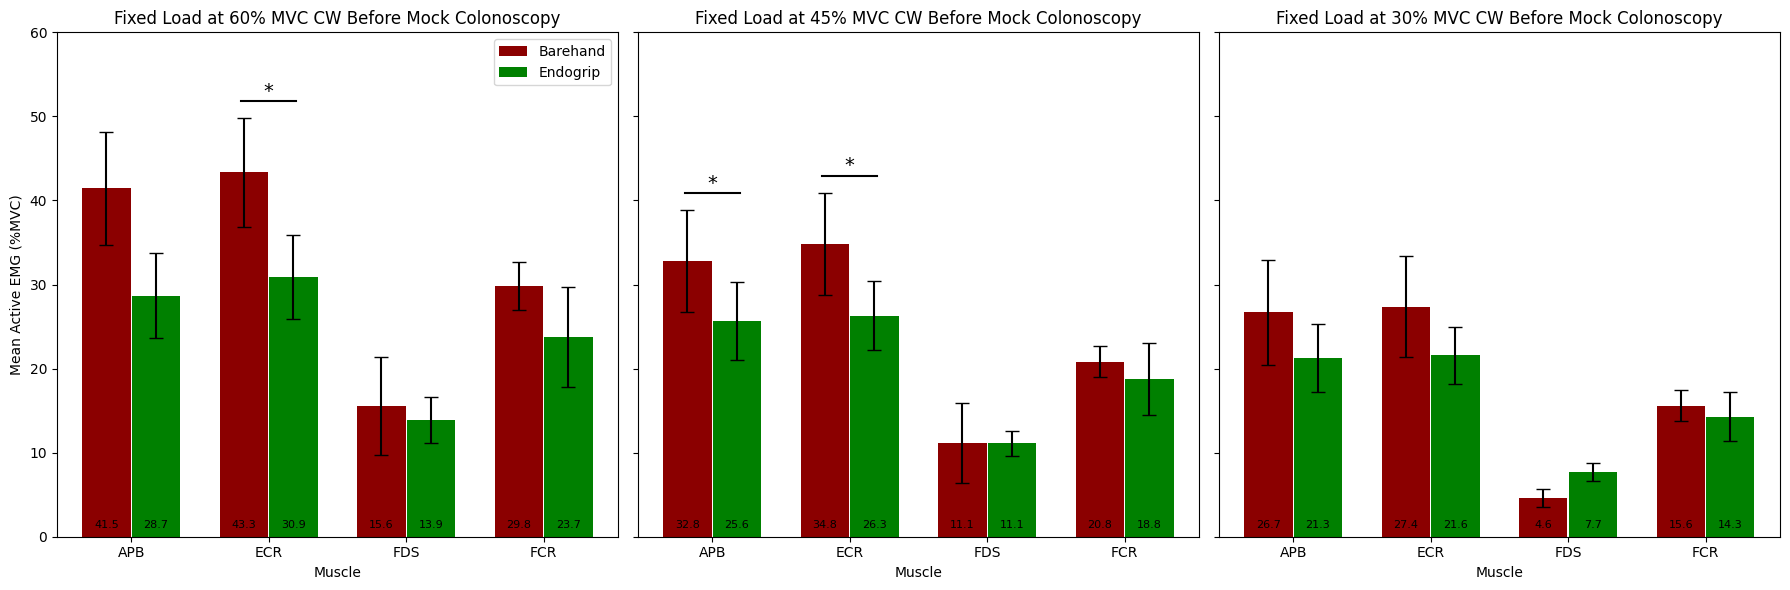


--- P-Values for 60% MVC CCW Before ---
APB  : p = 0.0271
ECR  : p = 0.0342
FDS  : p = 0.6070
FCR  : p = 0.4351

--- Percent Differences (%): 60% MVC CCW Before ---
APB  : +75.48%
ECR  : +49.38%
FDS  : +91.91%
FCR  : -4.47%

--- P-Values for 45% MVC CCW Before ---
APB  : p = 0.0176
ECR  : p = 0.0055
FDS  : p = 0.0596
FCR  : p = 0.1997

--- Percent Differences (%): 45% MVC CCW Before ---
APB  : +95.05%
ECR  : +65.26%
FDS  : +128.32%
FCR  : +11.75%

--- P-Values for 30% MVC CCW Before ---
APB  : p = 0.0048
ECR  : p = 0.0109
FDS  : p = 0.0249
FCR  : p = 0.0101

--- Percent Differences (%): 30% MVC CCW Before ---
APB  : +90.72%
ECR  : +72.60%
FDS  : +176.84%
FCR  : +37.61%


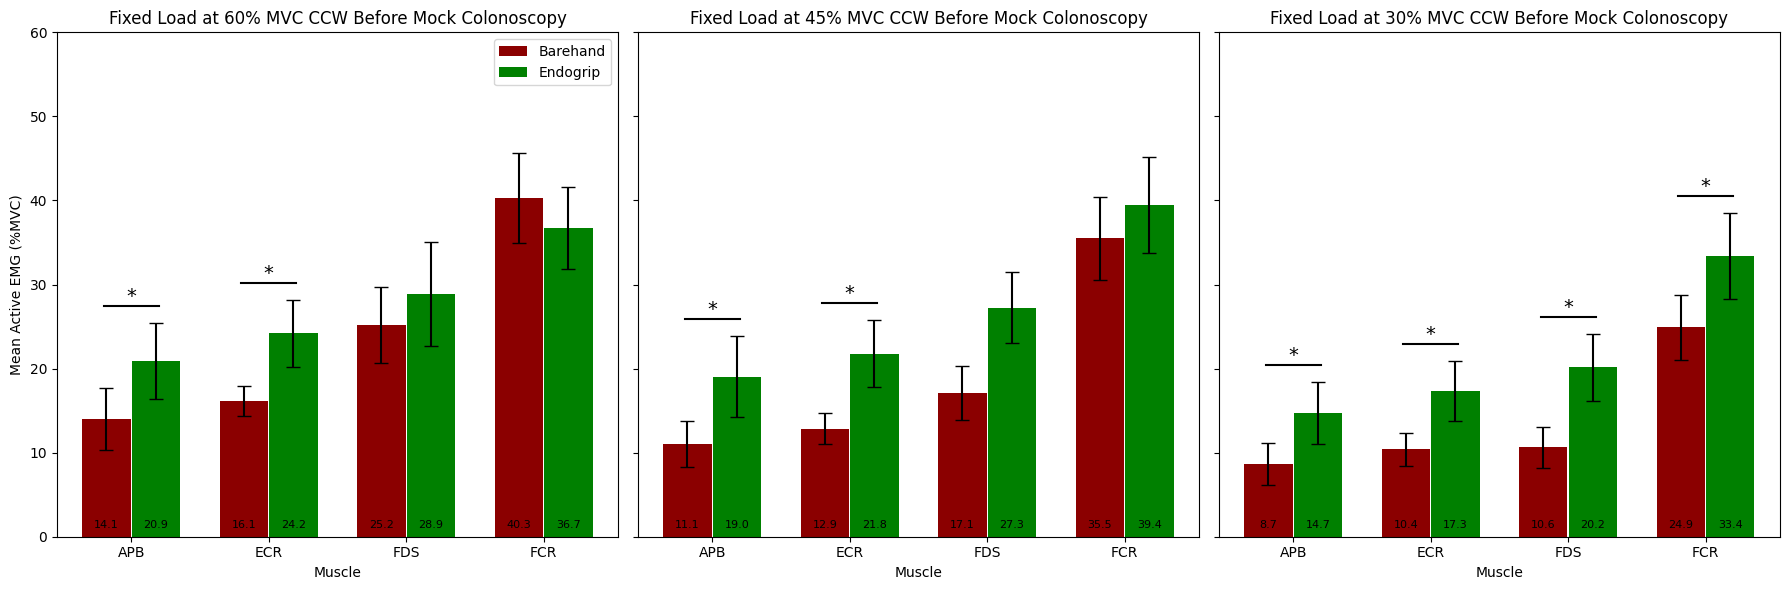


--- P-Values for 60% MVC CW After ---
APB  : p = 0.0390
ECR  : p = 0.1303
FDS  : p = 0.0655
FCR  : p = 0.1832

--- Percent Differences (%): 60% MVC CW After ---
APB  : -29.31%
ECR  : -13.53%
FDS  : +296.31%
FCR  : +40.76%

--- P-Values for 45% MVC CW After ---
APB  : p = 0.1318
ECR  : p = 0.1991
FDS  : p = 0.0555
FCR  : p = 0.1835

--- Percent Differences (%): 45% MVC CW After ---
APB  : -20.50%
ECR  : -13.30%
FDS  : +419.37%
FCR  : +51.29%

--- P-Values for 30% MVC CW After ---
APB  : p = 0.0207
ECR  : p = 0.0252
FDS  : p = 0.0504
FCR  : p = 0.2281

--- Percent Differences (%): 30% MVC CW After ---
APB  : -27.37%
ECR  : -19.60%
FDS  : +312.77%
FCR  : +33.19%


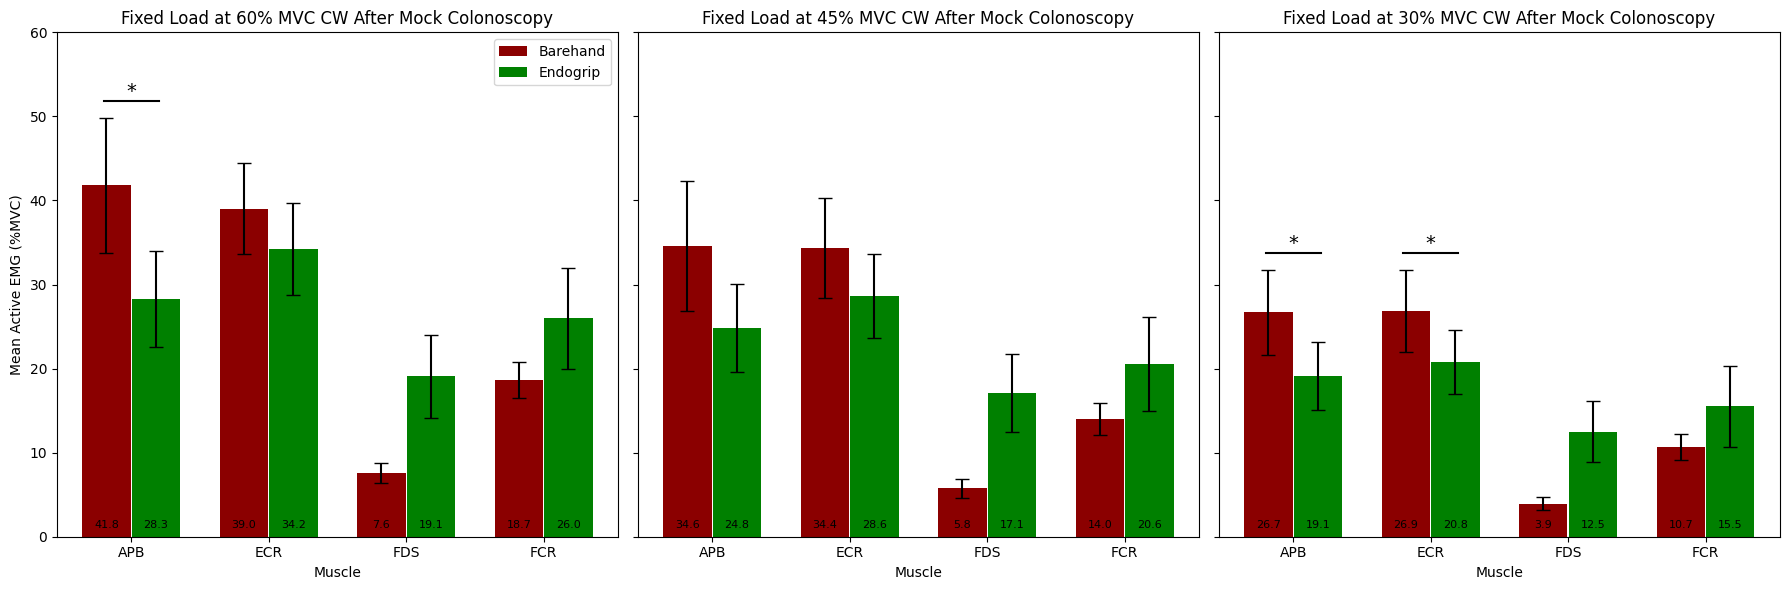


--- P-Values for 60% MVC CCW After ---
APB  : p = 0.0157
ECR  : p = 0.0269
FDS  : p = 0.2885
FCR  : p = 0.6245

--- Percent Differences (%): 60% MVC CCW After ---
APB  : +114.77%
ECR  : +70.95%
FDS  : +226.78%
FCR  : +17.40%

--- P-Values for 45% MVC CCW After ---
APB  : p = 0.0041
ECR  : p = 0.0180
FDS  : p = 0.0033
FCR  : p = 0.1149

--- Percent Differences (%): 45% MVC CCW After ---
APB  : +145.92%
ECR  : +102.76%
FDS  : +211.03%
FCR  : +50.42%

--- P-Values for 30% MVC CCW After ---
APB  : p = 0.0034
ECR  : p = 0.0099
FDS  : p = 0.0008
FCR  : p = 0.0330

--- Percent Differences (%): 30% MVC CCW After ---
APB  : +209.08%
ECR  : +140.91%
FDS  : +254.43%
FCR  : +89.02%


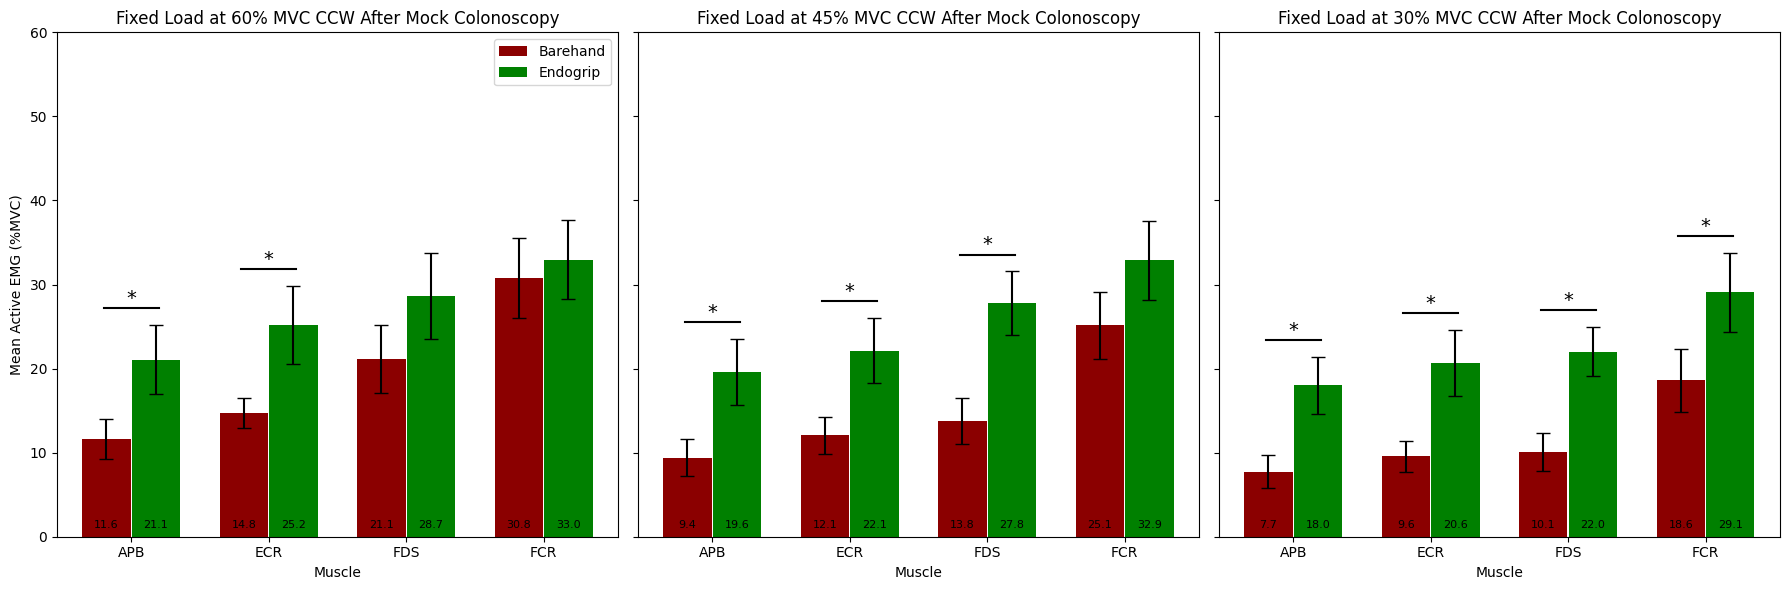


Summary Table of Mean Percent Differences (%):
  Time Rotation MVC Level Muscle  Mean Percent Difference
Before       CW   60% MVC    APB                   -22.65
Before       CW   60% MVC    ECR                   -27.41
Before       CW   60% MVC    FDS                   200.30
Before       CW   60% MVC    FCR                   -15.23
Before       CW   45% MVC    APB                   -21.54
Before       CW   45% MVC    ECR                   -21.95
Before       CW   45% MVC    FDS                   186.75
Before       CW   45% MVC    FCR                    -6.71
Before       CW   30% MVC    APB                   -12.88
Before       CW   30% MVC    ECR                    -8.70
Before       CW   30% MVC    FDS                   273.37
Before       CW   30% MVC    FCR                    -0.32
Before      CCW   60% MVC    APB                    75.48
Before      CCW   60% MVC    ECR                    49.38
Before      CCW   60% MVC    FDS                    91.91
Before      CCW   60% MV

In [ ]:
# MEAN ACTIVE EMG ACROSS ALL SUBJECTS
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

BASE_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /"
subjects = [f"Subject_{i}" for i in range(1, 11)]
muscles = ["APB", "ECR", "FDS", "FCR"]
time_windows = {
    "10-30s": "60% MVC",
    "30-50s": "45% MVC",
    "50-70s": "30% MVC"
}
grip_colors = {"Barehand": "darkred", "Endogrip": "green"}
rotations = ["CW", "CCW"]

percent_diff_summary = []

percent_diff_summary = []

def plot_fixed_load(df_all, time_point_label):
    for rotation in rotations:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
        bar_width = 0.35
        x = np.arange(len(muscles))

        for ax, (window, mvc_label) in zip(axes, time_windows.items()):
            df_window = df_all[(df_all["Time Window"] == window) & (df_all["Rotation"] == rotation)]

            print(f"\n--- P-Values for {mvc_label} {rotation} {time_point_label} ---")
            p_values = {}

            # Plot bars with standard error
            for i, grip in enumerate(["Barehand", "Endogrip"]):
                df_grip = df_window[df_window["Grip Type"] == grip]
                means = df_grip.groupby("Muscle")["Mean %MVC"].mean().reindex(muscles)
                sems = df_grip.groupby("Muscle")["Mean %MVC"].sem().reindex(muscles)

                x_pos = x + (i - 0.5) * (bar_width + 0.01)
                ax.bar(x_pos, means, bar_width, yerr=sems, capsize=5,
                       label=grip if ax == axes[0] else "",
                       color=grip_colors[grip])

                for j, val in enumerate(means):
                    if not np.isnan(val):
                        ax.text(x_pos[j], 1, f"{val:.1f}", ha='center', fontsize=8)

            # Paired t-tests
            for idx, muscle in enumerate(muscles):
                bh_vals = df_window[(df_window["Grip Type"] == "Barehand") & (df_window["Muscle"] == muscle)].sort_values("Subject")["Mean %MVC"]
                eg_vals = df_window[(df_window["Grip Type"] == "Endogrip") & (df_window["Muscle"] == muscle)].sort_values("Subject")["Mean %MVC"]

                if len(bh_vals) == len(eg_vals) and len(bh_vals) > 1:
                    t_stat, p = ttest_rel(bh_vals.values, eg_vals.values)
                    p_values[muscle] = p
                    print(f"{muscle:<5}: p = {p:.4f}")

                    if p < 0.05:
                        bh_mean = bh_vals.mean()
                        eg_mean = eg_vals.mean()
                        bh_sem = bh_vals.sem()
                        eg_sem = eg_vals.sem()
                        y = max(bh_mean + bh_sem, eg_mean + eg_sem) + 2
                        ax.plot([idx - 0.2, idx + 0.2], [y, y], color='black')
                        ax.text(idx, y + 0.5, "*", ha='center', fontsize=14, color='black')

            ax.set_title(f"Fixed Load at {mvc_label} {rotation} {time_point_label} Mock Colonoscopy")
            ax.set_xticks(x)
            ax.set_xticklabels(muscles)
            ax.set_xlabel("Muscle")
            ax.set_ylim(0, 60)

            # percent difference
            print(f"\n--- Percent Differences (%): {mvc_label} {rotation} {time_point_label} ---")
            for muscle in muscles:
              bh_vals = df_window[(df_window["Grip Type"] == "Barehand") & (df_window["Muscle"] == muscle)].sort_values("Subject")["Mean %MVC"]
              eg_vals = df_window[(df_window["Grip Type"] == "Endogrip") & (df_window["Muscle"] == muscle)].sort_values("Subject")["Mean %MVC"]

              if len(bh_vals) == len(eg_vals) and len(bh_vals) > 1:
                percent_diff = ((eg_vals.values - bh_vals.values) / bh_vals.values) * 100
                mean_diff = np.mean(percent_diff)
                print(f"{muscle:<5}: {mean_diff:+.2f}%")

                        # check for duplicates
                entry = {"Time": time_point_label,"Rotation": rotation,"MVC Level": mvc_label,"Muscle": muscle,"Mean Percent Difference": round(mean_diff, 2)}
                if entry not in percent_diff_summary:
                  percent_diff_summary.append(entry)

        axes[0].set_ylabel("Mean Active EMG (%MVC)")
        axes[0].legend()
        plt.tight_layout()
        plt.show()

# Load and plot for BEFORE
df_before = load_fixed_load_data("before")
if not df_before.empty:
    plot_fixed_load(df_before, "Before")

# Load and plot for AFTER
df_after = load_fixed_load_data("after")
if not df_after.empty:
    plot_fixed_load(df_after, "After")

# Display final table of percent differences
if percent_diff_summary:
    percent_diff_df = pd.DataFrame(percent_diff_summary)
    print("\nSummary Table of Mean Percent Differences (%):")
    print(percent_diff_df.to_string(index=False))



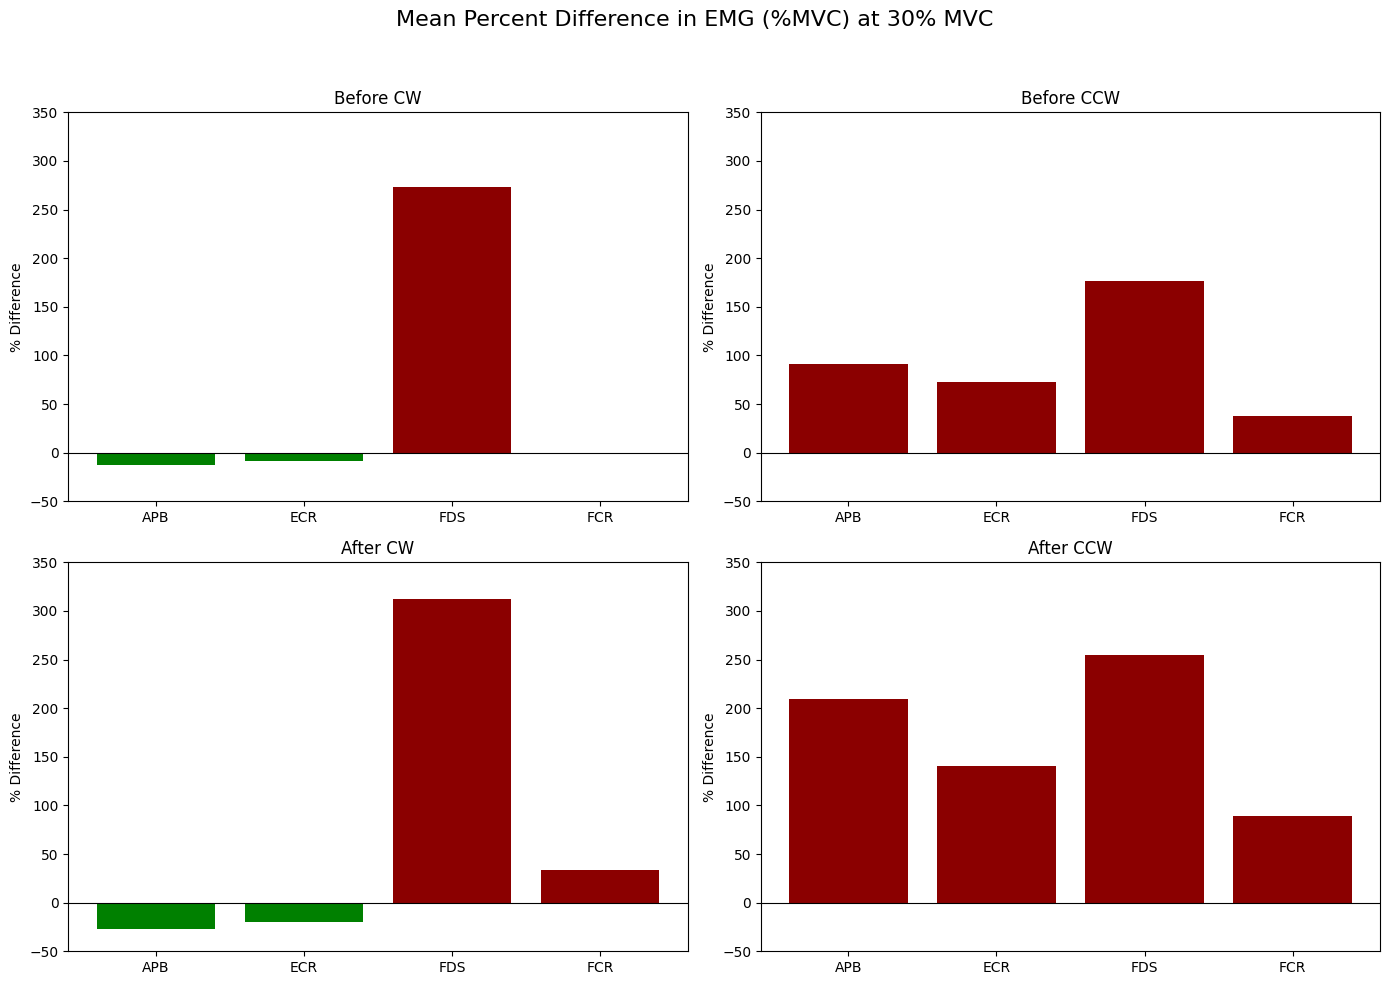

In [ ]:
plot_data = pd.DataFrame({
    "Time": ["Before"] * 8 + ["After"] * 8,
    "Rotation": ["CW"] * 4 + ["CCW"] * 4 + ["CW"] * 4 + ["CCW"] * 4,
    "MVC Level": ["30% MVC"] * 16,
    "Muscle": ["APB", "ECR", "FDS", "FCR"] * 4,
    "Mean Percent Difference": [
        -12.88, -8.70, 273.37, -0.32,
         90.72, 72.60, 176.84, 37.61,
        -27.37, -19.60, 312.77, 33.19,
        209.08, 140.91, 254.43, 89.02
    ]
})

# Create 2x2 subplots for each condition
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
conditions = [("Before", "CW"), ("Before", "CCW"), ("After", "CW"), ("After", "CCW")]
titles = ["Before CW", "Before CCW", "After CW", "After CCW"]

for i, (time, rotation) in enumerate(conditions):
    ax = axes[i]
    df_subset = plot_data[(plot_data["Time"] == time) & (plot_data["Rotation"] == rotation)]
    colors = df_subset["Mean Percent Difference"].apply(lambda x: "green" if x < 0 else "darkred")
    ax.bar(df_subset["Muscle"], df_subset["Mean Percent Difference"], color=colors)
    ax.set_title(titles[i])
    ax.set_ylim(-50, 350)
    ax.set_ylabel("% Difference")
    ax.axhline(0, color='black', linewidth=0.8)

plt.suptitle("Mean Percent Difference in EMG (%MVC) at 30% MVC", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import statsmodels.formula.api as smf
# Convert categorical
df_anova_input["Subject"] = df_anova_input["Subject"].astype("category")
df_anova_input["Grip"] = df_anova_input["Grip Type"].astype("category")
df_anova_input["Rotation"] = df_anova_input["Rotation"].astype("category")
df_anova_input["Muscle"] = df_anova_input["Muscle"].astype("category")

# Fit 3-way factorial ANOVA model with subject fixed effect
model = smf.ols(
    "Q('Mean %MVC') ~ (Grip) * (Rotation) * (Muscle) + (Subject)",
    data=df_anova_input
).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                            sum_sq     df          F        PR(>F)
Grip                    346.594530    3.0   1.311243  2.728947e-01
Rotation                 92.418376    1.0   1.048917  3.075884e-01
Muscle                 2336.877217    3.0   8.840916  2.159140e-05
Subject                8414.678012    9.0  10.611521  2.488290e-12
Grip:Rotation          1331.497948    3.0   5.037347  2.434544e-03
Grip:Muscle            1228.577403    9.0   1.549325  2.046965e-01
Rotation:Muscle        7196.630859    3.0  27.226424  7.810175e-14
Grip:Rotation:Muscle    642.904645    9.0   0.810749  6.071004e-01
Residual              11894.635509  135.0        NaN           NaN


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 3
  warnings.warn('covariance of constraints does not have full '


# MVC Test: Analyze Load Cell Data and Normalize MVC EMG

In [ ]:
import os
import numpy as np
import pandas as pd
import re

# Define paths
DATA_CALIBRATE_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_1/MVC/"
OUTPUT_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_1/Filtered_EMG_Output/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

trial_to_direction = {
    23: "CW",
    24: "CCW",
    25: "CW",
    26: "CCW",
    27: "CW",
    28: "CCW",
    29: "CW",
    30: "CCW",
    31: "Special"  # Dynanometer
}

trial_to_filename = {
    23: "CW Barehand Torque",
    24: "CCW Barehand Torque",
    25: "CW Endogrip (S) Torque",
    26: "CCW Endogrip (S) Torque",
    27: "CW Endogrip (M) Torque",
    28: "CCW Endogrip (M) Torque",
    29: "CW Endogrip (L) Torque",
    30: "CCW Endogrip (L) Torque",
    31: "Dynanometer"
}


# Initialize global max dictionary for each muscle
muscle_max_global = {"APB": 0.0, "ECR": 0.0, "FDS": 0.0, "FCR": 0.0}
col_to_muscle = {1: "APB", 3: "ECR", 5: "FDS", 7: "FCR"}

def extract_trial_number(filename):
    match = re.search(r"Trial[_\s]?(\d+)", filename, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Find global max per muscle across all MVC files
for file in os.listdir(DATA_CALIBRATE_DIR):
    if not file.endswith(".csv"):
        continue

    trial_num = extract_trial_number(file)
    if trial_num is None or trial_num not in trial_to_direction:
        print(f"Skipping file (Trial number not recognized): {file}")
        continue

    if trial_to_direction[trial_num] == "Special":
        print(f"Skipping file (Dynamometer): {file}")
        continue

    print(f"Finding max values in file: {file} (Trial {trial_num})")
    csv_file = CSVFile(os.path.join(DATA_CALIBRATE_DIR, file))
    csv_file.parse_header()

    for col_num in [1, 3, 5, 7]:
        fs = csv_file.get_column_frequency(col_num)
        nq = fs / 2
        signal = csv_file.data[:, col_num]
        signal = signal - np.mean(signal)

        notch_filtered = notch_filter(fs, signal)
        bandpassed = lpf(450, nq, notch_filtered)
        rectified = np.abs(bandpassed)
        linear_envelope = lpf(10, fs, rectified)
        smoothed = movmean(linear_envelope, round(fs * 0.1))

        muscle = col_to_muscle[col_num]
        current_max = np.max(smoothed)

        if current_max > muscle_max_global[muscle]:
            muscle_max_global[muscle] = current_max

# Print global max per muscle
print("\nGLOBAL MUSCLE MAX VALUES")
for muscle, max_val in muscle_max_global.items():
    print(f"{muscle}: {max_val}")

# Normalize and save each trial using global max
for file in os.listdir(DATA_CALIBRATE_DIR):
    if not file.endswith(".csv"):
        continue

    trial_num = extract_trial_number(file)
    if trial_num is None or trial_num not in trial_to_direction:
        print(f"Skipping file (Trial number not recognized): {file}")
        continue

    if trial_to_direction[trial_num] == "Special":
        continue

    print(f"\nProcessing and normalizing file: {file} (Trial {trial_num})")
    csv_file = CSVFile(os.path.join(DATA_CALIBRATE_DIR, file))
    csv_file.parse_header()

    filtered_data_dict = {}

    for col_num in [1, 3, 5, 7]:
        fs = csv_file.get_column_frequency(col_num)
        nq = fs / 2
        signal = csv_file.data[:, col_num]
        signal = signal - np.mean(signal)

        notch_filtered = notch_filter(fs, signal)
        bandpassed = lpf(450, nq, notch_filtered)
        rectified = np.abs(bandpassed)
        linear_envelope = lpf(10, fs, rectified)
        smoothed = movmean(linear_envelope, round(fs * 0.1))

        muscle = col_to_muscle[col_num]
        normalized_signal = smoothed / muscle_max_global[muscle]
        filtered_data_dict[muscle] = normalized_signal

    if trial_num in trial_to_filename:
      custom_name = trial_to_filename[trial_num] + ".csv"
    else:
      custom_name = file.replace(".csv", "_filtered.csv")

    # Save filtered + normalized EMG data
    output_path = os.path.join(OUTPUT_DIR, custom_name)
    df = pd.DataFrame(filtered_data_dict)
    df.to_csv(output_path, index=False)

    # Print muscle names and file path
    muscles_in_file = ', '.join(filtered_data_dict.keys())
    print(f"Saved normalized filtered EMG to {output_path} | Muscles: {muscles_in_file}")



Skipping file (Dynamometer): Trial_31.csv
Finding max values in file: Trial_30.csv (Trial 30)
Finding max values in file: Trial_29.csv (Trial 29)
Finding max values in file: Trial_28.csv (Trial 28)
Finding max values in file: Trial_27.csv (Trial 27)
Finding max values in file: Trial_26.csv (Trial 26)
Finding max values in file: Trial_25.csv (Trial 25)
Finding max values in file: Trial_24.csv (Trial 24)
Finding max values in file: Trial_23.csv (Trial 23)

GLOBAL MUSCLE MAX VALUES
APB: 0.05612603855218104
ECR: 0.13159049549478583
FDS: 0.7331683417476991
FCR: 0.12296030709455101

Processing and normalizing file: Trial_30.csv (Trial 30)
Saved normalized filtered EMG to /content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_1/Filtered_EMG_Output/CCW Endogrip (L) Torque.csv | Muscles: APB, ECR, FDS, FCR

Processing and normalizing file: Trial_29.csv (Trial 29)
Saved normalized filtered EMG to /content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing 

In [ ]:
# GLOBAL MAX TO NORMALIZE MVC
DATA_CALIBRATE_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_10/MVC/"
OUTPUT_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_10/Filtered_EMG_Output/"

trials = {
    'CW Barehand': 'Trial_5.csv',
    'CCW Barehand': 'Trial_6.csv',
    'CW Small': 'Trial_7.csv',
    'CCW Small': 'Trial_8.csv',
    'CW Medium': 'Trial_9.csv',
    'CCW Medium': 'Trial_10.csv',
    'CW Large': 'Trial_11.csv',
    'CCW Large': 'Trial_12.csv',
}

file_to_rotation = {}
for key, file_name in trials.items():
    if 'CCW' in key:
        file_to_rotation[file_name] = 'CCW'
    elif 'CW' in key:
        file_to_rotation[file_name] = 'CW'

# Output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Find Global Max
global_max_cw = 0.0
global_max_ccw = 0.0

for file in os.listdir(DATA_CALIBRATE_DIR):
    if not file.endswith(".csv"):
        continue

    if file not in file_to_rotation:
        print(f"Skipping unknown file (not in trials dictionary): {file}")
        continue

    rotation = file_to_rotation[file]
    print(f"Finding max in file: {file} | Rotation: {rotation}")

    csv_file = CSVFile(os.path.join(DATA_CALIBRATE_DIR, file))
    csv_file.parse_header()

    for col_num in range(1, 8, 2):  # Columns 1, 3, 5, 7
        fs = csv_file.get_column_frequency(col_num)
        nq = fs / 2
        col = csv_file.data[:, col_num]
        col = col - np.mean(col)

        notch_filtered_col = notch_filter(fs, col)
        bpf_filtered_col = lpf(450, nq, notch_filtered_col)

        bpf_filtered_col_abs = np.abs(bpf_filtered_col)
        lpf_filtered_col = lpf(10, fs, bpf_filtered_col_abs)

        WINDOW_SIZE = 0.1
        window_range = round(fs * WINDOW_SIZE)
        mean_data = movmean(lpf_filtered_col, window_range)

        current_max = np.max(mean_data)

        if rotation == "CW" and current_max > global_max_cw:
            global_max_cw = current_max
        elif rotation == "CCW" and current_max > global_max_ccw:
            global_max_ccw = current_max

print("\nGLOBAL MAXIMUM EMG VALUE FOUND FOR CW:", global_max_cw)
print("GLOBAL MAXIMUM EMG VALUE FOUND FOR CCW:", global_max_ccw)

# Normalize
for file in os.listdir(DATA_CALIBRATE_DIR):
    if not file.endswith(".csv"):
        continue

    if file not in file_to_rotation:
        print(f"Skipping unknown file (not in trials dictionary): {file}")
        continue

    rotation = file_to_rotation[file]
    norm_factor = global_max_cw if rotation == "CW" else global_max_ccw
    print(f"\nNormalizing and saving file: {file} | Rotation: {rotation}")

    csv_file = CSVFile(os.path.join(DATA_CALIBRATE_DIR, file))
    csv_file.parse_header()

    filtered_data_dict = {}

    for col_num in range(1, 8, 2):  # Columns 1, 3, 5, 7
        fs = csv_file.get_column_frequency(col_num)
        nq = fs / 2
        col = csv_file.data[:, col_num]
        col = col - np.mean(col)

        notch_filtered_col = notch_filter(fs, col)
        bpf_filtered_col = lpf(450, nq, notch_filtered_col)

        bpf_filtered_col_abs = np.abs(bpf_filtered_col)
        lpf_filtered_col = lpf(10, fs, bpf_filtered_col_abs)

        WINDOW_SIZE = 0.1
        window_range = round(fs * WINDOW_SIZE)
        mean_data = movmean(lpf_filtered_col, window_range)

        # Normalize by correct CW or CCW global max
        normalized_data = mean_data / norm_factor

        # Assign muscle label
        if col_num == 1:
            muscle = "APB"
        elif col_num == 3:
            muscle = "ECR"
        elif col_num == 5:
            muscle = "FDS"
        elif col_num == 7:
            muscle = "FCR"
        else:
            muscle = f"Unknown_col{col_num}"

        filtered_data_dict[muscle] = normalized_data

    # Save normalized data to a new CSV
    output_filename = file.replace(".csv", "_filtered.csv")
    output_path = os.path.join(OUTPUT_DIR, output_filename)
    df = pd.DataFrame(filtered_data_dict)
    df.to_csv(output_path, index=False)
    print(f"Saved normalized EMG data to {output_path}")


Finding max in file: Trial_7.csv | Rotation: CW
Finding max in file: Trial_6.csv | Rotation: CCW
Finding max in file: Trial_5.csv | Rotation: CW
Finding max in file: Trial_8.csv | Rotation: CCW
Finding max in file: Trial_9.csv | Rotation: CW
Finding max in file: Trial_10.csv | Rotation: CCW
Finding max in file: Trial_11.csv | Rotation: CW
Skipping unknown file (not in trials dictionary): Trial_13.csv
Finding max in file: Trial_12.csv | Rotation: CCW

GLOBAL MAXIMUM EMG VALUE FOUND FOR CW: 0.5953277274551579
GLOBAL MAXIMUM EMG VALUE FOUND FOR CCW: 1.8459101121605401

Normalizing and saving file: Trial_7.csv | Rotation: CW
Saved normalized EMG data to /content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_10/Filtered_EMG_Output/Trial_7_filtered.csv

Normalizing and saving file: Trial_6.csv | Rotation: CCW
Saved normalized EMG data to /content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing /Subject_10/Filtered_EMG_Output/Trial_6_filtered.csv

No

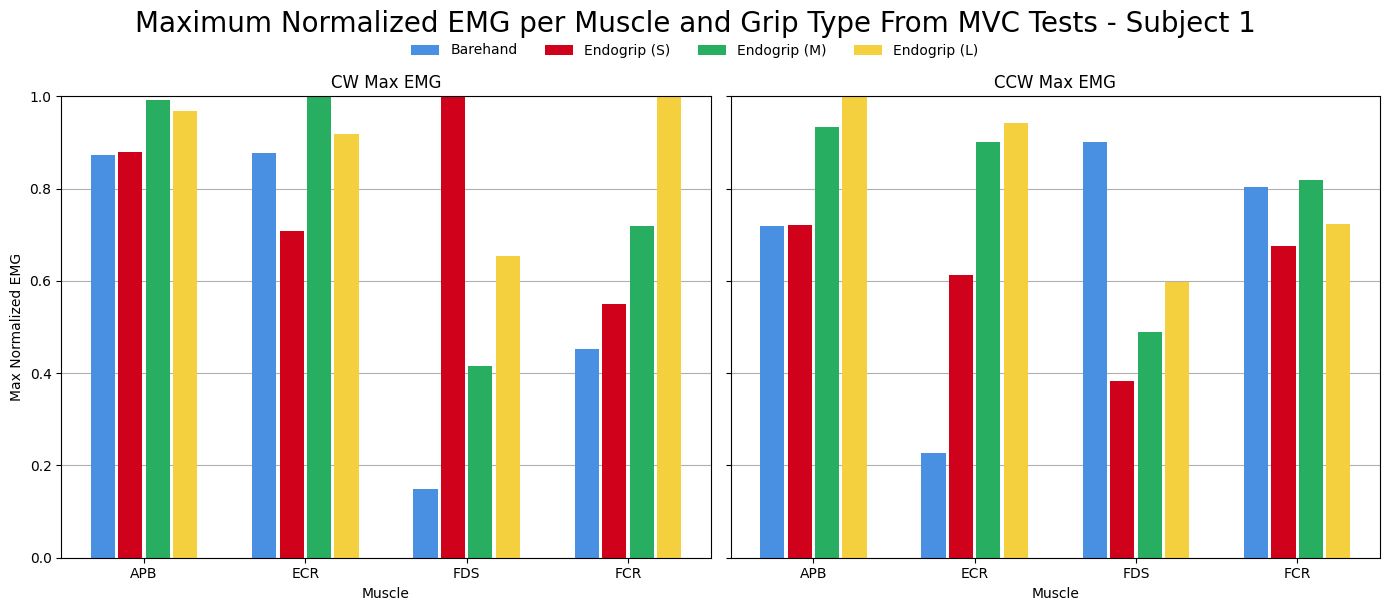

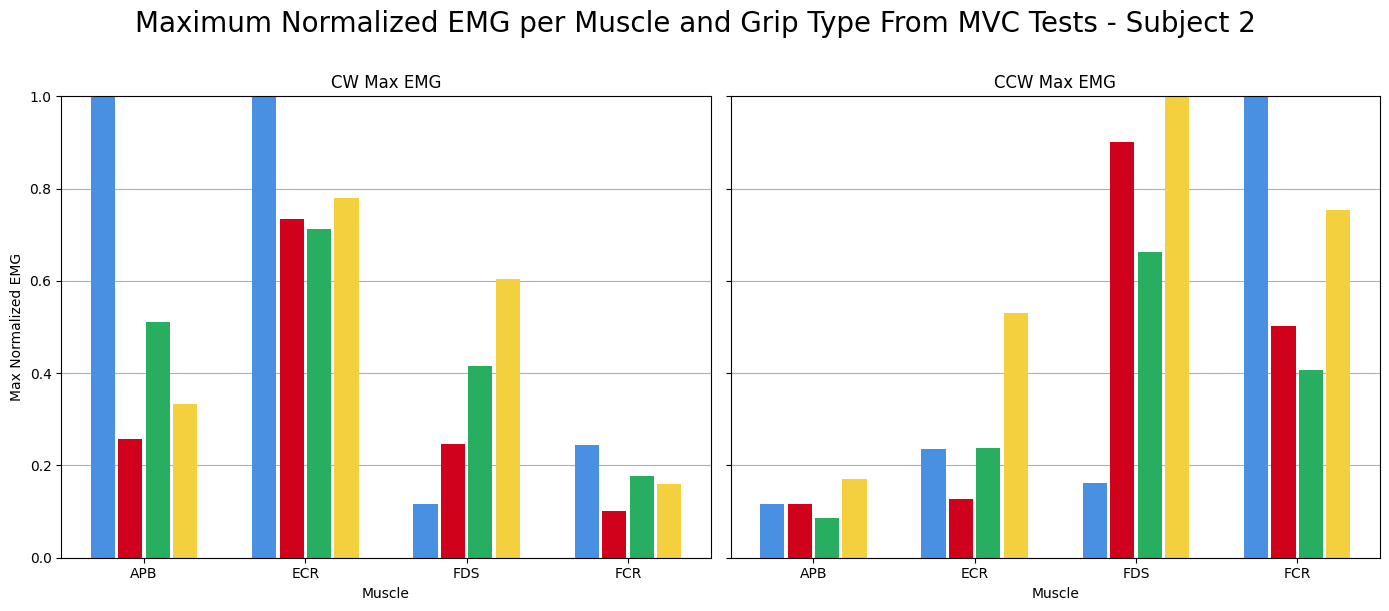

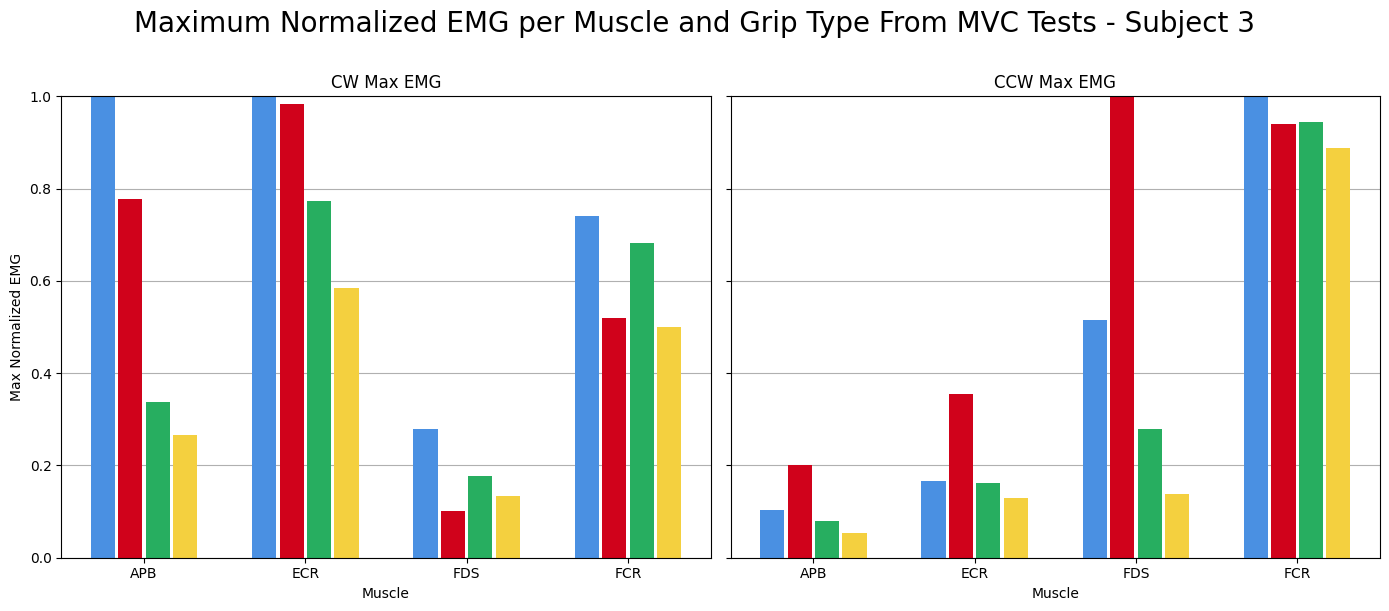

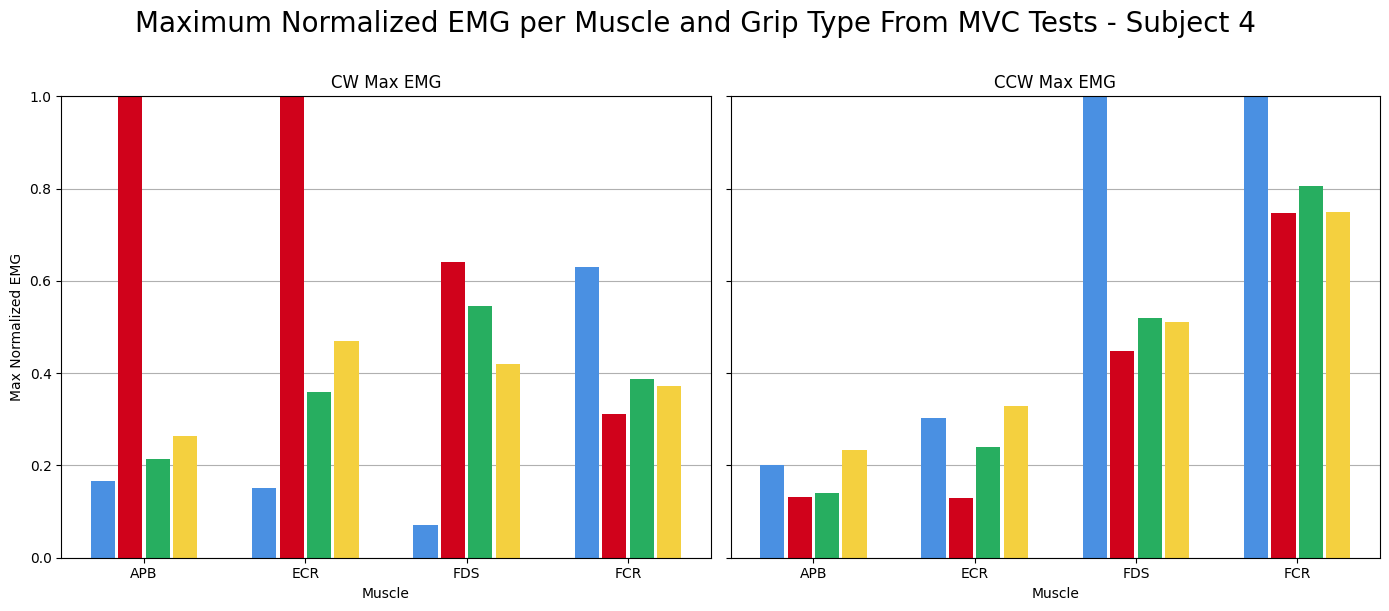

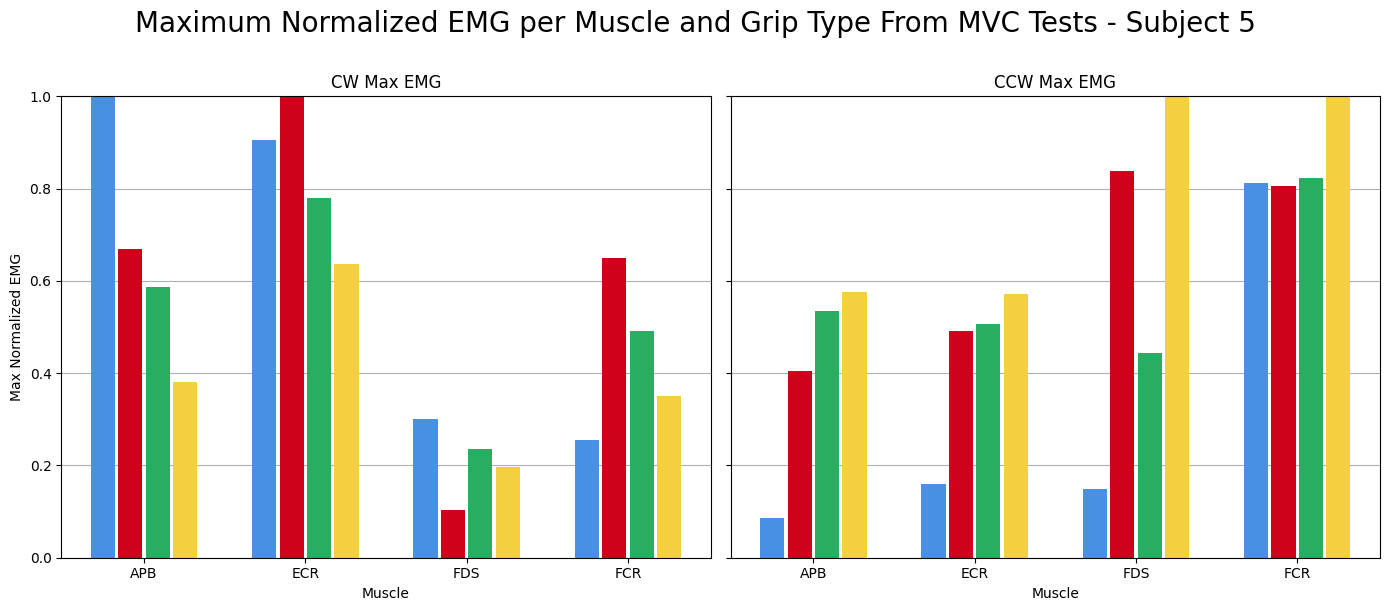

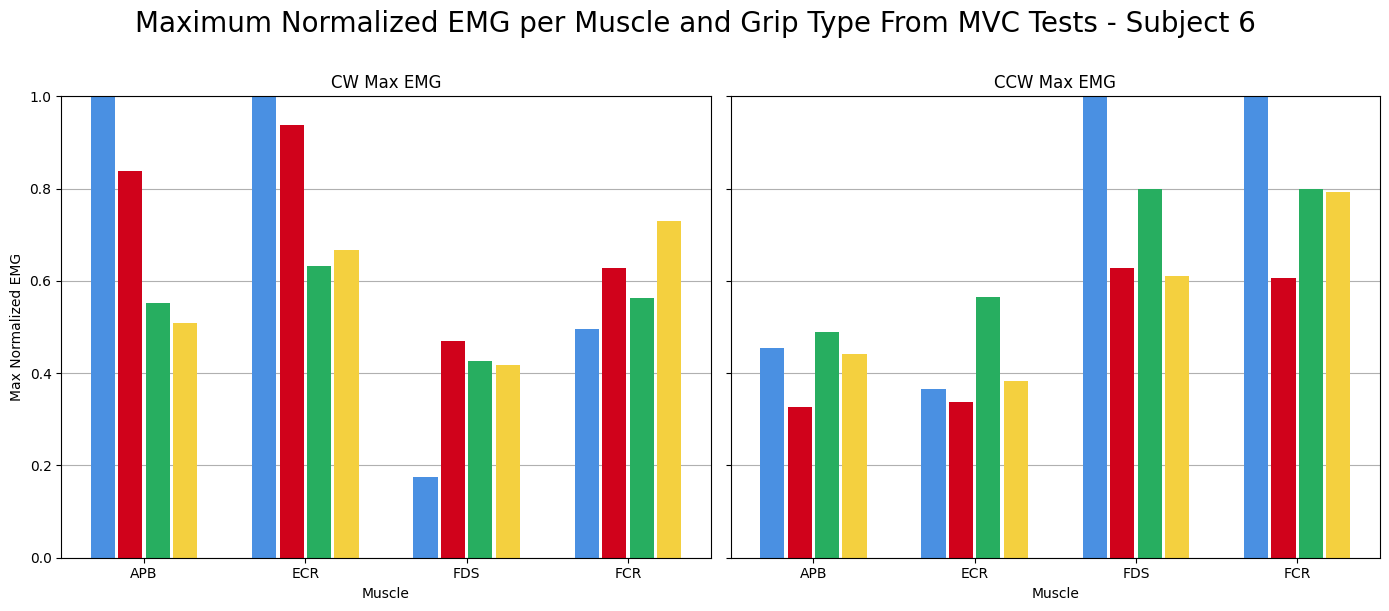

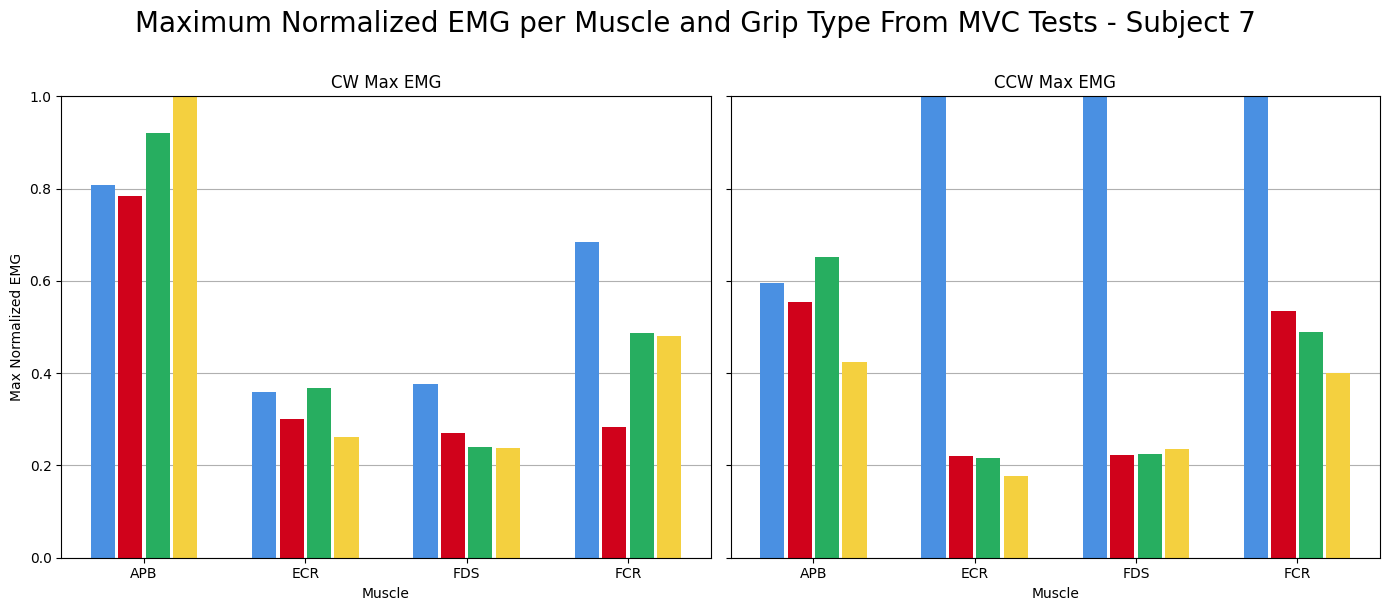

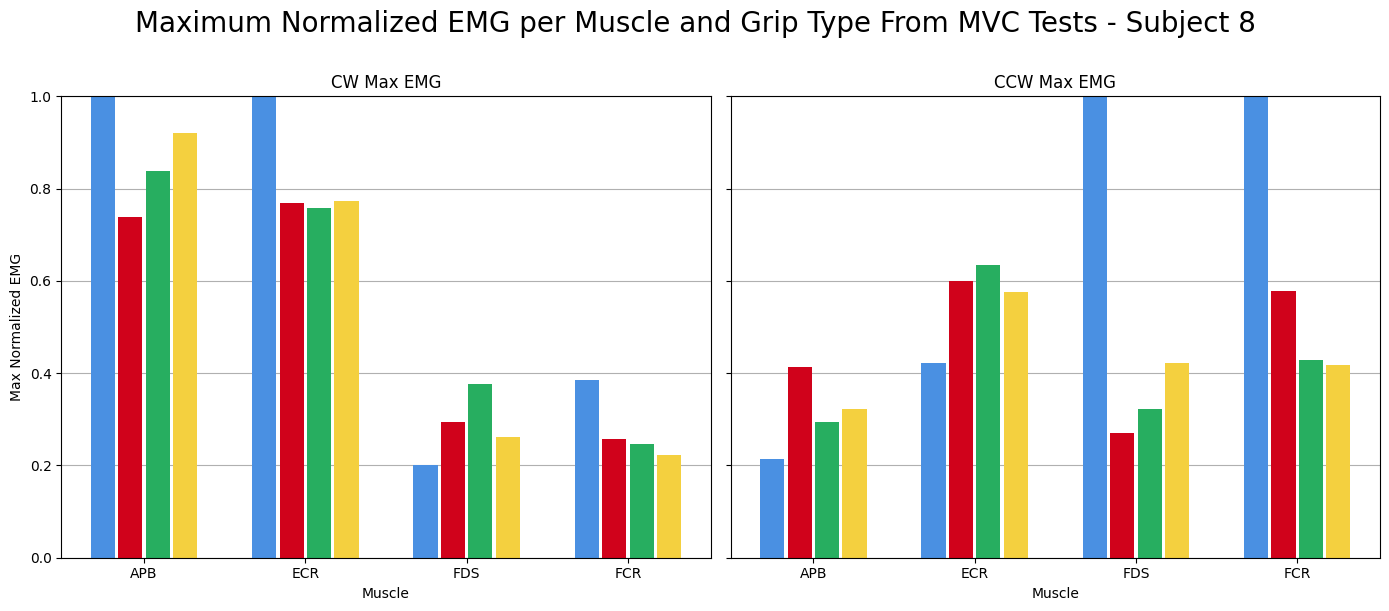

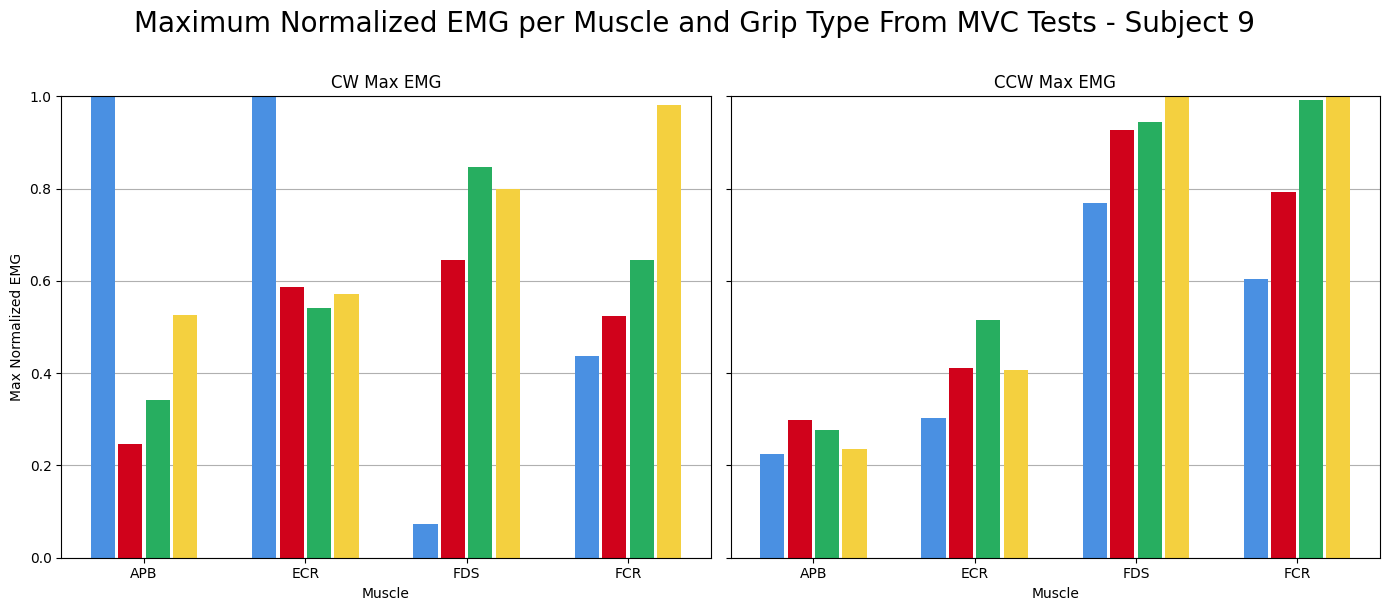

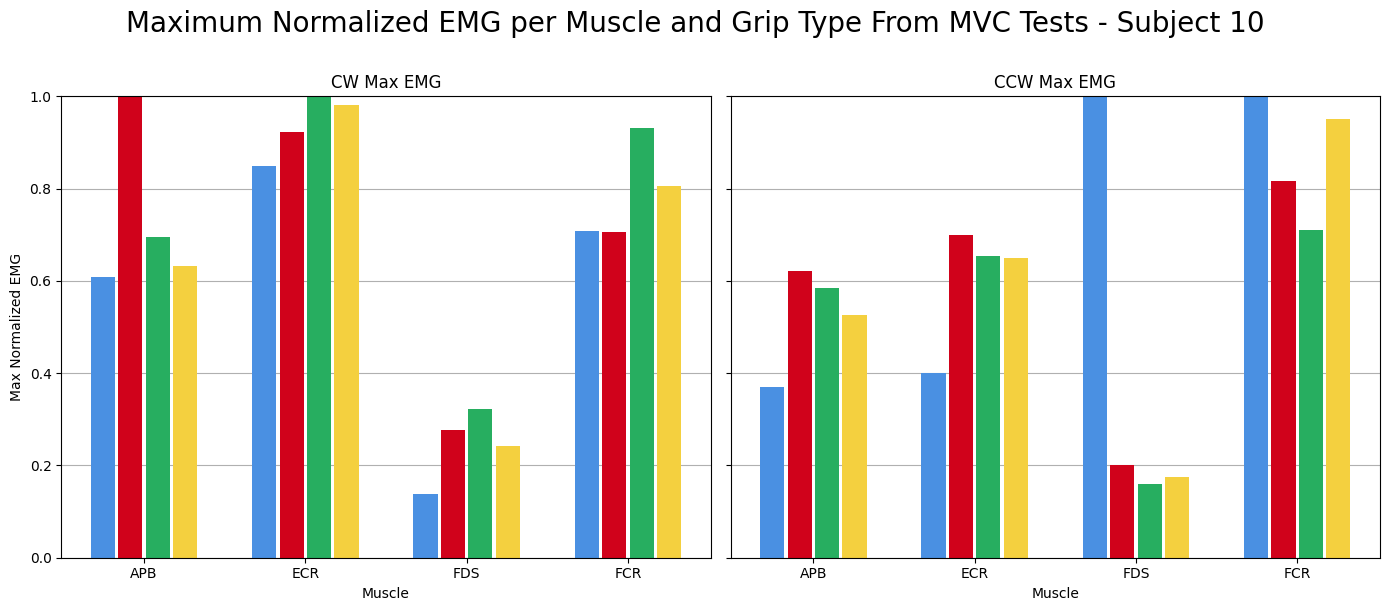

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing "
GRIPS = ['Barehand', 'Endogrip (S)', 'Endogrip (M)', 'Endogrip (L)']
ROTATIONS = ['CW', 'CCW']
MUSCLES = ['APB', 'ECR', 'FDS', 'FCR']
SUBJECTS = range(1, 11)

grip_colors = {
    'Barehand': '#4A90E2',
    'Endogrip (S)': '#D0021B',
    'Endogrip (M)': '#27ae60',
    'Endogrip (L)': '#f4d03f'
}

# Loop through each subject
for subject in SUBJECTS:
    subject_data = {'CW': {}, 'CCW': {}}
    folder = f"Subject_{subject}/Filtered_EMG_Output"
    subject_path = os.path.join(BASE_DIR, folder)

    for rot in ROTATIONS:
        for grip in GRIPS:
            filename = f"{rot} {grip} Torque.csv"
            file_path = os.path.join(subject_path, filename)

            if not os.path.exists(file_path):
                print(f"Missing: {file_path}")
                continue

            df = pd.read_csv(file_path)
            try:
                max_vals = [df[muscle].max() for muscle in MUSCLES]
            except KeyError:
                print(f"Missing muscle columns in {file_path}")
                continue

            subject_data[rot][grip] = max_vals

    if all(len(subject_data[rot]) == 0 for rot in ROTATIONS):
        print(f"No data found for Subject {subject}, skipping plot.")
        continue

    # Create one figure with two subplots (CW and CCW)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    bar_width = 0.15
    group_gap = 0.02
    x = np.arange(len(MUSCLES))

    for ax, rot in zip(axs, ROTATIONS):
        total_width = bar_width * len(GRIPS) + group_gap * (len(GRIPS) - 1)
        offsets = [i * (bar_width + group_gap) for i in range(len(GRIPS))]

        for i, grip in enumerate(GRIPS):
            if grip not in subject_data[rot]:
                continue
            values = subject_data[rot][grip]
            x_pos = x + offsets[i] - total_width / 2 + bar_width / 2
            ax.bar(x_pos, values, bar_width, label=grip, color=grip_colors[grip])

        ax.set_xticks(x)
        ax.set_xticklabels(MUSCLES)
        ax.set_title(f"{rot} Max EMG")
        ax.set_xlabel("Muscle")
        ax.grid(True, axis='y')
        ax.set_axisbelow(True)

    axs[0].set_ylabel("Max Normalized EMG")
    axs[0].set_ylim(0, 1)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.suptitle(f"Maximum Normalized EMG per Muscle and Grip Type From MVC Tests - Subject {subject}", fontsize=20, y=1.01)
    if subject == 1:
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.975), ncol=4, frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 1])  # reduced top margin
    plt.show()



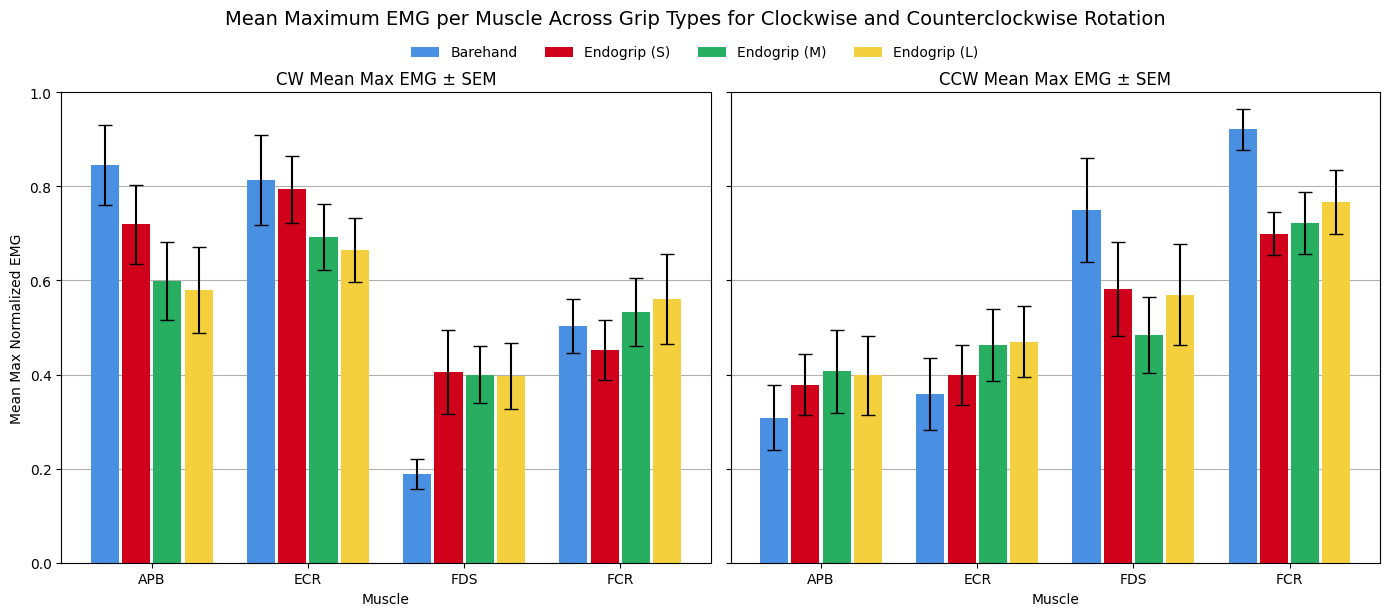

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = "/content/drive/Shareddrives/EndoGrip/2024 - 2025 /Testing /Final Testing "
GRIPS = ['Barehand', 'Endogrip (S)', 'Endogrip (M)', 'Endogrip (L)']
ROTATIONS = ['CW', 'CCW']
MUSCLES = ['APB', 'ECR', 'FDS', 'FCR']
SUBJECTS = range(1, 11)

grip_colors = {
    'Barehand': '#4A90E2',
    'Endogrip (S)': '#D0021B',
    'Endogrip (M)': '#27ae60',
    'Endogrip (L)': '#f4d03f'
}

# data[rotation][grip] = list of [APB, ECR, FDS, FCR] per subject
data = {rot: {grip: [] for grip in GRIPS} for rot in ROTATIONS}

for subject in SUBJECTS:
    folder = f"Subject_{subject}/Filtered_EMG_Output"
    subject_path = os.path.join(BASE_DIR, folder)

    for rot in ROTATIONS:
        for grip in GRIPS:
            filename = f"{rot} {grip} Torque.csv"
            file_path = os.path.join(subject_path, filename)

            if not os.path.exists(file_path):
                print(f"Missing: {file_path}")
                continue

            df = pd.read_csv(file_path)
            try:
                max_vals = [df[muscle].max() for muscle in MUSCLES]
            except KeyError:
                print(f"Missing muscle columns in {file_path}")
                continue

            data[rot][grip].append(max_vals)

# Mean and SEM per muscle per grip
mean_data = {rot: {} for rot in ROTATIONS}
sem_data = {rot: {} for rot in ROTATIONS}

for rot in ROTATIONS:
    for grip in GRIPS:
        grip_data = data[rot][grip]
        if grip_data:
            grip_array = np.array(grip_data)
            mean_data[rot][grip] = np.mean(grip_array, axis=0)
            sem_data[rot][grip] = np.std(grip_array, axis=0, ddof=1) / np.sqrt(grip_array.shape[0])
        else:
            mean_data[rot][grip] = [0]*len(MUSCLES)
            sem_data[rot][grip] = [0]*len(MUSCLES)

# Plotting
bar_width = 0.18
x = np.arange(len(MUSCLES))
group_gap = 0.02
grip_offsets = [i * (bar_width + group_gap) for i in range(len(GRIPS))]
total_width = bar_width * len(GRIPS) + group_gap * (len(GRIPS) - 1)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax, rot in zip(axs, ROTATIONS):
    for i, grip in enumerate(GRIPS):
        means = mean_data[rot][grip]
        sems = sem_data[rot][grip]
        x_pos = x + grip_offsets[i] - total_width / 2 + bar_width / 2
        ax.bar(x_pos, means, bar_width, yerr=sems, capsize=5, label=grip, color=grip_colors[grip])

    ax.set_xticks(x)
    ax.set_xticklabels(MUSCLES)
    ax.set_title(f"{rot} Mean Max EMG ± SEM")
    ax.set_xlabel("Muscle")
    ax.grid(True, axis='y')
    ax.set_axisbelow(True)

axs[0].set_ylabel("Mean Max Normalized EMG")
axs[0].set_ylim(0, 1)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=4, frameon=False)
fig.suptitle("Mean Maximum EMG per Muscle Across Grip Types for Clockwise and Counterclockwise Rotation", fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


Processing Barehand: 10 columns
Processing Small: 10 columns
Processing Medium: 10 columns
Processing Large: 10 columns


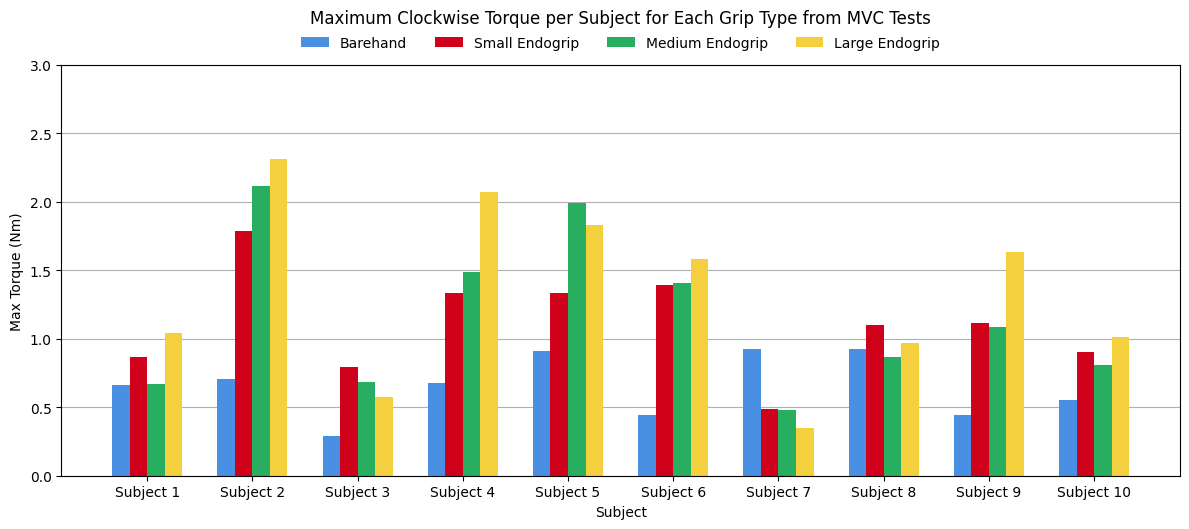

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/Data from Week 3 Testing - Load Cell - MVC (CW).csv"
df = pd.read_csv(file_path, skiprows=1)

grip_columns = {
    "Barehand": df.columns[1:11],   # Columns B–K (Subjects 1–10)
    "Small": df.columns[11:21],     # Columns M–U
    "Medium": df.columns[21:31],    # Columns V–AE
    "Large": df.columns[31:42]      # Columns AF–AO
}

# max torque values per subject
max_torque = {}
for grip, cols in grip_columns.items():
    print(f"Processing {grip}: {len(cols)} columns")
    numeric_vals = df[cols].apply(pd.to_numeric, errors='coerce')
    abs_vals = numeric_vals.abs()
    max_vals = abs_vals.max()
    max_torque[grip] = max_vals.values

subjects = [f"Subject {i+1}" for i in range(10)]
x = np.arange(len(subjects)) * 1.2  # Add spacing between subject groups
bar_width = 0.2

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - 1.5*bar_width, max_torque["Barehand"], width=bar_width, label='Barehand', color='#4A90E2')
ax.bar(x - 0.5*bar_width, max_torque["Small"], width=bar_width, label='Small Endogrip', color='#D0021B')
ax.bar(x + 0.5*bar_width, max_torque["Medium"], width=bar_width, label='Medium Endogrip', color='#27ae60')
ax.bar(x + 1.5*bar_width, max_torque["Large"], width=bar_width, label='Large Endogrip', color='#f4d03f')

ax.set_xlabel("Subject")
ax.set_ylabel("Max Torque (Nm)")
ax.set_title("Maximum Clockwise Torque per Subject for Each Grip Type from MVC Tests", pad=30)
ax.set_xticks(x)
ax.set_xticklabels(subjects)
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.10),ncol=4,frameon=False)
ax.set_ylim(0, 3)
ax.grid(True, axis='y')
ax.set_axisbelow(True)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


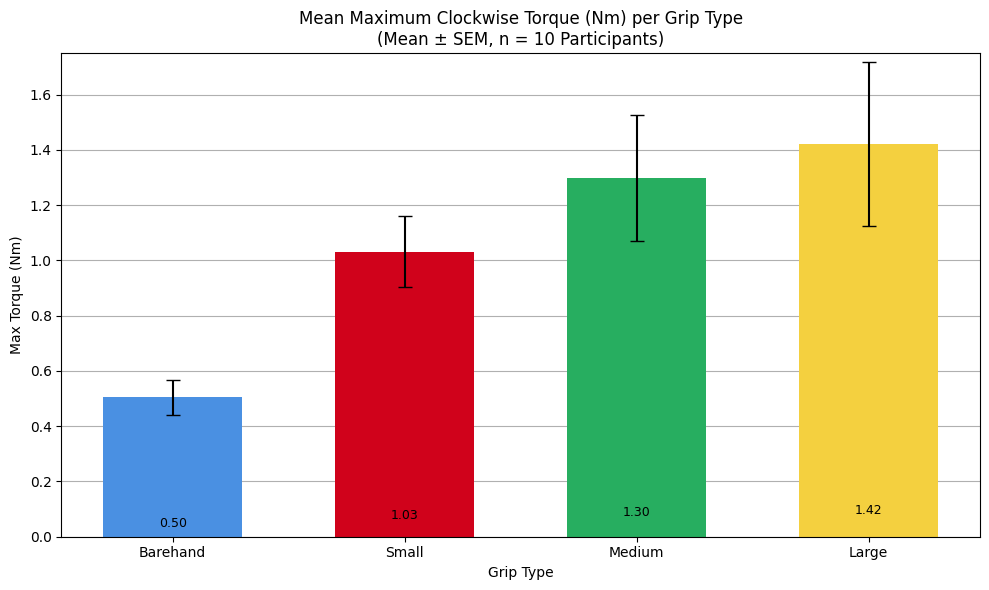

In [ ]:
import matplotlib.pyplot as plt

df = pd.DataFrame(max_torque, index=[f"Subject {i+1}" for i in range(10)])
means = df.mean()
stds = df.std()
sem = df.std(ddof=1) / np.sqrt(df.shape[0])

grips = ['Barehand', 'Small', 'Medium', 'Large']
colors = ['#4A90E2', '#D0021B', '#27ae60', '#f4d03f']
x = np.arange(len(grips))
bar_width = 0.6

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(x, means[grips], yerr=sem[grips], capsize=5, color=colors, width=bar_width)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2,height * 0.05,  f"{height:.2f}",ha='center',va='bottom',fontsize=9,color='black')

ax.set_xticks(x)
ax.set_xticklabels(grips)
ax.set_ylabel("Max Torque (Nm)")
ax.set_xlabel("Grip Type")
ax.set_title("Mean Maximum Clockwise Torque (Nm) per Grip Type\n(Mean ± SEM, n = 10 Participants)")
ax.grid(True, axis='y')
ax.set_ylim(0,1.75)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

file_path = "/content/drive/MyDrive/Data from Week 3 Testing - Load Cell - MVC (CW).csv"
df = pd.read_csv(file_path, skiprows=1)

grip_columns = {
    "Barehand": df.columns[1:11],
    "Small": df.columns[11:21],
    "Medium": df.columns[21:31],
    "Large": df.columns[31:42]
}

#long format
data = []
labels = []

for grip, cols in grip_columns.items():
    numeric_vals = df[cols].apply(pd.to_numeric, errors='coerce')
    max_vals = numeric_vals.abs().max()
    data.extend(max_vals.values)
    labels.extend([grip] * len(max_vals))

# One-way ANOVA
anova_result = f_oneway(
    [df[cols].apply(pd.to_numeric, errors='coerce').abs().max().values for cols in grip_columns.values()][0],
    [df[cols].apply(pd.to_numeric, errors='coerce').abs().max().values for cols in grip_columns.values()][1],
    [df[cols].apply(pd.to_numeric, errors='coerce').abs().max().values for cols in grip_columns.values()][2],
    [df[cols].apply(pd.to_numeric, errors='coerce').abs().max().values for cols in grip_columns.values()][3],
)

print("ANOVA p-value:", anova_result.pvalue)

# Tukey's HSD post-hoc test
tukey = pairwise_tukeyhsd(endog=data, groups=labels, alpha=0.05)
print(tukey.summary())


ANOVA p-value: 0.021455946956684846
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
Barehand  Large   0.6828 0.0157  0.1028 1.2628   True
Barehand Medium   0.5053 0.1064 -0.0747 1.0853  False
Barehand  Small    0.457 0.1656  -0.123  1.037  False
   Large Medium  -0.1775 0.8427 -0.7575 0.4025  False
   Large  Small  -0.2258 0.7224 -0.8058 0.3542  False
  Medium  Small  -0.0483 0.9959 -0.6283 0.5317  False
-----------------------------------------------------



# The below sections were used to assess different filtering methods and types of data.

# RMS MOVING WINDOW METHOD

In [ ]:
# MVC CALCULATION
DATA_CALIBRATE_DIR = "/content/drive/MyDrive/data/simran/simran_mvc/"

window_length_seconds = 0.125
window_overlap_seconds = 0.0625
cutoff_frequencies = [(25, 450)]  # High-pass at 25Hz, Low-pass at 450Hz

max_values = {1: 0.0, 3: 0.0, 5: 0.0, 7: 0.0}
column_max_values = [0.0, 0.0, 0.0, 0.0]
column_max_files = [None, None, None, None]

# Iterate through all files in the defined directory
for file in os.listdir(DATA_CALIBRATE_DIR):
    print("Reading file: ", DATA_CALIBRATE_DIR + file)
    csv_file = CSVFile(DATA_CALIBRATE_DIR + file)
    csv_file.parse_header()

    column_max_value_index = 0
    for col_num in range(1, 8, 2):
        fs = csv_file.get_column_frequency(col_num)
        nq = fs / 2

        col = csv_file.data[:, col_num]
        col = col - np.mean(col)  # Remove DC offset
        notch_filtered_col = notch_filter(fs, col)
        bandpass_filtered_col = lpf(450, nq, notch_filtered_col)

        time_axis = np.arange(len(notch_filtered_col)) / fs  # Correct time axis calculation

        window_size_samples = round(fs * window_length_seconds)
        overlap_size_samples = round(fs * window_overlap_seconds)
        step_size_samples = window_size_samples - overlap_size_samples

        mean_data = []
        time_data = []

        for start_idx in range(0, len(bandpass_filtered_col) - window_size_samples + 1, step_size_samples):
            end_idx = start_idx + window_size_samples
            window_data = bandpass_filtered_col[start_idx:end_idx]

            rms_value = np.sqrt(np.mean(window_data ** 2))
            mean_data.append(rms_value)

            center_time = start_idx / fs + (window_size_samples / 2) / fs
            time_data.append(center_time)
        """
        plt.figure(figsize=(10, 4))
        plt.plot(time_axis, notch_filtered_col, 'b', label='Original Signal', alpha=0.7)
        plt.plot(time_data, mean_data, 'r', label=f'Moving RMS Signal')
        plt.xlabel("Time (s)")
        plt.xlim(20, 28)  # Only plot between 20-30 seconds

        plt.ylabel("RMS Amplitude")
        plt.title(f"Filtered Signal (Column {col_num})")
        plt.legend()
        plt.grid()
        plt.show()
        """

        # Get the max value after filtering
        _max_val = np.max(mean_data)
        print("Column number: {}, Max Value: {}".format(col_num, _max_val))

        if _max_val > column_max_values[column_max_value_index]:
            column_max_values[column_max_value_index] = _max_val
            column_max_files[column_max_value_index] = str(file)
            max_values[col_num] = _max_val

        column_max_value_index += 1

print("Column max values: ", column_max_values)
print("Column max files: ", column_max_files)
print("Max values: ", max_values)
print(fs)

for col_num, value in max_values.items():
    print(f"{col_num}: {value:.3g}")

Reading file:  /content/drive/MyDrive/data/simran/simran_mvc/Trial_3.csv
Column number: 1, Max Value: 1.4118776956112793
Column number: 3, Max Value: 0.08336758314782655
Column number: 5, Max Value: 0.2761274852664307
Column number: 7, Max Value: 0.09244406710424499
Reading file:  /content/drive/MyDrive/data/simran/simran_mvc/Trial_5.csv
Column number: 1, Max Value: 1.0098135213207569
Column number: 3, Max Value: 0.10407869336350568
Column number: 5, Max Value: 0.3648999183064664
Column number: 7, Max Value: 0.13431816505021607
Reading file:  /content/drive/MyDrive/data/simran/simran_mvc/Trial_8.csv
Column number: 1, Max Value: 2.291589200746326
Column number: 3, Max Value: 0.22433090514834458
Column number: 5, Max Value: 0.12090472053148411
Column number: 7, Max Value: 0.09667788041531475
Reading file:  /content/drive/MyDrive/data/simran/simran_mvc/Trial_10.csv
Column number: 1, Max Value: 2.1228032138766606
Column number: 3, Max Value: 0.09679789220729836
Column number: 5, Max Value:

In [ ]:
max_values

{1: 2.291589200746326,
 3: 0.22433090514834458,
 5: 0.3742725920311059,
 7: 0.1905381726765852}

Processing file: Colonoscopy_Endogrip.csv

Results for file: Colonoscopy_Endogrip.csv
  Column 1: Highest MVC Percent = 83.66%
  Column 3: Highest MVC Percent = 103.23%
  Column 5: Highest MVC Percent = 128.99%
  Column 7: Highest MVC Percent = 500.53%
  Column 1: Mean MVC Percent (above 5%) = 15.65 ± 12.54
  Column 3: Mean MVC Percent (above 5%) = 18.58 ± 11.17
  Column 5: Mean MVC Percent (above 5%) = 16.29 ± 12.70
  Column 7: Mean MVC Percent (above 5%) = 23.01 ± 18.13
Processing file: Colonoscopy_ZBarehand.csv

Results for file: Colonoscopy_ZBarehand.csv
  Column 1: Highest MVC Percent = 79.25%
  Column 3: Highest MVC Percent = 112.76%
  Column 5: Highest MVC Percent = 81.07%
  Column 7: Highest MVC Percent = 99.83%
  Column 1: Mean MVC Percent (above 5%) = 16.71 ± 14.47
  Column 3: Mean MVC Percent (above 5%) = 20.40 ± 14.65
  Column 5: Mean MVC Percent (above 5%) = 12.18 ± 8.28
  Column 7: Mean MVC Percent (above 5%) = 17.47 ± 11.54


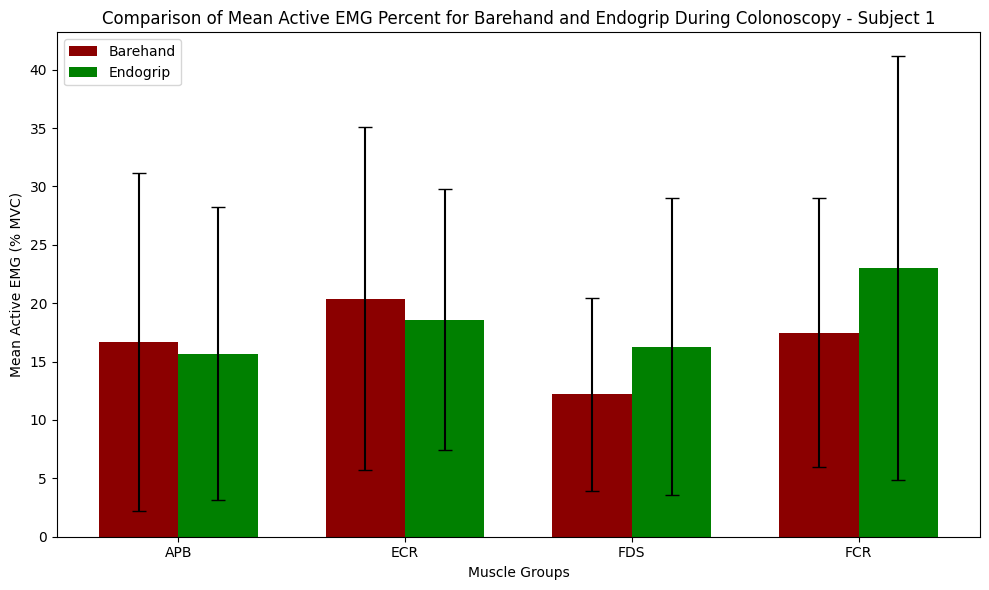

In [ ]:
# MEAN ACTIVE EMG
DATA_CALIBRATE_DIR = "/content/drive/MyDrive/data/simran/experiment/Colonoscopy"
THRESHOLD = 5
plotting = True

files_data = {}

# Iterate through all CSV files in the directory
for file in os.listdir(DATA_CALIBRATE_DIR):
    if file.endswith('.csv'):
        print(f"Processing file: {file}")
        try:
            csv_file = CSVFile(os.path.join(DATA_CALIBRATE_DIR, file))
            csv_file.parse_header()

            highest_mvc_percent = {1: 0, 3: 0, 5: 0, 7: 0}
            mean_mvc_percent = {1: 0, 3: 0, 5: 0, 7: 0}
            std_mvc_percent = {1: 0, 3: 0, 5: 0, 7: 0}

            # Loop through columns 1, 3, 5, 7
            for col_num in range(1, 8, 2):
                col = csv_file.data[:, col_num]
                fs = csv_file.get_column_frequency(col_num)  # Sampling frequency
                nq = fs / 2  # Nyquist frequency (half of sampling rate)
                h = 20
                l = 450

                notch_filtered_col = notch_filter(fs, col)  # Notch filter

                # Define window length and overlap
                window_length_seconds = 0.125
                window_overlap_seconds = 0.0625

                # Calculate window size and overlap in samples
                window_size_samples = round(fs * window_length_seconds)
                overlap_size_samples = round(fs * window_overlap_seconds)
                step_size_samples = window_size_samples - overlap_size_samples

                # Calculate moving average using sliding window with overlap
                mean_data = []
                for start_idx in range(0, len(notch_filtered_col) - window_size_samples + 1, step_size_samples):
                    end_idx = start_idx + window_size_samples
                    window_data = notch_filtered_col[start_idx:end_idx]

                    # Calculate RMS for the window
                    rms_value = np.sqrt(np.mean(window_data ** 2))  # RMS = sqrt(mean(window^2))
                    mean_data.append(rms_value)

                # Convert list to a numpy array for further processing
                mean_data = np.array(mean_data)

                # Calculate %MVC
                norm = mean_data / max_values[col_num]
                MVC_percent = norm * 100

                # Update highest MVC% for the column
                highest_mvc_percent[col_num] = np.max(MVC_percent)

                # Calculate mean and standard deviation above the threshold
                filtered_mvc_percent = MVC_percent[MVC_percent > THRESHOLD]
                if len(filtered_mvc_percent) > 0:
                    mean_mvc_percent[col_num] = np.mean(filtered_mvc_percent)
                    std_mvc_percent[col_num] = np.std(filtered_mvc_percent)

                # Calculate time in seconds (raw time)
                time_column_index = col_num - 1
                time_data = csv_file.data[:, time_column_index]

                min_length = min(len(time_data), len(MVC_percent))

                # Trim both arrays to the same length
                time_data = time_data[:min_length]
                MVC_percent = MVC_percent[:min_length]

            # Print results for the current file
            print(f"\nResults for file: {file}")
            for col_num in highest_mvc_percent:
                print(f"  Column {col_num}: Highest MVC Percent = {highest_mvc_percent[col_num]:.2f}%")
            for col_num in mean_mvc_percent:
                print(f"  Column {col_num}: Mean MVC Percent (above {THRESHOLD}%) = "
                      f"{mean_mvc_percent[col_num]:.2f} ± {std_mvc_percent[col_num]:.2f}")

            # Store results for the current file
            files_data[file] = {
                'mean': mean_mvc_percent,
                'std': std_mvc_percent
            }

        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

if files_data:
    column_labels = ['APB', 'ECR', 'FDS', 'FCR']

    # Ensure correct order of files: Barehand first, Endogrip second
    barehand_files = [file for file in files_data if 'Barehand' in file]
    endogrip_files = [file for file in files_data if 'Endogrip' in file]

    # Combine in the correct order
    ordered_files = barehand_files + endogrip_files

    x = np.arange(len(column_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars for each file in the correct order
    for idx, file_name in enumerate(ordered_files):
        means = [files_data[file_name]['mean'][col] for col in range(1, 8, 2)]
        stds = [files_data[file_name]['std'][col] for col in range(1, 8, 2)]


        low_err = [std if mean - std >= 0 else mean for mean, std in zip(means, stds)]

        ax.bar(
            x + idx * width,
            means,
            width,
            yerr=[low_err, stds],
            label=f'{"Barehand" if "Barehand" in file_name else "Endogrip"}',
            color='darkred' if "Barehand" in file_name else 'green',
            capsize=5
        )

    ax.set_xlabel('Muscle Groups')
    ax.set_ylabel('Mean Active EMG (% MVC)')
    ax.set_title('Comparison of Mean Active EMG Percent for Barehand and Endogrip During Colonoscopy - Subject 1')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(column_labels)
    ax.legend()

    plt.tight_layout()
    plt.show()


Processing file: Colonoscopy_Endogrip.csv
Processing file: Colonoscopy_ZBarehand.csv
   Condition Muscle  Fatigue Risk  Duty Cycle
0   Endogrip    APB     -1.171649   39.597315
1   Endogrip    APB      7.313991   46.756152
2   Endogrip    APB    -13.735217   24.608501
3   Endogrip    APB     -1.510442   53.467562
4   Endogrip    APB     -8.317767   21.700224
..       ...    ...           ...         ...
91  Barehand    FCR      6.712759   88.772455
92  Barehand    FCR      7.107668   94.161677
93  Barehand    FCR      7.450256   94.760479
94  Barehand    FCR      4.948185   99.700599
95  Barehand    FCR      7.450258   81.859070

[96 rows x 4 columns]


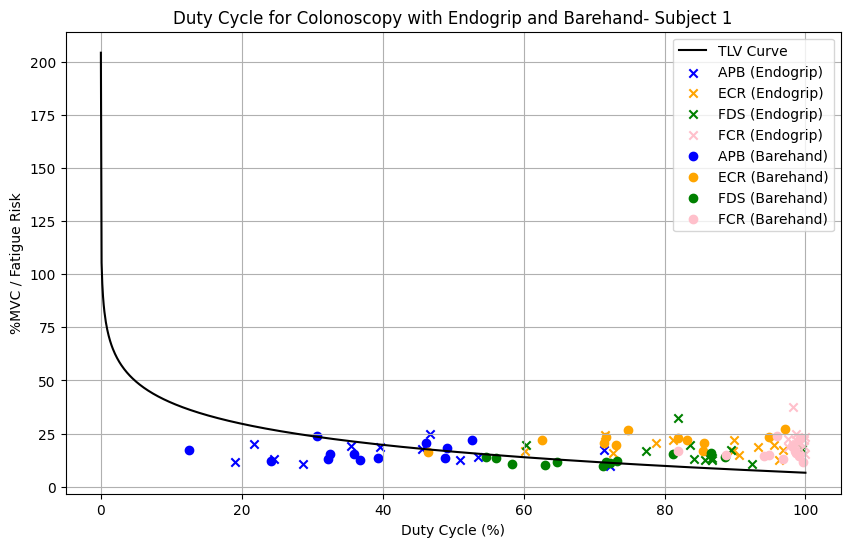

  Condition Muscle  Average Fatigue Risk
0  Barehand    APB             -5.326672
1  Barehand    ECR             11.266494
2  Barehand    FCR              9.349325
3  Barehand    FDS              0.692817
4  Endogrip    APB             -4.309636
5  Endogrip    ECR              9.259582
6  Endogrip    FCR             15.381838
7  Endogrip    FDS              7.544992


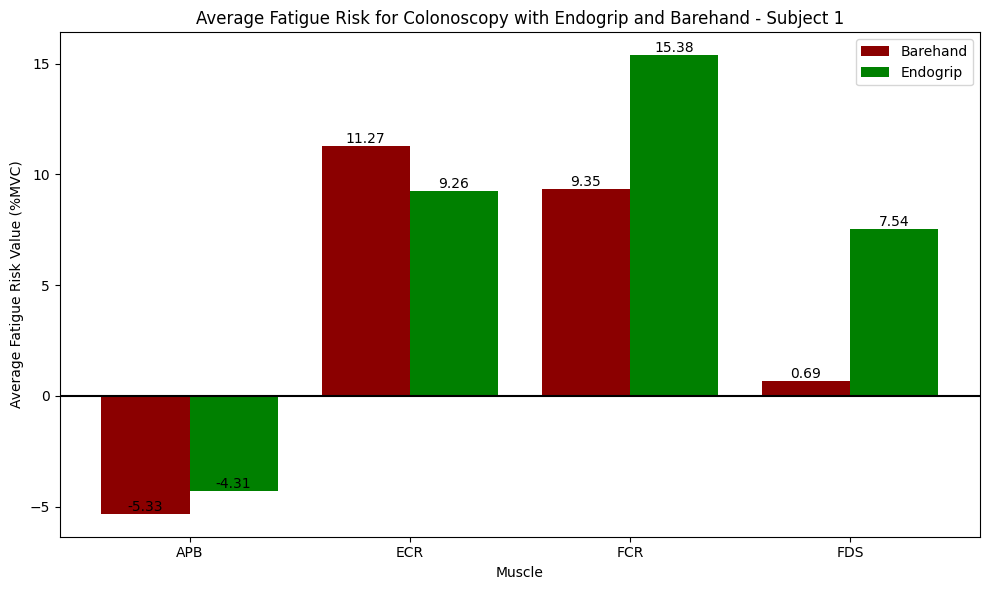

In [ ]:
# DUTY CYCLE AND FATIGUE RISK VALUE
# https://pmc.ncbi.nlm.nih.gov/articles/PMC10936263/
import pandas as pd
DATA_CALIBRATE_DIR = "/content/drive/MyDrive/data/simran/experiment/Colonoscopy"
plotting = True

# TLV curve (assuming DC values range from 0 to 1)
DC = np.linspace(0, 1, 1000)
TLV = 100 * (-0.143 * np.log(DC + 1e-6) + 0.066)  # Add a small value to avoid log(0)

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed
ax.plot(DC * 100, TLV, 'k-', label='TLV Curve')

# Define a colormap for the points
colors = ['blue', 'orange', 'green', 'pink']
column_names = {
    1: 'APB',
    3: 'ECR',
    5: 'FDS',
    7: 'FCR'}

# List to hold the fatigue risk values for the table
fatigue_risk_data = []

# Iterate through all CSV files in the directory
for file in os.listdir(DATA_CALIBRATE_DIR):
    if file.endswith('.csv'):
        print(f"Processing file: {file}")
        try:
            csv_file = CSVFile(os.path.join(DATA_CALIBRATE_DIR, file))
            csv_file.parse_header()
            # Loop through columns 1, 3, 5, 7
            # Loop through all columns defined in the column_names dictionary
            for i, col_num in enumerate([1, 3, 5, 7]):  # Ensure it covers columns 1, 3, 5, 7
                col = csv_file.data[:, col_num]
                col = col - np.mean(col)  # Remove DC offset

                fs = csv_file.get_column_frequency(col_num)  # Sampling frequency
                nq = fs / 2  # Nyquist frequency (half of sampling rate)

                # Filter the column data
                notch_filtered_col = notch_filter(fs, col)  # Notch filter

                # Define window length and overlap
                window_length_seconds = 0.125
                window_overlap_seconds = 0.0625

                # Calculate window size and overlap in samples
                window_size_samples = round(fs * window_length_seconds)
                overlap_size_samples = round(fs * window_overlap_seconds)
                step_size_samples = window_size_samples - overlap_size_samples

                # Calculate moving average using sliding window with overlap
                mean_data = []
                for start_idx in range(0, len(notch_filtered_col) - window_size_samples + 1, step_size_samples):
                    end_idx = start_idx + window_size_samples
                    window_data = notch_filtered_col[start_idx:end_idx]

                    # Calculate RMS for the window
                    rms_value = np.sqrt(np.mean(window_data ** 2))  # RMS = sqrt(mean(window^2))
                    mean_data.append(rms_value)

                # Convert list to a numpy array for further processing
                mean_data = np.array(mean_data)

                # Calculate %MVC
                norm = mean_data / max_values[col_num]
                MVC_percent = norm * 100

                # Calculate Duty Cycle and EMG
                sr = 2148  # sampling rate
                threshold = 5
                num_slices = 12  # Number of slices to split the data into
                duty_cycles, avg_emg = calculate_duty_cycle_and_emg(MVC_percent, sr, threshold, num_slices, window_length=1)

                # Ensure duty_cycles and avg_emg are numpy arrays
                duty_cycles = np.array(duty_cycles)
                avg_emg = np.array(avg_emg)

                column_name = column_names[col_num]  # Get the column name from the dictionary
                condition = "Barehand" if 'Barehand' in file else "Endogrip"  # Determine the condition

                # Calculate the fatigue risk value for each duty cycle (with the sign)
                fatigue_risk = avg_emg - np.interp(duty_cycles / 100, DC, TLV)  # Keep the sign of the difference

                # Store fatigue risk values in the table (condition, muscle, fatigue risk)
                for j, risk in enumerate(fatigue_risk):
                    fatigue_risk_data.append([condition, column_name, risk, duty_cycles[j]])

                # Plotting
                ax.scatter(duty_cycles, avg_emg, label=f'{column_name} ({condition})', color=colors[i], marker='o' if condition == 'Barehand' else 'x')

        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

# Convert the list of data into a pandas DataFrame
fatigue_risk_df = pd.DataFrame(fatigue_risk_data, columns=['Condition', 'Muscle', 'Fatigue Risk', 'Duty Cycle'])

# Display the table of fatigue risk values
print(fatigue_risk_df)
fatigue_risk_df.to_csv('/content/drive/MyDrive/data/simran/fatigue_risk_values.csv', index=False)


# Optionally, plot the fatigue risk values (you can modify this as needed)
ax.set_title('Duty Cycle for Colonoscopy with Endogrip and Barehand- Subject 1')
ax.set_xlabel('Duty Cycle (%)')
ax.set_ylabel('%MVC / Fatigue Risk')
ax.grid(True)
ax.legend()
plt.show()

# Calculate the average fatigue risk for each condition and muscle
average_fatigue_risk = []

# Group by condition and muscle, then calculate the mean fatigue risk
for condition in ['Barehand', 'Endogrip']:
    for muscle in ['APB', 'ECR', 'FCR', 'FDS']:
        # Filter the rows for the given condition and muscle
        muscle_data = fatigue_risk_df[(fatigue_risk_df['Condition'] == condition) & (fatigue_risk_df['Muscle'] == muscle)]

        # Calculate the average fatigue risk for the filtered data
        avg_fatigue_risk = muscle_data['Fatigue Risk'].mean()

        # Append the result to the list
        average_fatigue_risk.append([condition, muscle, avg_fatigue_risk])

# Create a new DataFrame to store the averages
average_fatigue_df = pd.DataFrame(average_fatigue_risk, columns=['Condition', 'Muscle', 'Average Fatigue Risk'])

# Display the result
print(average_fatigue_df)

# Create a plot for average fatigue risk values
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

# Define colors for the different muscles
condition_colors = {'Endogrip': 'green', 'Barehand': 'darkred'}
muscles = ['APB', 'ECR', 'FCR', 'FDS']
x = np.arange(len(muscles))  # Numeric positions for each muscle
width = 0.4  # Adjust bar width to make them touch

for i, muscle in enumerate(muscles):
    for j, condition in enumerate(['Barehand', 'Endogrip']):
        # Filter the rows for the given condition and muscle
        muscle_data = average_fatigue_df[
            (average_fatigue_df['Condition'] == condition) &
            (average_fatigue_df['Muscle'] == muscle)
        ]

        # Get the average fatigue risk value
        avg_fatigue_risk = muscle_data['Average Fatigue Risk'].values[0]

        # Adjust x-position so bars touch
        x_pos = x[i] + (j - 0.5) * width  # -0.5 for Barehand, +0.5 for Endogrip

        # Plot the bar
        bars = ax.bar(x_pos, avg_fatigue_risk, width=width, color=condition_colors[condition], label=condition if i == 0 else "")

        # Add text on top of each bar
        for bar in bars:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{avg_fatigue_risk:.2f}',
                    ha='center', va='bottom', color='black', fontsize=10)

# Plot settings
ax.set_title('Average Fatigue Risk for Colonoscopy with Endogrip and Barehand - Subject 1')
ax.set_ylabel('Average Fatigue Risk Value (%MVC)')
ax.set_xlabel('Muscle')
ax.set_xticks(x)
plt.axhline(y=0, color='black', linestyle='-')
ax.set_xticklabels(muscles)
ax.legend()

plt.tight_layout()  # Ensure labels fit
plt.show()


# MANUALLY GENERATED SIGNAL WITH NOISE

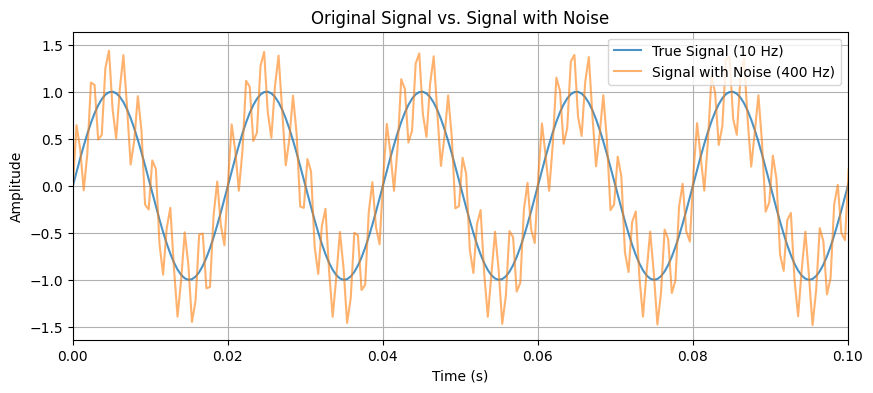

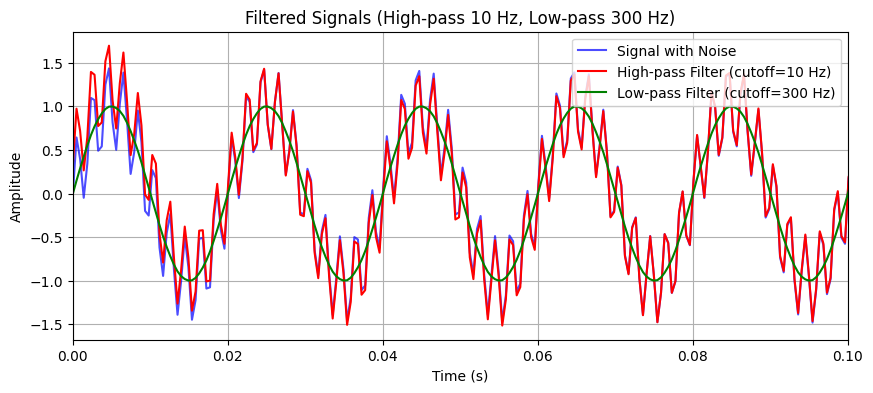

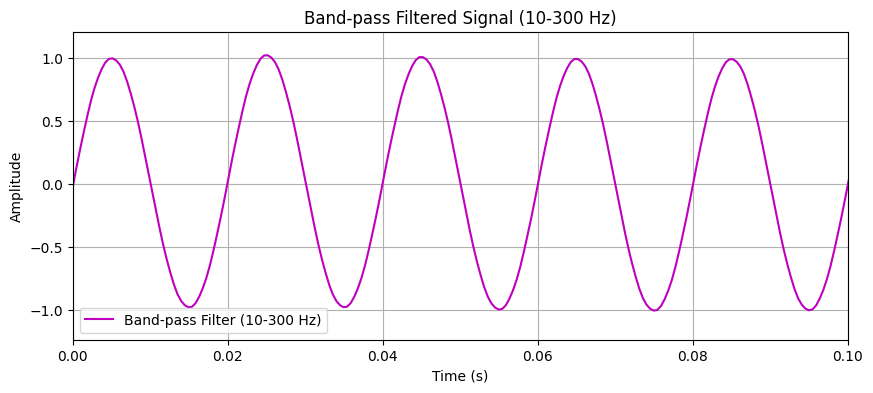

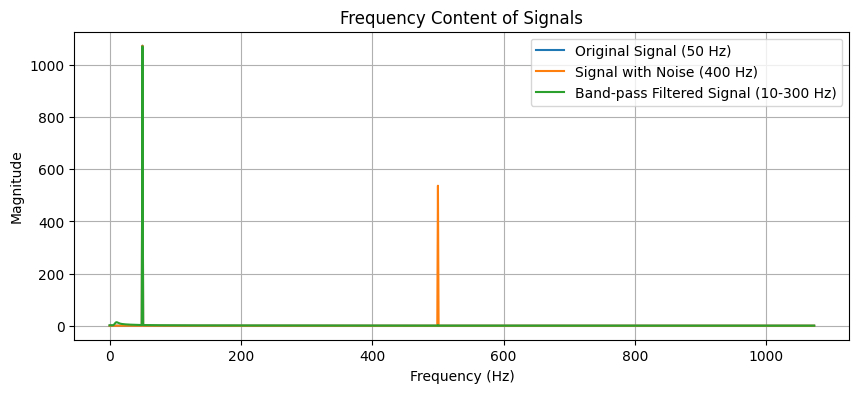

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal


def lpf(l, nq, col):
    loww = l/nq
    b, a = scipy.signal.butter(4, loww, btype='low')
    return scipy.signal.filtfilt(b, a, col)

def hpf(h, nq, col):
    h = h/nq
    b, a = scipy.signal.butter(4, h, btype='high')
    return scipy.signal.filtfilt(b, a, col)

def bpf(l, h, nq, data, order=4):
    low = l / nq
    high = h / nq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

# Parameters
fs = 2148  # Sampling frequency (Hz)
nq = fs / 2  # Nyquist frequency
duration = 1  # seconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)  # Time vector

# Signal parameters
A = 1.0  # Amplitude of true signal
w1 = 2 * np.pi * 50  # True signal frequency (25 Hz)

# Noise parameters
N = 0.5  # Noise magnitude
wN = 2 * np.pi * 500  # Noise frequency (500 Hz)

# Generate signal and noise
true_signal = A * np.sin(w1 * t)
noise_signal = N * np.sin(wN * t)
signal_with_noise = true_signal + noise_signal

# Plot original and noisy signal
plt.figure(figsize=(10, 4))
plt.plot(t, true_signal, label="True Signal (10 Hz)", alpha=0.8)
plt.plot(t, signal_with_noise, label="Signal with Noise (400 Hz)", alpha=0.6)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original Signal vs. Signal with Noise")
plt.legend()
plt.grid()
plt.xlim(0, 0.1)  # Zoom in for better visualization
plt.show()

# Apply filters
h = 10  # High-pass cutoff frequency
l = 300  # Low-pass cutoff frequency

filtered_signal = hpf(h, nq, signal_with_noise)
low_pass_filtered_signal = lpf(l, nq, signal_with_noise)
band_pass_filtered = bpf(h, l, nq, signal_with_noise)

# Plot signals before and after filtering
plt.figure(figsize=(10, 4))
plt.plot(t, signal_with_noise, 'b', label='Signal with Noise', alpha=0.7)
plt.plot(t, filtered_signal, 'r', label=f'High-pass Filter (cutoff={h} Hz)')
plt.plot(t, low_pass_filtered_signal, 'g', label=f'Low-pass Filter (cutoff={l} Hz)')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Filtered Signals (High-pass {h} Hz, Low-pass {l} Hz)")
plt.legend()
plt.grid()
plt.xlim(0, 0.1)  # Zoom in for better visualization
plt.show()

# Plot Band-Pass Filtered Signal on a new graph
plt.figure(figsize=(10, 4))
plt.plot(t, band_pass_filtered, 'm', label=f'Band-pass Filter ({h}-{l} Hz)')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Band-pass Filtered Signal ({h}-{l} Hz)")
plt.legend()
plt.grid()
plt.xlim(0, 0.1)  # Zoom in for better visualization
plt.show()

# Frequency analysis before and after filtering using FFT
def plot_fft(signal, fs, label):
    # Compute the FFT
    N = len(signal)
    freqs = np.fft.fftfreq(N, 1/fs)
    fft_vals = np.fft.fft(signal)

    # Plot the magnitude of the FFT
    plt.plot(freqs[:N//2], np.abs(fft_vals)[:N//2], label=label)

# Plot FFT of signals
plt.figure(figsize=(10, 4))

# Original Signal
plot_fft(true_signal, fs, "Original Signal (50 Hz)")

# Signal with Noise
plot_fft(signal_with_noise, fs, "Signal with Noise (400 Hz)")

# Filtered Signal
plot_fft(band_pass_filtered, fs, f"Band-pass Filtered Signal ({h}-{l} Hz)")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Content of Signals")
plt.legend()
plt.grid()
plt.show()


WORK ON MAKING A FAKE SIGNAL AND DOING RMS MOVING WINDOW - RIGHT NOW THE RMS FILTERED SIGNAL IS WRONG

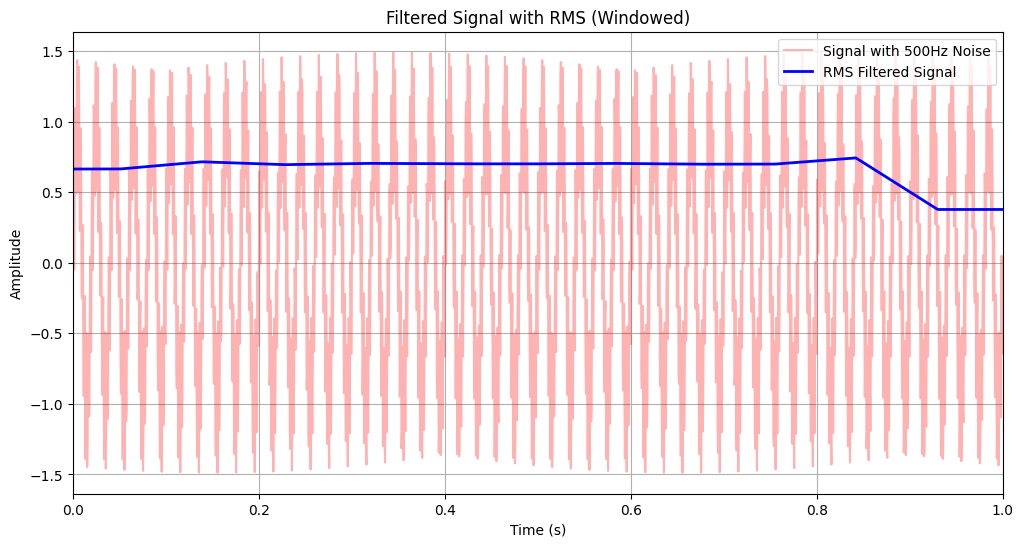

In [ ]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Parameters
fs = 2148  # Sampling frequency (Hz)
nq = fs / 2  # Nyquist frequency
duration = 1  # seconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)  # Time vector

# Signal parameters
A = 1.0  # Amplitude of true signal
w1 = 2 * np.pi * 50  # True signal frequency (50 Hz)

# Noise parameters
N = 0.5  # Noise magnitude
wN = 2 * np.pi * 500  # Noise frequency (500 Hz)

# Generate signal and noise
true_signal = A * np.sin(w1 * t)
noise_signal = N * np.sin(wN * t)
signal_with_noise = true_signal + noise_signal

# Apply Notch + Bandpass filtering
notch_filtered_signal = notch_filter(fs, signal_with_noise)
bpf_filtered_signal = bpf(45, 55, nq, notch_filtered_signal)  # Bandpass filter for 50 Hz signal

# RMS Parameters
window_sizes = [0.01, 0.1]  # Window sizes in seconds (10ms, 100ms)
window_overlap_seconds = 0.012  # 12ms overlap

# Initialize list to store the final RMS signal
rms_filtered_signal = np.zeros(len(t))

for window_length_seconds in window_sizes:
    window_size_samples = round(fs * window_length_seconds)
    overlap_size_samples = round(fs * window_overlap_seconds)
    step_size_samples = window_size_samples - overlap_size_samples

    mean_data = []
    time_data = []

    for start_idx in range(0, len(bpf_filtered_signal) - window_size_samples + 1, step_size_samples):
        end_idx = start_idx + window_size_samples
        window_data = bpf_filtered_signal[start_idx:end_idx]
        rms_value = np.sqrt(np.mean(window_data ** 2))  # RMS Calculation
        mean_data.append(rms_value)
        center_time = start_idx / fs + (window_size_samples / 2) / fs
        time_data.append(center_time)

    # Interpolate the RMS values to match the original time vector
    if time_data and mean_data:
        rms_filtered_signal = np.interp(t, time_data, mean_data)

# Plot true signal, noisy signal, and filtered RMS signal
plt.figure(figsize=(12, 6))
plt.plot(t, signal_with_noise, 'r', label="Signal with 500Hz Noise", alpha=0.3)
plt.plot(t, rms_filtered_signal, 'b', label="RMS Filtered Signal", linewidth=2)

plt.xlabel("Time (s)")
plt.xlim(0, 1)  # Full range of signal time
plt.ylabel("Amplitude")
plt.title("Filtered Signal with RMS (Windowed)")
plt.legend()
plt.grid()
plt.show()


# PLOTS FOR DIFFERENT FILTERING

Processing file: Trial_10.csv


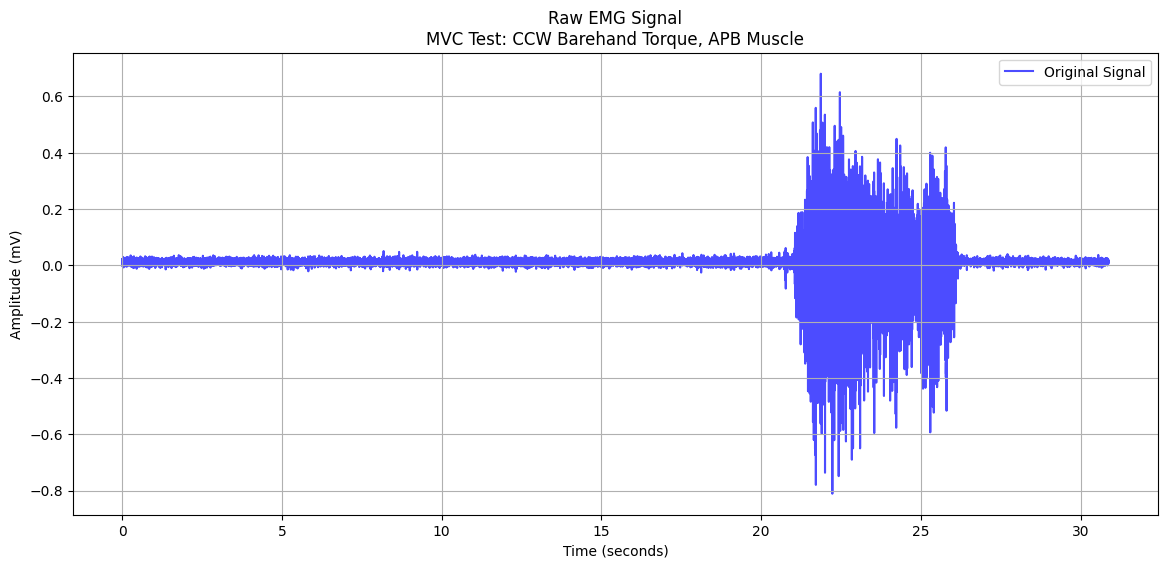

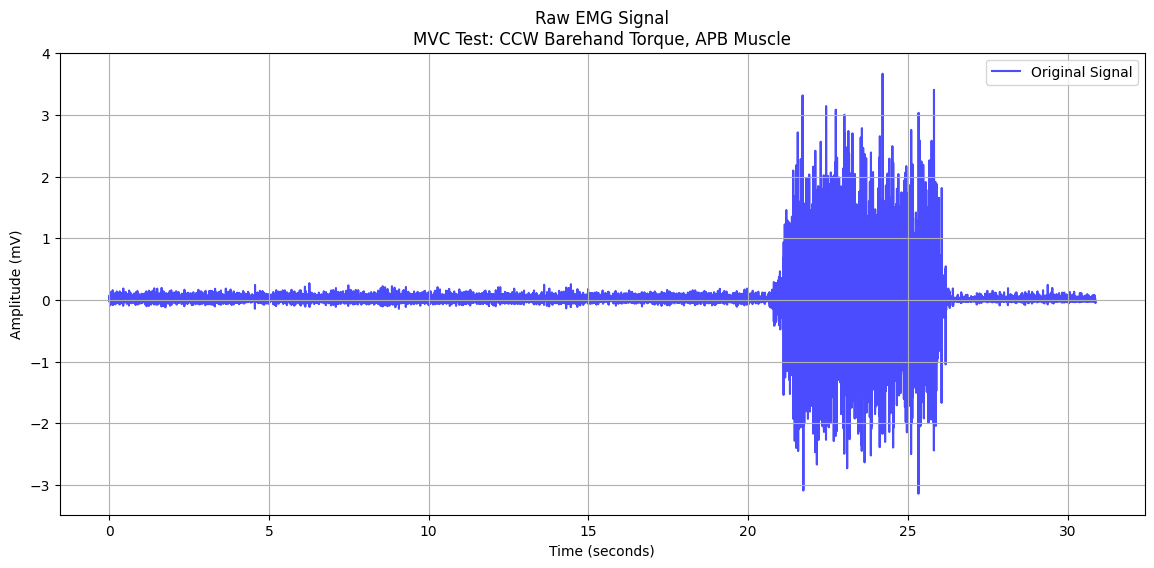

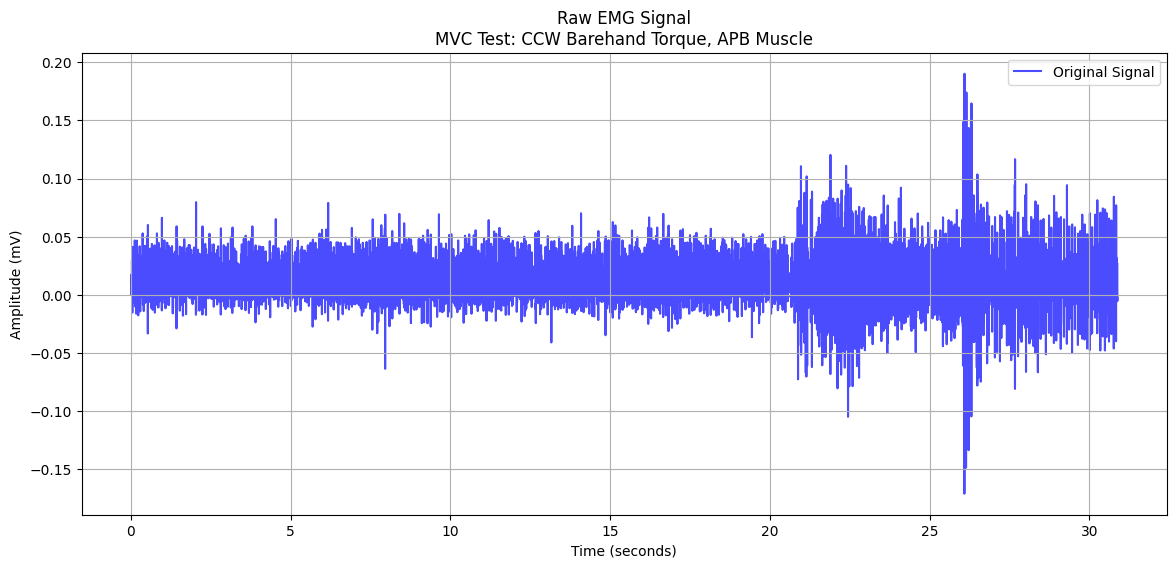

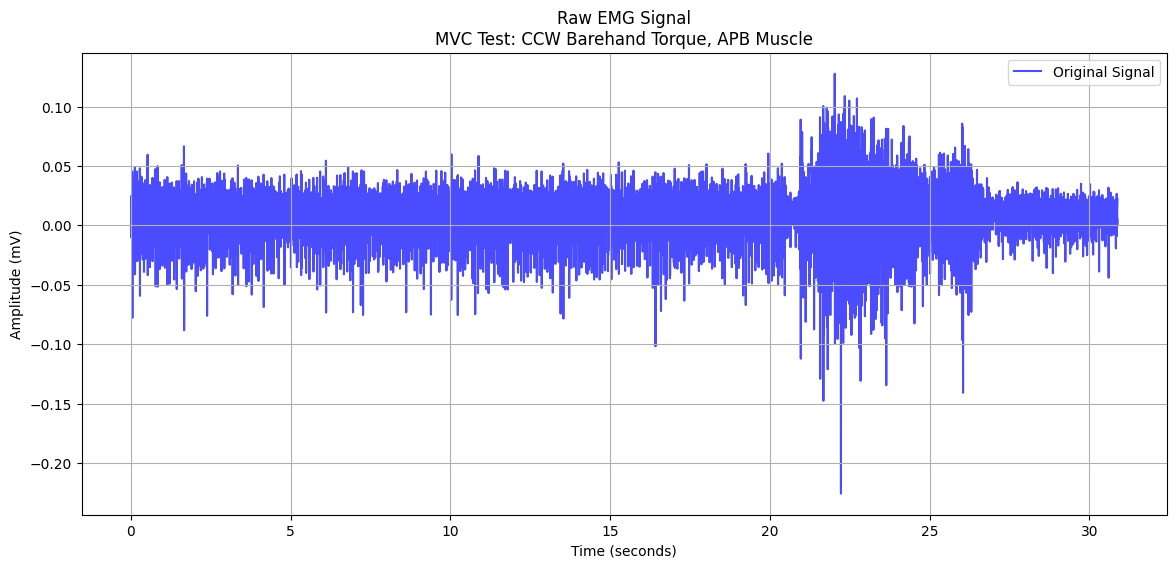

In [ ]:
#PLOTTING THE MVC GRAPHS BASED OF DIFFERENT FILTERS
DATA_CALIBRATE_DIR = "/content/drive/MyDrive/data/ava/ava_mvc/"
plotting = True

# Iterate through all CSV files in the directory
for file in os.listdir(DATA_CALIBRATE_DIR):
    if file.endswith('.csv'):
        print(f"Processing file: {file}")
        try:
            csv_file = CSVFile(os.path.join(DATA_CALIBRATE_DIR, file))
            csv_file.parse_header()

            # Loop through columns 1, 3, 5, 7
            for col_num in range(1, 8, 2):
                col = csv_file.data[:, col_num]
                fs = csv_file.get_column_frequency(col_num)  # Sampling frequency
                nq = fs / 2  # Nyquist frequency
                h = 20
                l = 450

                # Original signal
                time_data = csv_file.data[:, col_num - 1]

                # Apply notch filter to column
                notch_filtered_col = notch_filter(fs, col)

                # Apply low-pass filter
                bpf_filtered_col = lpf(l, nq, notch_filtered_col)

                # Full-wave rectification (converts negative values to positive)
                bpf_filtered_col_abs = np.absolute(bpf_filtered_col)

                # Apply a low-pass filter to high-frequency components
                lpf_filtered_col = lpf(5, fs, bpf_filtered_col_abs)

                # Calculate noise (difference between original and filtered signals)
                # noise = col - bpf_filtered_col

                # Calculate SNR (for the original signal vs. filtered signal)
                # snr = calculate_snr(col, noise)

                # Plot signals
                plt.figure(figsize=(14, 6))
                plt.plot(time_data, col, label='Original Signal', alpha=0.7, color='blue', zorder=1)
                #plt.plot(time_data, bpf_filtered_col_abs, label='Rectified Signal', alpha=0.8, color='green', zorder=2)
                #plt.scatter(time_data, lpf_filtered_col, label='EMG Envelope', color='red', alpha=1, s=1, zorder=3)
                #plt.xlim(20, 24)

                plt.title(f'Raw EMG Signal\nMVC Test: CCW Barehand Torque, APB Muscle')

                # Plot FFT of original and filtered signals
                #plt.title(f'Filtered Signals for Column {col_num} - {file}')
                plt.xlabel('Time (seconds)')
                plt.ylabel('Amplitude (mV)')
                plt.grid(True)
                plt.legend()
                plt.show()

                # Plot frequency-domain (FFT) for original signal
                #plot_fft(col, bpf_filtered_col, fs, f'FFT of Original and Filtered Signal - {file} (Channel {col_num})')

        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue


Processing file: Colonoscopy_Endogrip.csv


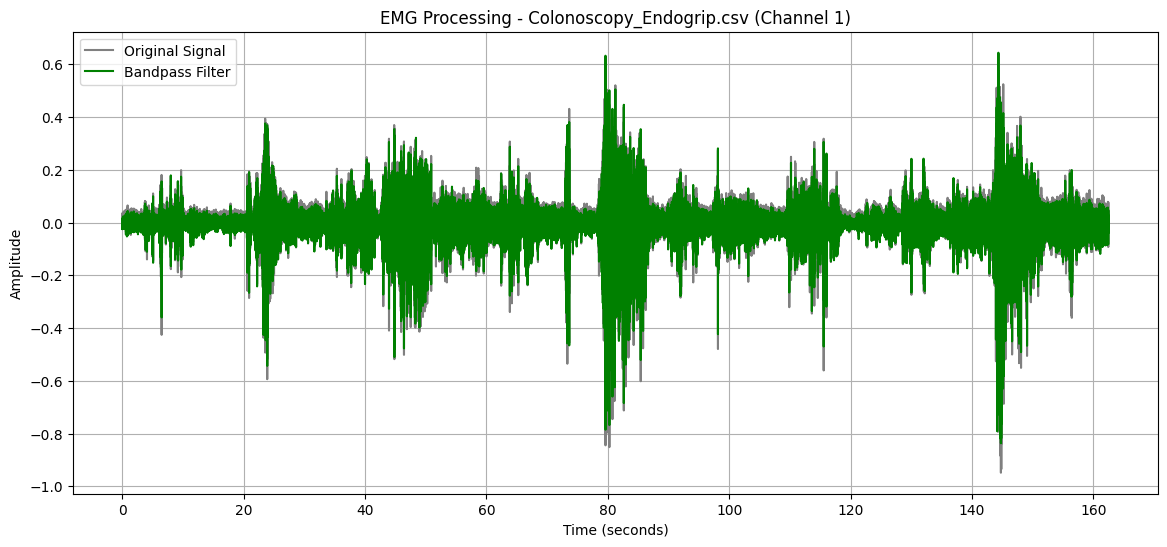

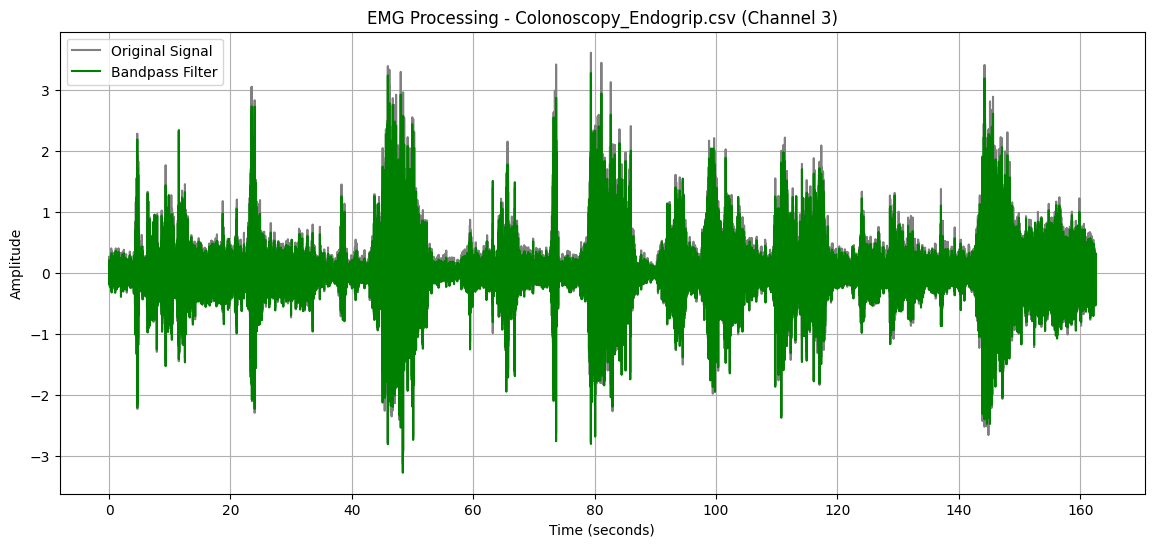

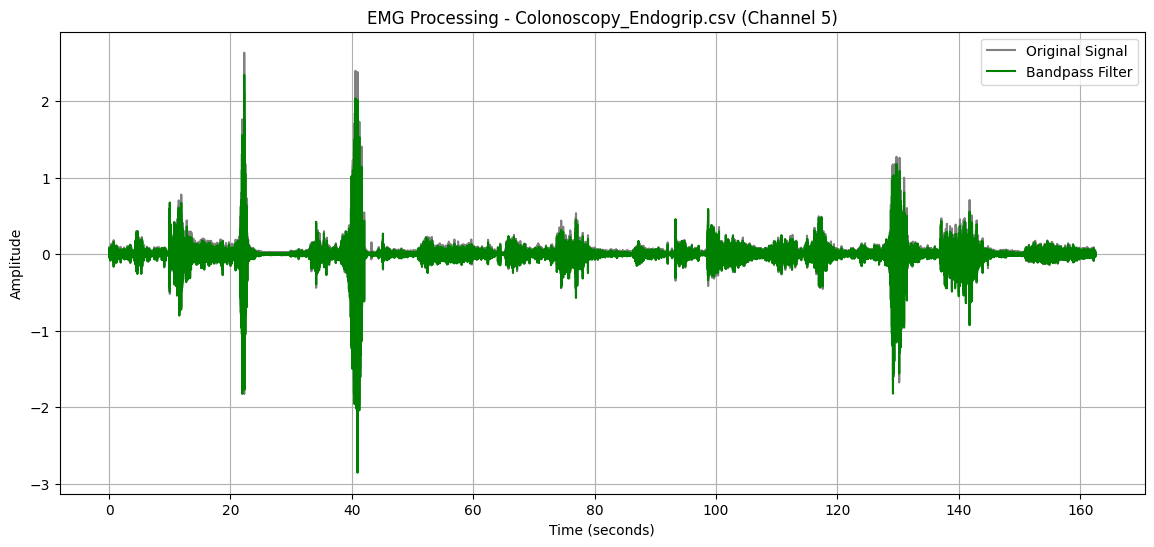

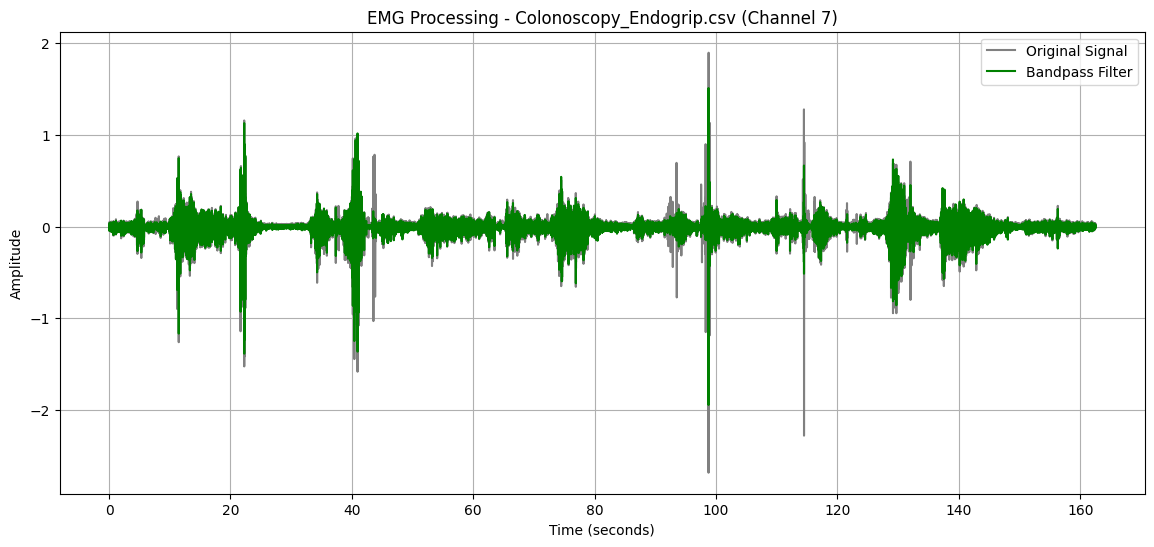

Processing file: Colonoscopy_Barehand.csv


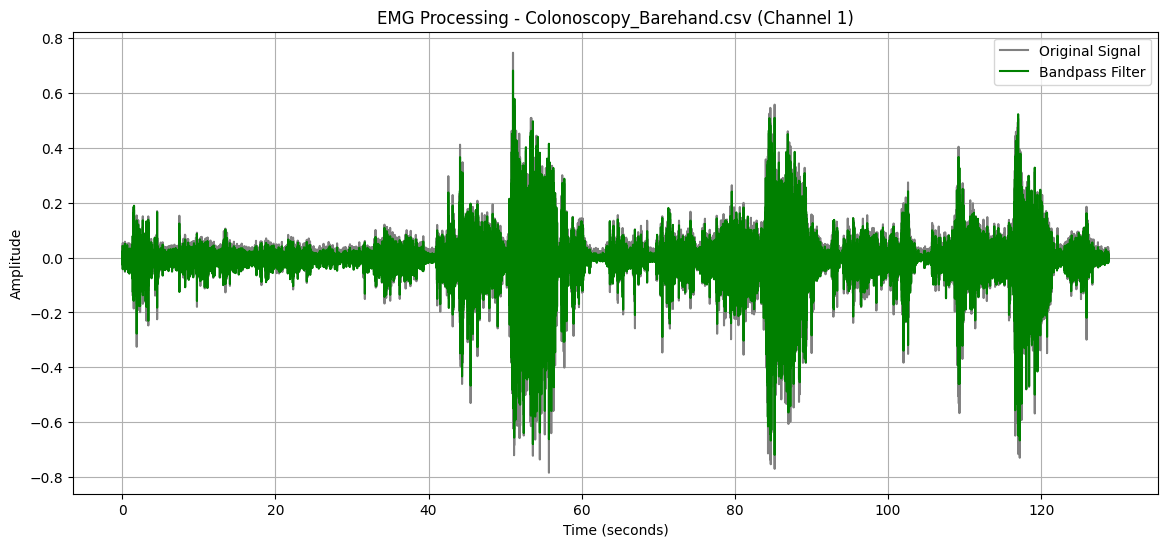

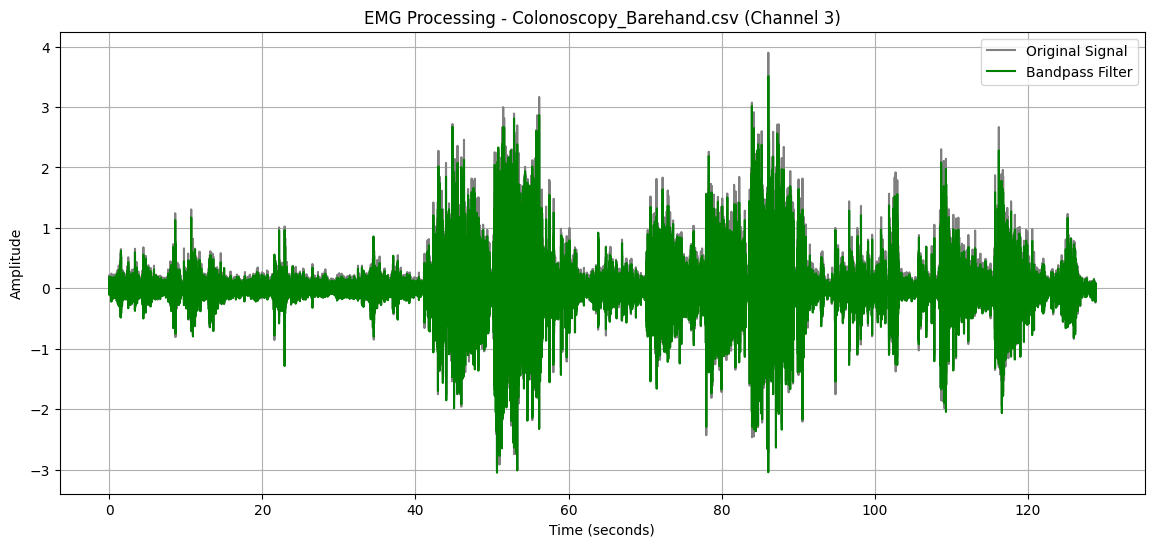

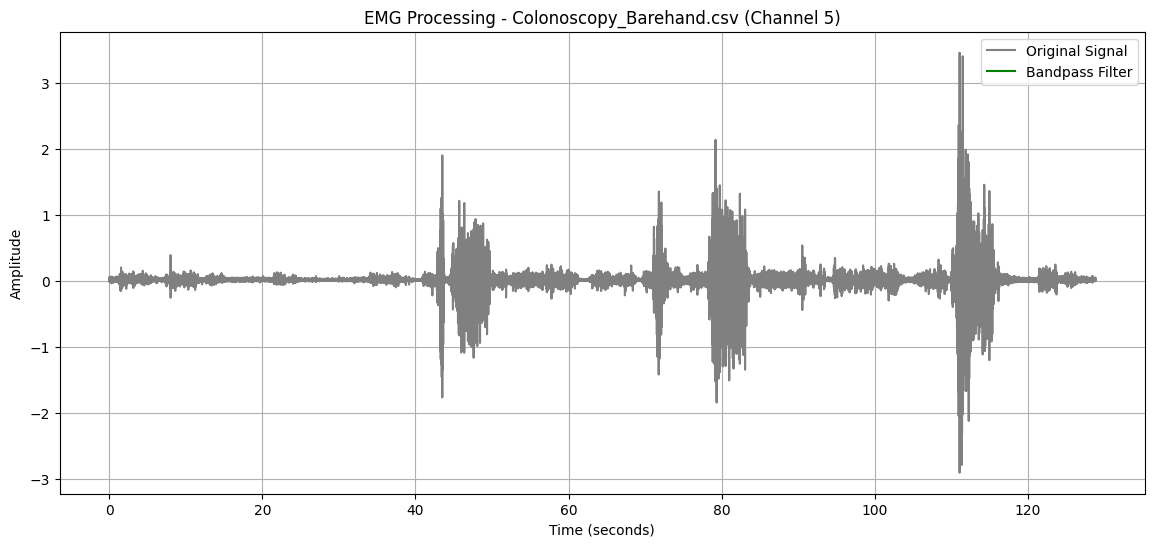

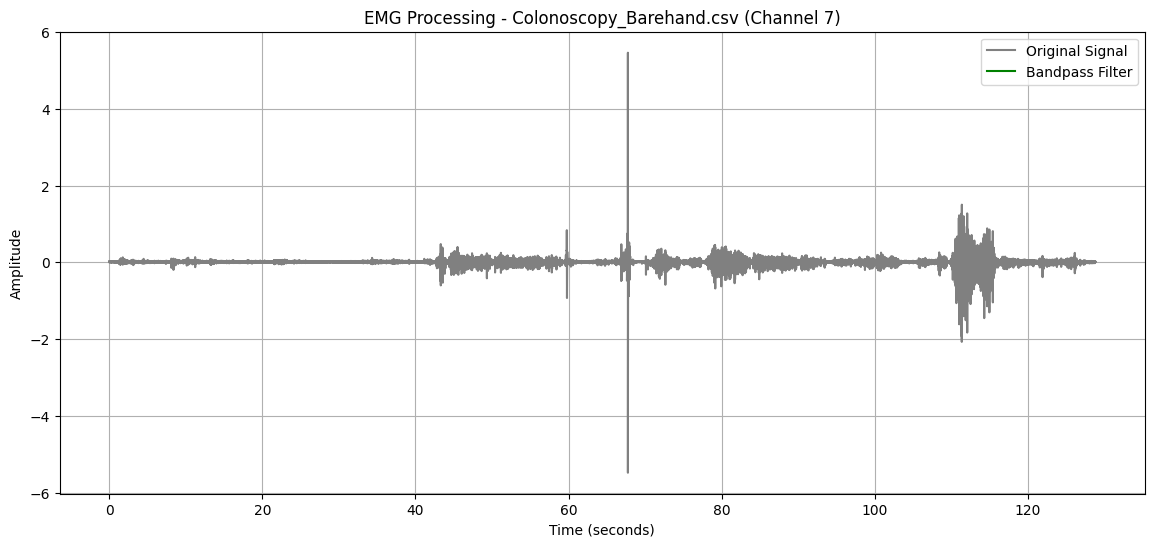

In [ ]:
# PLOTTING THE DIFFERENT FILTERS ON COLONOSCOPY TRIALS
import os
import numpy as np
import matplotlib.pyplot as plt

DATA_CALIBRATE_DIR = "/content/drive/MyDrive/data/ava/experiment/Colonoscopy"
plotting = True

# Iterate through all CSV files in the directory
for file in os.listdir(DATA_CALIBRATE_DIR):
    if file.endswith('.csv'):
        print(f"Processing file: {file}")
        try:
            csv_file = CSVFile(os.path.join(DATA_CALIBRATE_DIR, file))
            csv_file.parse_header()

            # Loop through columns 1, 3, 5, 7
            for col_num in range(1, 8, 2):
                col = csv_file.data[:, col_num]
                fs = csv_file.get_column_frequency(col_num)  # Sampling frequency
                nq = fs / 2  # Nyquist frequency
                h = 20
                l = 400

                # Original signal
                time_data = csv_file.data[:, col_num - 1]

                # Apply filters
                notch_filtered_col = notch_filter(fs, col)
                bpf_filtered_col = bpf(h, l, nq, notch_filtered_col)
                bpf_filtered_col_abs = np.abs(bpf_filtered_col)  # Full-wave rectification
                lpf_filtered_col = lpf(5, fs, bpf_filtered_col_abs)

                # Plot all signals in one figure
                plt.figure(figsize=(14, 6))
                plt.plot(time_data, col, label='Original Signal', color='gray')
                plt.plot(time_data, bpf_filtered_col, label='Bandpass Filter', color='green')
                plt.title(f'EMG Processing - {file} (Channel {col_num})')
                plt.xlabel('Time (seconds)')
                plt.ylabel('Amplitude')
                plt.grid(True)
                plt.legend()
                plt.show()

        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

# FILTERING PARAMETERS ANALYSIS

Reading file:  /content/drive/MyDrive/data/ava/ava_mvc/Trial_10.csv


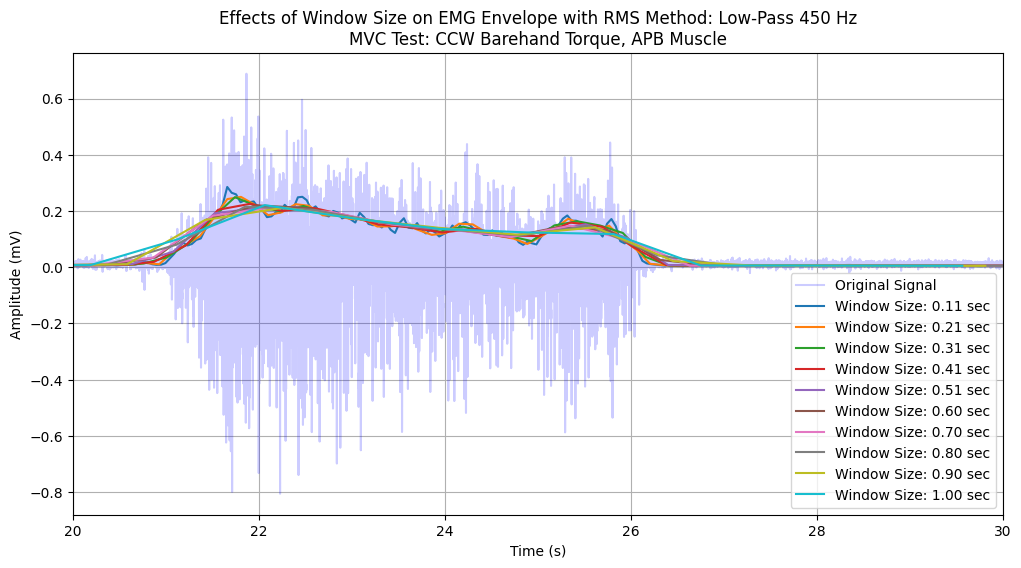

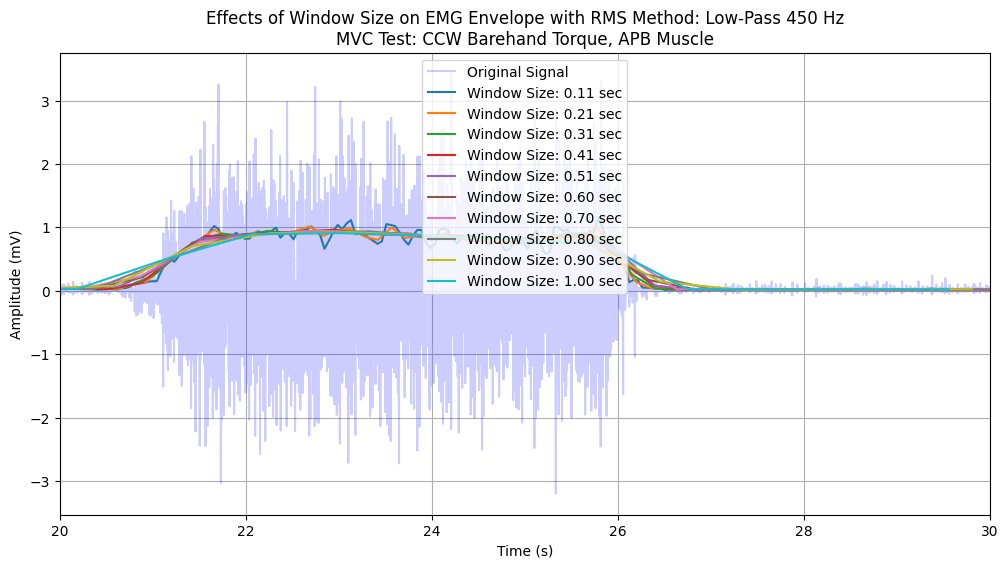

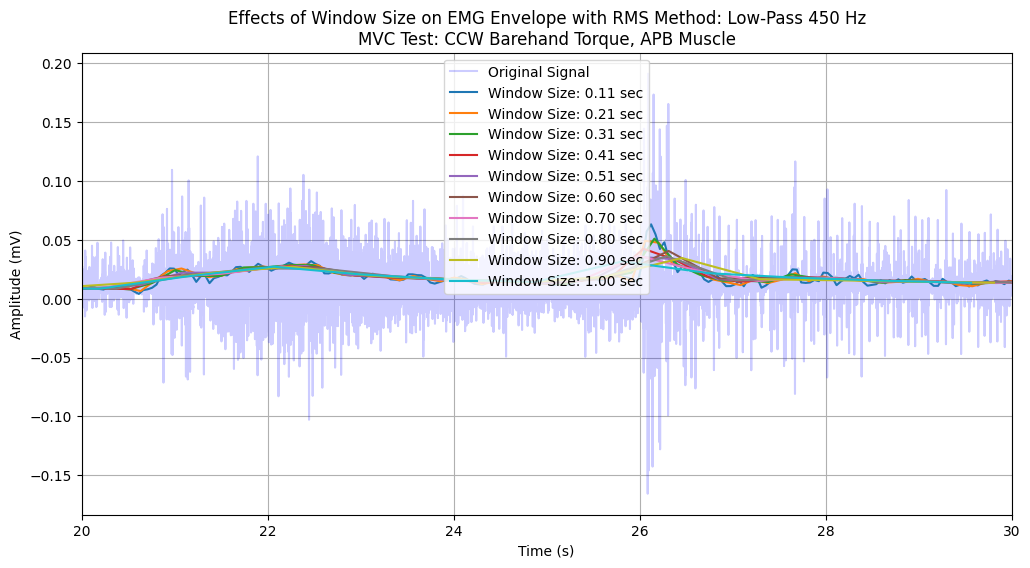

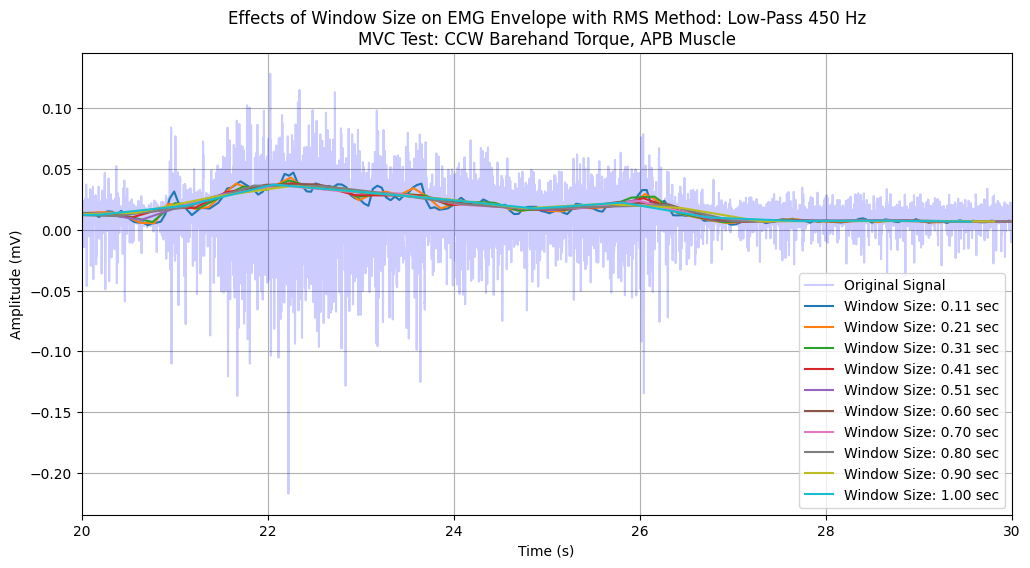

In [ ]:
# varying window sizes for RMS
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

DATA_CALIBRATE_DIR = "/content/drive/MyDrive/data/ava/ava_mvc/"
window_overlap_seconds = 0.0625
cutoff_frequencies = [(25, 450)]  # High-pass at 25Hz, Low-pass at 450Hz
#window_sizes = [0.05, 0.125, 1, 2]  # Vary window size from 0 to 1 second in 5 steps
window_sizes = np.linspace(0.11,1.0, 10)

for file in os.listdir(DATA_CALIBRATE_DIR):
    print("Reading file: ", DATA_CALIBRATE_DIR + file)
    csv_file = CSVFile(DATA_CALIBRATE_DIR + file)
    csv_file.parse_header()

    for col_num in range(1, 8, 2):
        fs = csv_file.get_column_frequency(col_num)
        nq = fs / 2
        col = csv_file.data[:, col_num]
        notch_filtered_col = notch_filter(fs, col)
        time_axis = np.arange(len(notch_filtered_col)) / fs

        for h, l in cutoff_frequencies:
            bpf_filtered_col = bpf(h, l, nq, notch_filtered_col)

            plt.figure(figsize=(12, 6))
            plt.plot(time_axis, notch_filtered_col, 'b', label='Original Signal', alpha=0.2)

            for window_length_seconds in window_sizes:
                if window_length_seconds == 0:
                    continue  # Skip zero window size

                window_size_samples = round(fs * window_length_seconds)
                overlap_size_samples = round(fs * window_overlap_seconds)
                step_size_samples = window_size_samples - overlap_size_samples

                mean_data = []
                time_data = []
                for start_idx in range(0, len(bpf_filtered_col) - window_size_samples + 1, step_size_samples):
                    end_idx = start_idx + window_size_samples
                    window_data = bpf_filtered_col[start_idx:end_idx]
                    rms_value = np.sqrt(np.mean(window_data ** 2))
                    mean_data.append(rms_value)
                    center_time = start_idx / fs + (window_size_samples / 2) / fs
                    time_data.append(center_time)

                plt.plot(time_data, mean_data, label=f'Window Size: {window_length_seconds:.2f} sec')

            plt.xlabel("Time (s)")
            plt.xlim(20, 30)  # Only plot between 20-30 seconds
            plt.ylabel("Amplitude (mV)")
            plt.title(f"Effects of Window Size on EMG Envelope with RMS Method: Low-Pass {l} Hz\nMVC Test: CCW Barehand Torque, APB Muscle")
            plt.legend()
            plt.grid()
            plt.show()


Reading file:  /content/drive/MyDrive/data/ava/ava_mvc/Trial_10.csv


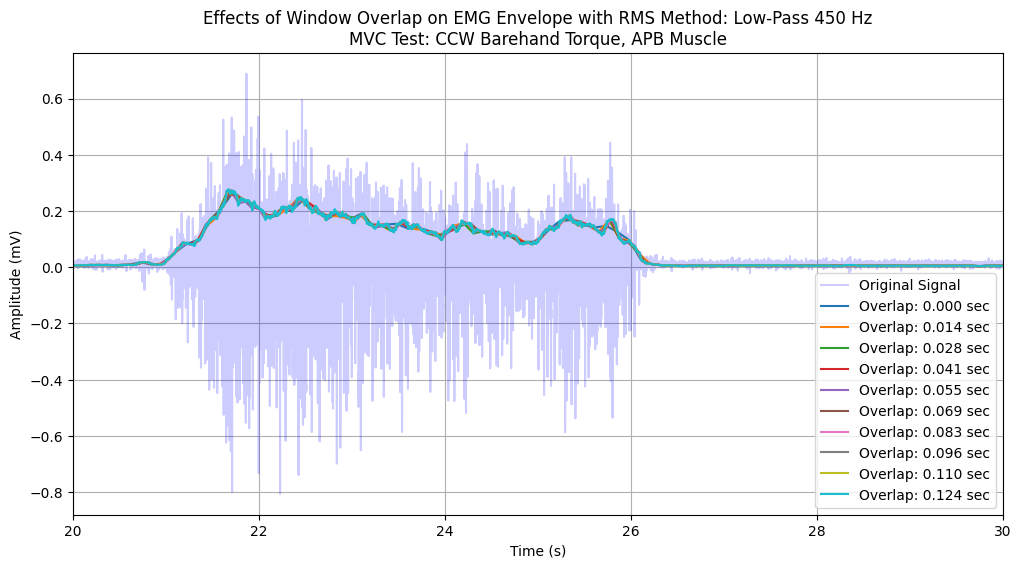

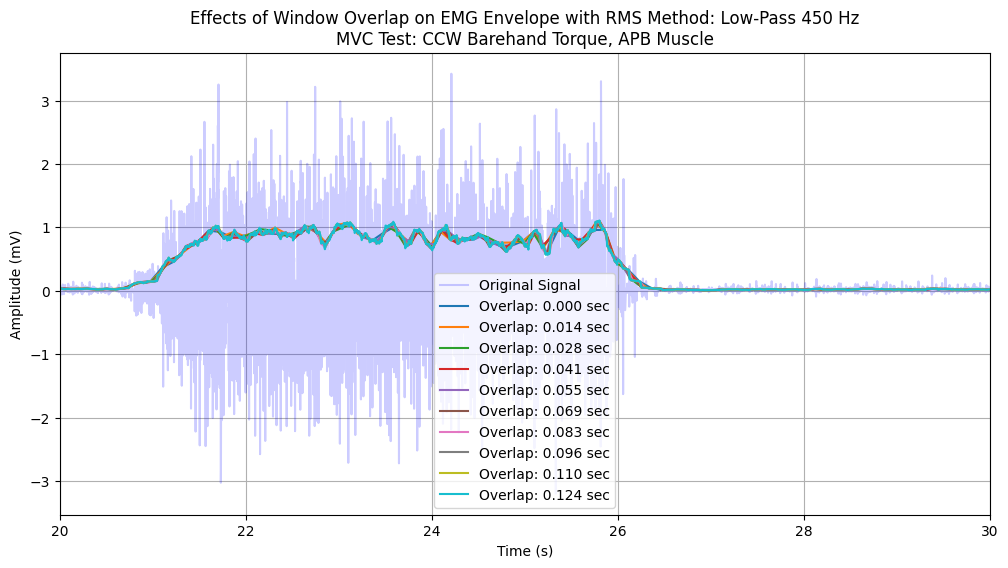

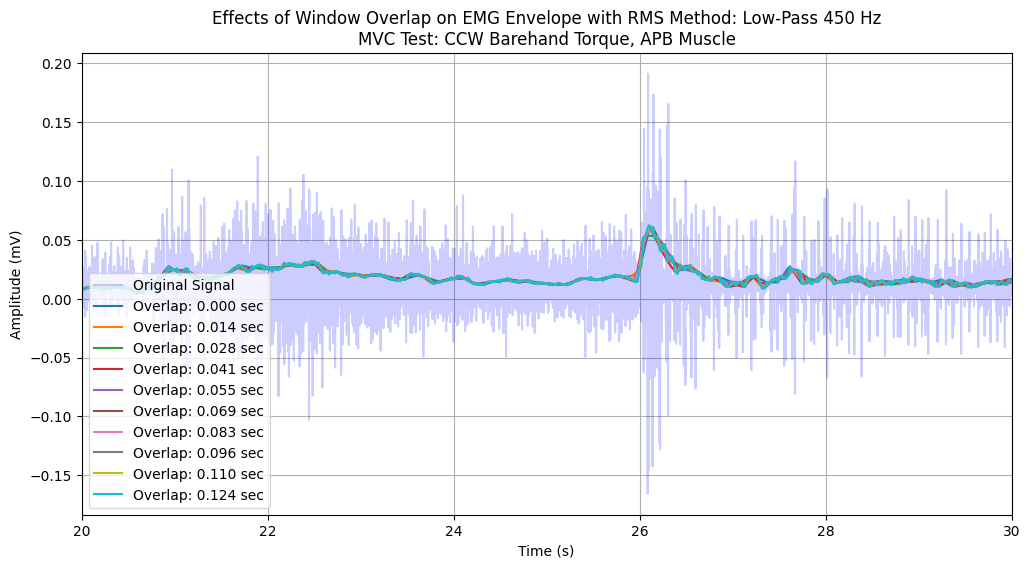

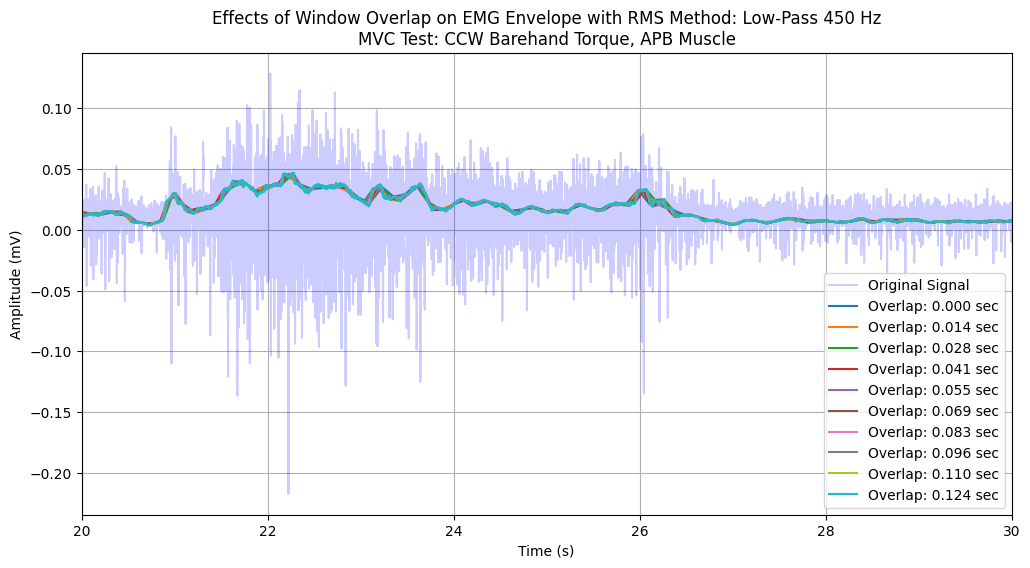

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

DATA_CALIBRATE_DIR = "/content/drive/MyDrive/data/ava/ava_mvc/"

# Varying overlap in seconds (not percent)
overlap_seconds_list = np.linspace(0, 0.124, 10)  # Must be less than window size

window_size_seconds = 0.125  # Fixed window size
cutoff_frequencies = [(25, 450)]  # High-pass at 25Hz, Low-pass at 450Hz

for file in os.listdir(DATA_CALIBRATE_DIR):
    print("Reading file: ", DATA_CALIBRATE_DIR + file)
    csv_file = CSVFile(DATA_CALIBRATE_DIR + file)
    csv_file.parse_header()

    for col_num in range(1, 8, 2):
        fs = csv_file.get_column_frequency(col_num)
        nq = fs / 2
        col = csv_file.data[:, col_num]
        notch_filtered_col = notch_filter(fs, col)
        time_axis = np.arange(len(notch_filtered_col)) / fs

        for h, l in cutoff_frequencies:
            bpf_filtered_col = bpf(h, l, nq, notch_filtered_col)

            plt.figure(figsize=(12, 6))
            plt.plot(time_axis, notch_filtered_col, 'b', label='Original Signal', alpha=0.2)

            window_size_samples = round(fs * window_size_seconds)

            for overlap_sec in overlap_seconds_list:
                if overlap_sec >= window_size_seconds:
                    continue  # Overlap cannot be greater than or equal to window size

                overlap_size_samples = round(fs * overlap_sec)
                step_size_samples = window_size_samples - overlap_size_samples

                mean_data = []
                time_data = []

                for start_idx in range(0, len(bpf_filtered_col) - window_size_samples + 1, step_size_samples):
                    end_idx = start_idx + window_size_samples
                    window_data = bpf_filtered_col[start_idx:end_idx]
                    rms_value = np.sqrt(np.mean(window_data ** 2))
                    mean_data.append(rms_value)
                    center_time = start_idx / fs + (window_size_samples / 2) / fs
                    time_data.append(center_time)

                plt.plot(time_data, mean_data, label=f'Overlap: {overlap_sec:.3f} sec')

            plt.xlabel("Time (s)")
            plt.xlim(20, 30)
            plt.ylabel("Amplitude (mV)")
            plt.title(f"Effects of Window Overlap on EMG Envelope with RMS Method: Low-Pass {l} Hz\nMVC Test: CCW Barehand Torque, APB Muscle")
            plt.legend()
            plt.grid()
            plt.show()



In [ ]:
#AVERAGE OF TOP 2 MAX VALUES
import os
import numpy as np

# FILTER AND FIND MAX VALUE FROM MVC TRIALS
DATA_CALIBRATE_DIR = "/content/drive/MyDrive/data/ava/mvc/"

# Initialize storage for top 2 max values for each column
column_max_values = [[0.0, 0.0] for _ in range(4)]  # 4 columns (1, 3, 5, 7)
column_max_files = [[None, None] for _ in range(4)]
max_values = {1: 0.0, 3: 0.0, 5: 0.0, 7: 0.0}

window_length_seconds = 0.125
window_overlap_seconds = 0.0625

# Iterate through all files in the defined directory
for file in os.listdir(DATA_CALIBRATE_DIR):
    print("Reading file: ", DATA_CALIBRATE_DIR + file)
    csv_file = CSVFile(DATA_CALIBRATE_DIR + file)
    csv_file.parse_header()

    column_max_value_index = 0  # Keep track of the index
    for col_num in range(1, 8, 2):  # Iterate over column numbers (1, 3, 5, 7)
        # Get the sampling frequency based on the current column number
        fs = csv_file.get_column_frequency(col_num)

        # Nyquist frequency is half the sampling rate
        nq = fs / 2

        # Settings for band-pass filter
        h = 25  # low cut-off frequency
        l = 450  # high cut-off frequency

        # Get the data from the column
        col = csv_file.data[:, col_num]

        # Apply notch filter to column
        notch_filtered_col = notch_filter(fs, col)

        # Apply band-pass filter/high-pass/low-pass
        bpf_filtered_col = lpf(l, nq, notch_filtered_col)

        # Calculate RMS with a moving window
        window_size_samples = round(fs * window_length_seconds)
        overlap_size_samples = round(fs * window_overlap_seconds)
        step_size_samples = window_size_samples - overlap_size_samples

        mean_data = []

        # Moving window
        for start_idx in range(0, len(notch_filtered_col) - window_size_samples + 1, step_size_samples):
            end_idx = start_idx + window_size_samples
            window_data = notch_filtered_col[start_idx:end_idx]

            # Calculate RMS for the window
            rms_value = np.sqrt(np.mean(window_data ** 2))  # RMS = sqrt(mean(window^2))
            mean_data.append(rms_value)

        # Convert lists to numpy arrays for processing
        mean_data = np.array(mean_data)

        # Get the max value after filtering
        _max_val = np.max(mean_data)
        print(f"Column number: {col_num}, Max Value: {_max_val}")

        # Update top 2 max values
        top_2 = column_max_values[column_max_value_index]
        if _max_val > top_2[0]:  # New max is higher than the highest
            top_2 = [_max_val, top_2[0]]
            column_max_files[column_max_value_index] = [str(file), column_max_files[column_max_value_index][0]]
        elif _max_val > top_2[1]:  # New max is higher than the second highest
            top_2[1] = _max_val
            column_max_files[column_max_value_index][1] = str(file)

        # Store the updated top 2 values back
        column_max_values[column_max_value_index] = top_2

        # Calculate the average of the top 2 max values
        max_values[col_num] = sum(top_2) / 2

        column_max_value_index += 1

# Print results
print("Top 2 max values per column: ", column_max_values)
print("Files corresponding to top 2 max values: ", column_max_files)
print("Averaged max values per column: ", max_values)

for col_num, value in max_values.items():
    print(f"{col_num}: {value:.3g}")

Reading file:  /content/drive/MyDrive/data/ava/mvc/Trial_2.csv


Exception: [ERROR]: Error encountered processing row number 44131

# DELSYS SOFTWARE DATA ANALYSIS

In [ ]:
# PLOTTING MEAN ACTIVE FOR DATA FROM DELSYS SOFTWARE
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/delsys/kyoto_barehand/"
print(f"Data directory: {DATA_DIR}")
print(f"Files in directory: {os.listdir(DATA_DIR)}")

file_averages = {}
files_to_plot = ["apb.xlsx", "ecr.xlsx", "fds.xlsx", "fcr.xlsx"]

for file_name in files_to_plot:
    file_path = os.path.join(DATA_DIR, file_name)
    if os.path.exists(file_path):
        try:
            df = pd.read_excel(file_path, header=None, skiprows=6)
            second_column = df.iloc[:, 1]
            numeric_values = pd.to_numeric(second_column, errors='coerce')
            filtered_data = numeric_values[numeric_values > 5]
            if not filtered_data.empty:
                average = np.mean(filtered_data)
            else:
                average = 0.0
                print(f"No values > 5 in {file_name}. Setting average to 0.")
            file_averages[file_name] = average
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
    else:
        print(f"File {file_name} not found in directory.")
        file_averages[file_name] = np.nan

print("\n--- Averages for each file ---")
for file, average in file_averages.items():
    print(f"{file}: {average}")

# Plotting
file_names = list(file_averages.keys())
averages = list(file_averages.values())

file_names_clean = [f for f, a in zip(file_names, averages) if not np.isnan(a)]
averages_clean = [a for a in averages if not np.isnan(a)]

plt.figure(figsize=(10, 6))
plt.bar(file_names_clean, averages_clean, color='green')
plt.xlabel("Muscle")
plt.ylabel("Mean Active EMG (%MVC)")
plt.title("Mean Active EMG for Endogrip During Colonoscopy - Subject 2")
plt.xticks(rotation=45, ha='right')

# Set y-axis limits and ticks (0 to 100 with steps of 20)
plt.ylim(0, 100)  # Set the y-axis limits from 0 to 100
plt.yticks(np.arange(0, 101, 20))  # Set ticks every 20 units

plt.tight_layout()
plt.show()

# New Section